### try real world data 

In [1]:
import logging
import os
import pickle
import random
import sys

# from bds.bbSampleTree import BranchAndBoundNaive
import time
from time import time

import gmpy2 as gmp
import matplotlib as mpl
import matplotlib.pyplot as plt

# from bds.bounds_utils import find_equivalence_classes
import numpy as np
import pandas as pd
import ray
from contexttimer import Timer
from gmpy2 import mpfr, mpz

# from bds.bb import BranchAndBoundNaive, BranchAndBoundV1, BranchAndBoundV0, BranchAndBoundV2
from logzero import logger
from pylab import axes, boxplot, figure, legend, plot, savefig, setp, show, xlim, ylim
from sklearn import datasets

from bds.bb import get_ground_truth_count
from bds.bbSampleTreeApproxCounting import BranchAndBoundNaive
from bds.fpgrowth import build_fptree, fpgrowth_on_tree, preprocess_transaction_list
from bds.gf2 import GF
from bds.meel import approx_mc2, approx_mc2_core
from bds.rule import Rule
from bds.sat.min_freq import construct_min_freq_program
from bds.sat.solver import construct_solver
from bds.utils import bin_array, bin_random, mpz_set_bits, randints, solutions_to_dict
from tests.utils import assert_close_mpfr, assert_dict_allclose

%cd ..



# from bds.cbb_v2 import *

logger.setLevel(logging.DEBUG)

num_pts = 500

show_progres = True
rand_seed = 1234

/u/50/ciaperm1/unix/sampling-rashomon-decision-set-code


TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [3]:
# Load the CSV file using Pandas
data = pd.read_csv("data/compas_test-binary.csv")

# Print the data
data.head()

sex:Male  age:18-20  age:21-22  age:23-25  age:26-45  age:>45   
0         1          0          0          0          1        0  \
1         1          0          0          0          1        0   
2         1          0          0          0          1        0   
3         1          0          0          1          0        0   
4         1          0          0          0          1        0   

   juvenile-felonies:>0  juvenile-misdemeanors:>0  juvenile-crimes:>0   
0                     0                         0                   0  \
1                     0                         0                   0   
2                     0                         0                   0   
3                     0                         0                   0   
4                     0                         0                   0   

   priors:2-3  priors:=0  priors:=1  priors:>3   
0           0          0          0          1  \
1           0          0          0          1   
2           0          0          0          1   
3           1          0          0          0   
4           0          1          0          0   

   current-charge-degree:Misdemeanor  recidivate-within-two-years:1  
0                                  0                              0  
1                                  1                              1  
2                                  0                              1  
3                                  0                              1  
4                                  1                              0

In [7]:
# read labels
f = open("data/compas_test.label")
labels = []
for row in f.readlines():
    labels.append(list(map(int, row.split(" ")[1:])))

In [8]:
y = np.array(labels[1], dtype=bool)

In [9]:
assert len(y) == X.shape[0]

In [10]:
# now we need to extract rules
X_bag = [{j for j, x in enumerate(row) if x} for row in X]

In [12]:
lmbd = 0.1
min_support = lmbd * X.shape[0] / 2

In [13]:
min_support

36.050000000000004

In [16]:
all_n_rules = []
lmbd = 0.1
ub = 0.3
rand_seed = 1234
n_reps = 1

delta = 0.8
eps = 0.8

show_progres = True

all_averages_times_MC = []
all_averages_times_GT = []


all_averages_counts_MC = []
all_averages_counts_GT = []


for min_support in [7, 10, 20, 30, 40, 50][::-1]:
    ordered_input_data = preprocess_transaction_list(X_bag, min_support)
    tree = build_fptree(ordered_input_data)
    frequent_itemsets = set(fpgrowth_on_tree(tree, set(), min_support))

    all_n_rules.append(len(frequent_itemsets))

    # Now create rules
    rules = []
    for i, itemset in enumerate(frequent_itemsets):
        tt = compute_truthtable(X, itemset)
        this_Rule = Rule(
            id=i + 1, name="rule_" + str(i), cardinality=len(itemset), truthtable=tt
        )
        # we need the truthtable for this itemset
        rules.append(this_Rule)

    pickle.dump(rules, open("rules/rules_compas_03_" + str(len(rules)), "wb"))

    # approxMC
    all_times_MC = []
    all_counts_MC = []

    all_times_GT = []
    all_counts_GT = []

    for _ in range(n_reps):
        t = time.time()
        test_cnt = approx_mc2(
            rules,
            y,
            lmbd=lmbd,
            ub=ub,
            delta=delta,
            eps=eps,
            rand_seed=rand_seed,
            show_progress=show_progres,
            parallel=False,
            log_level=logging.WARN,
        )

        elapsed = time.time() - t
        all_times_MC.append(elapsed)
        all_counts_MC.append(test_cnt)

        # complete enumeration
        ref_count = get_ground_truth_count(rules, y, lmbd, ub)
        all_times_GT.append(elapsed)
        all_counts_GT.append(ref_count)

    all_averages_times_MC.append(np.mean(all_times_MC))
    all_averages_times_GT.append(np.mean(all_times_GT))

    all_averages_counts_MC.append(np.mean(all_counts_MC))
    all_averages_counts_GT.append(np.mean(all_counts_GT))

    pickle.dump(
        all_averages_times_MC, open("all_averages_times_MC_" + str(len(rules)), "wb")
    )
    pickle.dump(
        all_averages_times_GT, open("all_averages_times_GT_" + str(len(rules)), "wb")
    )

    pickle.dump(
        all_averages_counts_MC, open("all_averages_counts_MC_" + str(len(rules)), "wb")
    )
    pickle.dump(
        all_averages_counts_GT, open("all_averages_counts_GT_" + str(len(rules)), "wb")
    )

    # sampleTree
    # bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=4, k=150)
    # Z = bb.runST()

[D 230704 12:31:59 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230704 12:31:59 meel:363] thresh = 72.95
[D 230704 12:31:59 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230704 12:31:59 meel:374] BB solving (thresh=72) takes 0.01 secs
    and gave 71 solutions
[D 230704 12:31:59 meel:379] exit since number of solutions 71 < 72
[D 230704 12:31:59 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230704 12:31:59 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230704 12:31:59 meel:363] thresh = 72.95
[D 230704 12:31:59 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230704 12:31:59 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230704 12:31:59 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230704 12:31:59 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:31:59 meel:278] initi

rand_seed: 822569775
time_cost_info: 
|1|0.048674652993213385|
|0|0.04381753603229299|
rand_seed: 2137449171
time_cost_info: 
|1|0.02921822399366647|
|0|0.024381514987908304|


[D 230704 12:31:59 cbb:129] simplifying A x = t using rref
[D 230704 12:31:59 cbb:136] density(A_rref) = 1.999% (from 49.9%)
[D 230704 12:31:59 meel:281] solving takes 0.03 secs
[D 230704 12:31:59 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:31:59 meel:98] calling log_search with thresh=72
[D 230704 12:31:59 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:31:59 meel:137] ---- solve m = 1----
[D 230704 12:31:59 cbb:160] setting up the parity constraint system
[D 230704 12:31:59 cbb:129] simplifying A x = t using rref
[D 230704 12:31:59 cbb:136] density(A_rref) = 42.857% (from 42.9%)
[D 230704 12:31:59 meel:149] search tree size: 120
[D 230704 12:31:59 meel:150] number of prefix evaluations: 2498
[D 230704 12:31:59 meel:152] solving takes 0.04 secs
[D 230704 12:31:59 meel:196] |Y| < thresh (57 < 72)
[D 230704 12:31:59 meel:137] ---- solve m = 0----
[D 230704 12:31:59 cbb:160] setting up the par

rand_seed: 524453158
time_cost_info: 
|1|0.03702239796984941|
|0|0.0199660140206106|
rand_seed: 1365105717
time_cost_info: 
|1|0.03076578100444749|
|0|0.01869148697005585|
rand_seed: 1880026316


[D 230704 12:31:59 meel:149] search tree size: 110
[D 230704 12:31:59 meel:150] number of prefix evaluations: 2495
[D 230704 12:31:59 meel:152] solving takes 0.04 secs
[D 230704 12:31:59 meel:196] |Y| < thresh (48 < 72)
[D 230704 12:31:59 meel:137] ---- solve m = 0----
[D 230704 12:31:59 cbb:160] setting up the parity constraint system
[D 230704 12:31:59 cbb:129] simplifying A x = t using rref
[D 230704 12:31:59 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:31:59 meel:149] search tree size: 136
[D 230704 12:31:59 meel:150] number of prefix evaluations: 3422
[D 230704 12:31:59 meel:152] solving takes 0.02 secs
[D 230704 12:31:59 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:31:59 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:31:59 meel:410] running approx_mc2_core takes 0.09s
[D 230704 12:31:59 meel:413] num_cells: 1, num_sols: 72
 16%|██████▉                                     | 5/32 [00:00<00:02, 10.07it/s][D 230704 12:31:59 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.03952320199459791|
|0|0.022702221991494298|
rand_seed: 481516916
time_cost_info: 
|1|0.026320965960621834|
|0|0.022622968012001365|
rand_seed: 1225605784
time_cost_info: 
|1|0.027329797972925007|
|0|0.02018200297607109|


[D 230704 12:32:00 meel:281] solving takes 0.02 secs
[D 230704 12:32:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:00 meel:98] calling log_search with thresh=72
[D 230704 12:32:00 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:00 meel:137] ---- solve m = 1----
[D 230704 12:32:00 cbb:160] setting up the parity constraint system
[D 230704 12:32:00 cbb:129] simplifying A x = t using rref
[D 230704 12:32:00 cbb:136] density(A_rref) = 59.740% (from 59.7%)
[D 230704 12:32:00 meel:149] search tree size: 111
[D 230704 12:32:00 meel:150] number of prefix evaluations: 2498
[D 230704 12:32:00 meel:152] solving takes 0.03 secs
[D 230704 12:32:00 meel:196] |Y| < thresh (47 < 72)
[D 230704 12:32:00 meel:137] ---- solve m = 0----
[D 230704 12:32:00 cbb:160] setting up the parity constraint system
[D 230704 12:32:00 cbb:129] simplifying A x = t using rref
[D 230704 12:32:00 cbb:136] density(A_rref) 

rand_seed: 1165481977
time_cost_info: 
|1|0.030055772978812456|
|0|0.02456052298657596|
rand_seed: 1202486927
time_cost_info: 
|1|0.03108165302546695|
|0|0.022810026013758034|
rand_seed: 1549064881


[D 230704 12:32:00 cbb:136] density(A_rref) = 57.143% (from 57.1%)
[D 230704 12:32:00 meel:149] search tree size: 119
[D 230704 12:32:00 meel:150] number of prefix evaluations: 2495
[D 230704 12:32:00 meel:152] solving takes 0.03 secs
[D 230704 12:32:00 meel:196] |Y| < thresh (56 < 72)
[D 230704 12:32:00 meel:137] ---- solve m = 0----
[D 230704 12:32:00 cbb:160] setting up the parity constraint system
[D 230704 12:32:00 cbb:129] simplifying A x = t using rref
[D 230704 12:32:00 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:00 meel:149] search tree size: 136
[D 230704 12:32:00 meel:150] number of prefix evaluations: 3422
[D 230704 12:32:00 meel:152] solving takes 0.02 secs
[D 230704 12:32:00 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:00 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:00 meel:410] running approx_mc2_core takes 0.09s
[D 230704 12:32:00 meel:413] num_cells: 1, num_sols: 72
[D 230704 12:32:00 bb:53] calling ConstrainedBranchAndBound with ub=0.3

time_cost_info: 
|1|0.02642513398313895|
|0|0.020885583013296127|
rand_seed: 1170776343
time_cost_info: 
|1|0.02740467502735555|
|0|0.023123678984120488|
rand_seed: 646980841
time_cost_info: 
|1|0.02742764400318265|
|0|0.019955789030063897|


[D 230704 12:32:00 cbb:136] density(A_rref) = 2.033% (from 50.4%)
[D 230704 12:32:00 meel:281] solving takes 0.03 secs
[D 230704 12:32:00 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:00 meel:98] calling log_search with thresh=72
[D 230704 12:32:00 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:00 meel:137] ---- solve m = 1----
[D 230704 12:32:00 cbb:160] setting up the parity constraint system
[D 230704 12:32:00 cbb:129] simplifying A x = t using rref
[D 230704 12:32:00 cbb:136] density(A_rref) = 40.260% (from 40.3%)
[D 230704 12:32:00 meel:149] search tree size: 113
[D 230704 12:32:00 meel:150] number of prefix evaluations: 2497
[D 230704 12:32:00 meel:152] solving takes 0.03 secs
[D 230704 12:32:00 meel:196] |Y| < thresh (51 < 72)
[D 230704 12:32:00 meel:137] ---- solve m = 0----
[D 230704 12:32:00 cbb:160] setting up the parity constraint system
[D 230704 12:32:00 cbb:129] simplifyi

rand_seed: 1187404954
time_cost_info: 
|1|0.03298032900784165|
|0|0.020695722952950746|
rand_seed: 852631582
time_cost_info: 
|1|0.026439359004143625|
|0|0.01955553999869153|
rand_seed: 1296531115


[D 230704 12:32:00 meel:149] search tree size: 112
[D 230704 12:32:00 meel:150] number of prefix evaluations: 2496
[D 230704 12:32:00 meel:152] solving takes 0.03 secs
[D 230704 12:32:00 meel:196] |Y| < thresh (49 < 72)
[D 230704 12:32:00 meel:137] ---- solve m = 0----
[D 230704 12:32:00 cbb:160] setting up the parity constraint system
[D 230704 12:32:00 cbb:129] simplifying A x = t using rref
[D 230704 12:32:00 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:00 meel:149] search tree size: 136
[D 230704 12:32:00 meel:150] number of prefix evaluations: 3423
[D 230704 12:32:00 meel:152] solving takes 0.02 secs
[D 230704 12:32:00 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:00 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:00 meel:410] running approx_mc2_core takes 0.09s
[D 230704 12:32:00 meel:413] num_cells: 1, num_sols: 72
 47%|████████████████████▏                      | 15/32 [00:01<00:01, 10.87it/s][D 230704 12:32:00 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.03424849401926622|
|0|0.023620030959136784|
rand_seed: 1353614494
time_cost_info: 
|1|0.03805323998676613|
|0|0.025861662987153977|
rand_seed: 1967693548


[D 230704 12:32:00 meel:149] search tree size: 136
[D 230704 12:32:00 meel:150] number of prefix evaluations: 3425
[D 230704 12:32:00 meel:152] solving takes 0.02 secs
[D 230704 12:32:00 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:00 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:00 meel:410] running approx_mc2_core takes 0.10s
[D 230704 12:32:00 meel:413] num_cells: 1, num_sols: 72
 53%|██████████████████████▊                    | 17/32 [00:01<00:01, 10.36it/s][D 230704 12:32:00 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:00 meel:278] initial solving under 76 constraints
[D 230704 12:32:00 cbb:160] setting up the parity constraint system
[D 230704 12:32:00 cbb:129] simplifying A x = t using rref
[D 230704 12:32:00 cbb:136] density(A_rref) = 3.213% (from 51.4%)
[D 230704 12:32:01 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:01 meel:281] solving takes 0.02 secs
[D 230704 12:32:01 meel:288] with |Y

time_cost_info: 
|1|0.03601662797154859|
|0|0.02289869199739769|
rand_seed: 682106748
time_cost_info: 
|1|0.03389218798838556|
|0|0.025544765987433493|
rand_seed: 1614618394
time_cost_info: 
|1|0.027145345986355096|
|0|0.019317107973620296|


[D 230704 12:32:01 cbb:136] density(A_rref) = 1.931% (from 49.6%)
[D 230704 12:32:01 meel:281] solving takes 0.02 secs
[D 230704 12:32:01 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:01 meel:98] calling log_search with thresh=72
[D 230704 12:32:01 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:01 meel:137] ---- solve m = 1----
[D 230704 12:32:01 cbb:160] setting up the parity constraint system
[D 230704 12:32:01 cbb:129] simplifying A x = t using rref
[D 230704 12:32:01 cbb:136] density(A_rref) = 51.948% (from 51.9%)
[D 230704 12:32:01 meel:149] search tree size: 109
[D 230704 12:32:01 meel:150] number of prefix evaluations: 2498
[D 230704 12:32:01 meel:152] solving takes 0.03 secs
[D 230704 12:32:01 meel:196] |Y| < thresh (46 < 72)
[D 230704 12:32:01 meel:137] ---- solve m = 0----
[D 230704 12:32:01 cbb:160] setting up the parity constraint system
[D 230704 12:32:01 cbb:129] simplifyi

rand_seed: 498808182
time_cost_info: 
|1|0.028025866020470858|
|0|0.021624006039928645|
rand_seed: 1536813498
time_cost_info: 
|1|0.030889273970387876|
|0|0.019725735008250922|
rand_seed: 55437432


[D 230704 12:32:01 meel:150] number of prefix evaluations: 2498
[D 230704 12:32:01 meel:152] solving takes 0.03 secs
[D 230704 12:32:01 meel:196] |Y| < thresh (46 < 72)
[D 230704 12:32:01 meel:137] ---- solve m = 0----
[D 230704 12:32:01 cbb:160] setting up the parity constraint system
[D 230704 12:32:01 cbb:129] simplifying A x = t using rref
[D 230704 12:32:01 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:01 meel:149] search tree size: 136
[D 230704 12:32:01 meel:150] number of prefix evaluations: 3425
[D 230704 12:32:01 meel:152] solving takes 0.02 secs
[D 230704 12:32:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:01 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:01 meel:410] running approx_mc2_core takes 0.09s
[D 230704 12:32:01 meel:413] num_cells: 1, num_sols: 72
[D 230704 12:32:01 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:01 meel:278] initial solving under 76 constraints
[D 230704 12:32:01 cbb:160] setting up th

time_cost_info: 
|1|0.02773562999209389|
|0|0.02143146697198972|
rand_seed: 4274032
time_cost_info: 
|1|0.03742011298891157|
|0|0.025936206977348775|
rand_seed: 2090933724


[D 230704 12:32:01 meel:149] search tree size: 136
[D 230704 12:32:01 meel:150] number of prefix evaluations: 3425
[D 230704 12:32:01 meel:152] solving takes 0.03 secs
[D 230704 12:32:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:01 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:01 meel:410] running approx_mc2_core takes 0.10s
[D 230704 12:32:01 meel:413] num_cells: 1, num_sols: 72
[D 230704 12:32:01 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:01 meel:278] initial solving under 76 constraints
[D 230704 12:32:01 cbb:160] setting up the parity constraint system
[D 230704 12:32:01 cbb:129] simplifying A x = t using rref
[D 230704 12:32:01 cbb:136] density(A_rref) = 1.982% (from 49.0%)
[D 230704 12:32:01 meel:281] solving takes 0.02 secs
[D 230704 12:32:01 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:01 meel:98] calling log_search with thresh=72
[D 230704 12:32:01 bb:53

time_cost_info: 
|1|0.03597883303882554|
|0|0.028439323999918997|
rand_seed: 787967301
time_cost_info: 
|1|0.02792279701679945|
|0|0.020057650981470942|
rand_seed: 1421700432
time_cost_info: 
|1|0.02698457398219034|
|0|0.018091492005623877|
rand_seed: 913548233


[D 230704 12:32:01 meel:149] search tree size: 112
[D 230704 12:32:01 meel:150] number of prefix evaluations: 2495
[D 230704 12:32:01 meel:152] solving takes 0.03 secs
[D 230704 12:32:01 meel:196] |Y| < thresh (49 < 72)
[D 230704 12:32:01 meel:137] ---- solve m = 0----
[D 230704 12:32:01 cbb:160] setting up the parity constraint system
[D 230704 12:32:01 cbb:129] simplifying A x = t using rref
[D 230704 12:32:01 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:01 meel:149] search tree size: 136
[D 230704 12:32:01 meel:150] number of prefix evaluations: 3422
[D 230704 12:32:01 meel:152] solving takes 0.02 secs
[D 230704 12:32:01 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:01 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:01 meel:410] running approx_mc2_core takes 0.09s
[D 230704 12:32:01 meel:413] num_cells: 1, num_sols: 72
 84%|████████████████████████████████████▎      | 27/32 [00:02<00:00, 11.02it/s][D 230704 12:32:01 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.03266503300983459|
|0|0.022484638961032033|
rand_seed: 1299827071
time_cost_info: 
|1|0.031325944990385324|
|0|0.0211310230079107|
rand_seed: 1590214902
time_cost_info: 
|1|0.033456887991633266|
|0|0.02266975399106741|


[D 230704 12:32:02 cbb:136] density(A_rref) = 1.846% (from 49.4%)
[D 230704 12:32:02 meel:281] solving takes 0.02 secs
[D 230704 12:32:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:02 meel:98] calling log_search with thresh=72
[D 230704 12:32:02 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:02 meel:137] ---- solve m = 1----
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rref
[D 230704 12:32:02 cbb:136] density(A_rref) = 44.156% (from 44.2%)
[D 230704 12:32:02 meel:149] search tree size: 118
[D 230704 12:32:02 meel:150] number of prefix evaluations: 2495
[D 230704 12:32:02 meel:152] solving takes 0.03 secs
[D 230704 12:32:02 meel:196] |Y| < thresh (56 < 72)
[D 230704 12:32:02 meel:137] ---- solve m = 0----
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifyi

rand_seed: 421988862
time_cost_info: 
|1|0.03243053803453222|
|0|0.02135864703450352|
rand_seed: 262835631
time_cost_info: 
|1|0.037123505026102066|
|0|0.019824808987323195|
rand_seed: 240490034


[D 230704 12:32:02 meel:149] search tree size: 110
[D 230704 12:32:02 meel:150] number of prefix evaluations: 2497
[D 230704 12:32:02 meel:152] solving takes 0.03 secs
[D 230704 12:32:02 meel:196] |Y| < thresh (48 < 72)
[D 230704 12:32:02 meel:137] ---- solve m = 0----
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rref
[D 230704 12:32:02 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:02 meel:149] search tree size: 136
[D 230704 12:32:02 meel:150] number of prefix evaluations: 3424
[D 230704 12:32:02 meel:152] solving takes 0.02 secs
[D 230704 12:32:02 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:02 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:02 meel:410] running approx_mc2_core takes 0.09s
[D 230704 12:32:02 meel:413] num_cells: 1, num_sols: 72
100%|███████████████████████████████████████████| 32/32 [00:03<00:00, 10.61it/s]
[D 230704 12:32:02 meel:487] final estimate: 72.0
[D 2307

time_cost_info: 
|1|0.03301814402220771|
|0|0.024157741980161518|


  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230704 12:32:02 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:02 meel:278] initial solving under 103 constraints
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rref
[D 230704 12:32:02 cbb:136] density(A_rref) = 1.886% (from 49.9%)
[D 230704 12:32:02 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:02 meel:281] solving takes 0.02 secs
[D 230704 12:32:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:02 meel:98] calling log_search with thresh=72
[D 230704 12:32:02 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:02 meel:137] ---- solve m = 1----
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rre

rand_seed: 822569775


[D 230704 12:32:02 meel:137] ---- solve m = 2----
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rref
[D 230704 12:32:02 cbb:136] density(A_rref) = 52.404% (from 49.0%)
[D 230704 12:32:02 meel:149] search tree size: 123
[D 230704 12:32:02 meel:150] number of prefix evaluations: 9262
[D 230704 12:32:02 meel:152] solving takes 0.03 secs
[D 230704 12:32:02 meel:196] |Y| < thresh (33 < 72)
[D 230704 12:32:02 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:02 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:02 meel:413] num_cells: 4, num_sols: 33
  3%|█▍                                          | 1/32 [00:00<00:03,  8.78it/s][D 230704 12:32:02 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:02 meel:278] initial solving under 103 constraints
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rref
[D 230

time_cost_info: 
|1|0.044825165008660406|
|2|0.032990214007440954|
rand_seed: 2137449171
time_cost_info: 
|1|0.036981825018301606|
|2|0.04199673898983747|


[D 230704 12:32:02 meel:413] num_cells: 4, num_sols: 33
  6%|██▊                                         | 2/32 [00:00<00:03,  8.71it/s][D 230704 12:32:02 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:02 meel:278] initial solving under 103 constraints
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rref
[D 230704 12:32:02 cbb:136] density(A_rref) = 1.895% (from 49.5%)
[D 230704 12:32:02 meel:281] solving takes 0.02 secs
[D 230704 12:32:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:02 meel:98] calling log_search with thresh=72
[D 230704 12:32:02 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:02 meel:137] ---- solve m = 1----
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rref
[D 230704 12:32:02 cbb:136] de

rand_seed: 524453158


[D 230704 12:32:02 meel:149] search tree size: 127
[D 230704 12:32:02 meel:150] number of prefix evaluations: 9242
[D 230704 12:32:02 meel:152] solving takes 0.03 secs
[D 230704 12:32:02 meel:196] |Y| < thresh (36 < 72)
[D 230704 12:32:02 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:02 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:02 meel:413] num_cells: 4, num_sols: 36
  9%|████▏                                       | 3/32 [00:00<00:03,  8.96it/s][D 230704 12:32:02 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:02 meel:278] initial solving under 103 constraints
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rref
[D 230704 12:32:02 cbb:136] density(A_rref) = 1.419% (from 50.4%)
[D 230704 12:32:02 meel:281] solving takes 0.03 secs
[D 230704 12:32:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:

time_cost_info: 
|1|0.041032509005162865|
|2|0.0335445050150156|
rand_seed: 1365105717


[D 230704 12:32:02 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:02 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:02 meel:413] num_cells: 1, num_sols: 72
 12%|█████▌                                      | 4/32 [00:00<00:03,  8.67it/s][D 230704 12:32:02 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:02 meel:278] initial solving under 103 constraints
[D 230704 12:32:02 cbb:160] setting up the parity constraint system
[D 230704 12:32:02 cbb:129] simplifying A x = t using rref
[D 230704 12:32:02 cbb:136] density(A_rref) = 1.792% (from 49.9%)
[D 230704 12:32:02 meel:281] solving takes 0.03 secs
[D 230704 12:32:02 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:02 meel:98] calling log_search with thresh=72
[D 230704 12:32:02 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:02 meel:137] ---- solve m = 1----
[D 230704 12:32:02 cbb:160] setti

time_cost_info: 
|1|0.05012561404146254|
|0|0.03175909002311528|
rand_seed: 1880026316


[D 230704 12:32:03 meel:149] search tree size: 132
[D 230704 12:32:03 meel:150] number of prefix evaluations: 7234
[D 230704 12:32:03 meel:152] solving takes 0.03 secs
[D 230704 12:32:03 meel:196] |Y| < thresh (44 < 72)
[D 230704 12:32:03 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:03 meel:410] running approx_mc2_core takes 0.10s
[D 230704 12:32:03 meel:413] num_cells: 4, num_sols: 44
 16%|██████▉                                     | 5/32 [00:00<00:03,  8.91it/s][D 230704 12:32:03 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:03 meel:278] initial solving under 103 constraints
[D 230704 12:32:03 cbb:160] setting up the parity constraint system
[D 230704 12:32:03 cbb:129] simplifying A x = t using rref
[D 230704 12:32:03 cbb:136] density(A_rref) = 2.371% (from 50.2%)
[D 230704 12:32:03 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:03 meel:281] solving takes 0.02 secs
[D 230704 12:32:03 meel:288] with |Y| 0 < 7

time_cost_info: 
|1|0.03120941499946639|
|2|0.03364001301815733|
rand_seed: 481516916


[D 230704 12:32:03 meel:149] search tree size: 163
[D 230704 12:32:03 meel:150] number of prefix evaluations: 6257
[D 230704 12:32:03 meel:152] solving takes 0.03 secs
[D 230704 12:32:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:03 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:03 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:03 meel:413] num_cells: 1, num_sols: 72
 19%|████████▎                                   | 6/32 [00:00<00:02,  9.00it/s][D 230704 12:32:03 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:03 meel:278] initial solving under 103 constraints
[D 230704 12:32:03 cbb:160] setting up the parity constraint system
[D 230704 12:32:03 cbb:129] simplifying A x = t using rref
[D 230704 12:32:03 cbb:136] density(A_rref) = 1.876% (from 50.6%)
[D 230704 12:32:03 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:03 meel:281] solving takes 0.03 secs
[D 230704 12:32:03 meel:288] with |

time_cost_info: 
|1|0.04516229702858254|
|0|0.026927610975690186|
rand_seed: 1225605784


[D 230704 12:32:03 meel:149] search tree size: 117
[D 230704 12:32:03 meel:150] number of prefix evaluations: 9378
[D 230704 12:32:03 meel:152] solving takes 0.05 secs
[D 230704 12:32:03 meel:196] |Y| < thresh (29 < 72)
[D 230704 12:32:03 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:03 meel:410] running approx_mc2_core takes 0.13s
[D 230704 12:32:03 meel:413] num_cells: 4, num_sols: 29
 22%|█████████▋                                  | 7/32 [00:00<00:02,  8.54it/s][D 230704 12:32:03 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:03 meel:278] initial solving under 103 constraints
[D 230704 12:32:03 cbb:160] setting up the parity constraint system
[D 230704 12:32:03 cbb:129] simplifying A x = t using rref
[D 230704 12:32:03 cbb:136] density(A_rref) = 1.858% (from 50.9%)
[D 230704 12:32:03 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:03 meel:281] solving takes 0.03 secs
[D 230704 12:32:03 meel:288] with |Y| 0 < 7

time_cost_info: 
|1|0.04409346298780292|
|2|0.04597736900905147|
rand_seed: 1165481977


[D 230704 12:32:03 meel:149] search tree size: 162
[D 230704 12:32:03 meel:150] number of prefix evaluations: 4769
[D 230704 12:32:03 meel:152] solving takes 0.04 secs
[D 230704 12:32:03 meel:196] |Y| < thresh (71 < 72)
[D 230704 12:32:03 meel:137] ---- solve m = 0----
[D 230704 12:32:03 cbb:160] setting up the parity constraint system
[D 230704 12:32:03 cbb:129] simplifying A x = t using rref
[D 230704 12:32:03 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:03 meel:149] search tree size: 163
[D 230704 12:32:03 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:03 meel:152] solving takes 0.02 secs
[D 230704 12:32:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:03 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:03 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:03 meel:413] num_cells: 1, num_sols: 72
 25%|███████████                                 | 8/32 [00:00<00:02,  8.72it/s][D 230704 12:32:03 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.04121430398663506|
|0|0.023848621000070125|
rand_seed: 1202486927


[D 230704 12:32:03 meel:150] number of prefix evaluations: 4402
[D 230704 12:32:03 meel:152] solving takes 0.05 secs
[D 230704 12:32:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:03 meel:137] ---- solve m = 2----
[D 230704 12:32:03 cbb:160] setting up the parity constraint system
[D 230704 12:32:03 cbb:129] simplifying A x = t using rref
[D 230704 12:32:03 cbb:136] density(A_rref) = 50.000% (from 52.9%)
[D 230704 12:32:03 meel:149] search tree size: 121
[D 230704 12:32:03 meel:150] number of prefix evaluations: 9068
[D 230704 12:32:03 meel:152] solving takes 0.03 secs
[D 230704 12:32:03 meel:196] |Y| < thresh (31 < 72)
[D 230704 12:32:03 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:03 meel:410] running approx_mc2_core takes 0.13s
[D 230704 12:32:03 meel:413] num_cells: 4, num_sols: 31
 28%|████████████▍                               | 9/32 [00:01<00:02,  8.39it/s][D 230704 12:32:03 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:03 meel:278] 

time_cost_info: 
|1|0.0529537420370616|
|2|0.03249555703951046|
rand_seed: 1549064881


[D 230704 12:32:03 meel:149] search tree size: 148
[D 230704 12:32:03 meel:150] number of prefix evaluations: 4769
[D 230704 12:32:03 meel:152] solving takes 0.04 secs
[D 230704 12:32:03 meel:196] |Y| < thresh (58 < 72)
[D 230704 12:32:03 meel:137] ---- solve m = 0----
[D 230704 12:32:03 cbb:160] setting up the parity constraint system
[D 230704 12:32:03 cbb:129] simplifying A x = t using rref
[D 230704 12:32:03 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:03 meel:149] search tree size: 163
[D 230704 12:32:03 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:03 meel:152] solving takes 0.02 secs
[D 230704 12:32:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:03 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:03 meel:410] running approx_mc2_core takes 0.10s
[D 230704 12:32:03 meel:413] num_cells: 1, num_sols: 72
 31%|█████████████▍                             | 10/32 [00:01<00:02,  8.74it/s][D 230704 12:32:03 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.04293023998616263|
|0|0.02398453699424863|
rand_seed: 1170776343


[D 230704 12:32:03 meel:149] search tree size: 163
[D 230704 12:32:03 meel:150] number of prefix evaluations: 6259
[D 230704 12:32:03 meel:152] solving takes 0.03 secs
[D 230704 12:32:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:03 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:03 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:03 meel:413] num_cells: 1, num_sols: 72
 34%|██████████████▊                            | 11/32 [00:01<00:02,  8.76it/s][D 230704 12:32:03 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:03 meel:278] initial solving under 103 constraints
[D 230704 12:32:03 cbb:160] setting up the parity constraint system
[D 230704 12:32:03 cbb:129] simplifying A x = t using rref
[D 230704 12:32:03 cbb:136] density(A_rref) = 1.466% (from 50.4%)
[D 230704 12:32:03 meel:281] solving takes 0.02 secs
[D 230704 12:32:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.04476208699634299|
|0|0.02994562202366069|
rand_seed: 646980841


[D 230704 12:32:03 meel:149] search tree size: 127
[D 230704 12:32:03 meel:150] number of prefix evaluations: 6768
[D 230704 12:32:03 meel:152] solving takes 0.04 secs
[D 230704 12:32:03 meel:196] |Y| < thresh (37 < 72)
[D 230704 12:32:03 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:03 meel:410] running approx_mc2_core takes 0.10s
[D 230704 12:32:03 meel:413] num_cells: 4, num_sols: 37
[D 230704 12:32:03 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:03 meel:278] initial solving under 103 constraints
[D 230704 12:32:03 cbb:160] setting up the parity constraint system
[D 230704 12:32:03 cbb:129] simplifying A x = t using rref
[D 230704 12:32:03 cbb:136] density(A_rref) = 1.848% (from 50.5%)
[D 230704 12:32:03 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:03 meel:281] solving takes 0.02 secs
[D 230704 12:32:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.026563042018096894|
|2|0.03526638599578291|
rand_seed: 1187404954


[D 230704 12:32:03 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:03 meel:152] solving takes 0.02 secs
[D 230704 12:32:03 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:03 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:03 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:03 meel:413] num_cells: 1, num_sols: 72
 41%|█████████████████▍                         | 13/32 [00:01<00:02,  9.20it/s][D 230704 12:32:03 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:03 meel:278] initial solving under 103 constraints
[D 230704 12:32:03 cbb:160] setting up the parity constraint system
[D 230704 12:32:03 cbb:129] simplifying A x = t using rref
[D 230704 12:32:03 cbb:136] density(A_rref) = 1.428% (from 50.7%)
[D 230704 12:32:03 meel:281] solving takes 0.03 secs
[D 230704 12:32:03 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:03 meel:98] calling log_search with thre

time_cost_info: 
|1|0.047023884020745754|
|0|0.024485768983140588|
rand_seed: 852631582


[D 230704 12:32:04 meel:149] search tree size: 132
[D 230704 12:32:04 meel:150] number of prefix evaluations: 7805
[D 230704 12:32:04 meel:152] solving takes 0.03 secs
[D 230704 12:32:04 meel:196] |Y| < thresh (43 < 72)
[D 230704 12:32:04 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:04 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:04 meel:413] num_cells: 4, num_sols: 43
 44%|██████████████████▊                        | 14/32 [00:01<00:01,  9.02it/s][D 230704 12:32:04 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:04 meel:278] initial solving under 103 constraints
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D 230704 12:32:04 cbb:136] density(A_rref) = 1.867% (from 49.9%)
[D 230704 12:32:04 meel:281] solving takes 0.02 secs
[D 230704 12:32:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:

time_cost_info: 
|1|0.0428888620226644|
|2|0.03316080599324778|
rand_seed: 1296531115


[D 230704 12:32:04 meel:149] search tree size: 135
[D 230704 12:32:04 meel:150] number of prefix evaluations: 6104
[D 230704 12:32:04 meel:152] solving takes 0.04 secs
[D 230704 12:32:04 meel:196] |Y| < thresh (48 < 72)
[D 230704 12:32:04 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:04 meel:410] running approx_mc2_core takes 0.10s
[D 230704 12:32:04 meel:413] num_cells: 4, num_sols: 48
[D 230704 12:32:04 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:04 meel:278] initial solving under 103 constraints
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D 230704 12:32:04 cbb:136] density(A_rref) = 1.540% (from 50.1%)
[D 230704 12:32:04 meel:281] solving takes 0.02 secs
[D 230704 12:32:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:04 meel:98] calling log_search with thresh=72
[D 230704 12:32:04 bb:53] calli

time_cost_info: 
|1|0.02245792100438848|
|2|0.03836527798557654|
rand_seed: 1353614494


[D 230704 12:32:04 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:04 meel:152] solving takes 0.02 secs
[D 230704 12:32:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:04 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:04 meel:410] running approx_mc2_core takes 0.10s
[D 230704 12:32:04 meel:413] num_cells: 1, num_sols: 72
 50%|█████████████████████▌                     | 16/32 [00:01<00:01,  9.33it/s][D 230704 12:32:04 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:04 meel:278] initial solving under 103 constraints
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D 230704 12:32:04 cbb:136] density(A_rref) = 1.867% (from 50.7%)
[D 230704 12:32:04 meel:281] solving takes 0.03 secs
[D 230704 12:32:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:04 meel:98] calling log_search with thre

time_cost_info: 
|1|0.04669093096163124|
|0|0.022028857027180493|
rand_seed: 1967693548


[D 230704 12:32:04 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:04 meel:149] search tree size: 163
[D 230704 12:32:04 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:04 meel:152] solving takes 0.03 secs
[D 230704 12:32:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:04 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:04 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:04 meel:413] num_cells: 1, num_sols: 72
 53%|██████████████████████▊                    | 17/32 [00:01<00:01,  9.04it/s][D 230704 12:32:04 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:04 meel:278] initial solving under 103 constraints
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D 230704 12:32:04 cbb:136] density(A_rref) = 1.876% (from 51.1%)
[D 230704 12:32:04 meel:281] solving takes 0.02 secs
[D 230704 12:32:04 meel:288] with |Y| 0 < 72, therefore call

time_cost_info: 
|1|0.04839539900422096|
|0|0.027132652001455426|
rand_seed: 682106748


[D 230704 12:32:04 meel:137] ---- solve m = 0----
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D 230704 12:32:04 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:04 meel:149] search tree size: 163
[D 230704 12:32:04 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:04 meel:152] solving takes 0.03 secs
[D 230704 12:32:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:04 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:04 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:04 meel:413] num_cells: 1, num_sols: 72
 56%|████████████████████████▏                  | 18/32 [00:02<00:01,  9.09it/s][D 230704 12:32:04 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:04 meel:278] initial solving under 103 constraints
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D

time_cost_info: 
|1|0.04424943297635764|
|0|0.02550414198776707|
rand_seed: 1614618394


[D 230704 12:32:04 meel:149] search tree size: 139
[D 230704 12:32:04 meel:150] number of prefix evaluations: 7681
[D 230704 12:32:04 meel:152] solving takes 0.04 secs
[D 230704 12:32:04 meel:196] |Y| < thresh (50 < 72)
[D 230704 12:32:04 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:04 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:04 meel:413] num_cells: 4, num_sols: 50
 59%|█████████████████████████▌                 | 19/32 [00:02<00:01,  9.02it/s][D 230704 12:32:04 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:04 meel:278] initial solving under 103 constraints
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D 230704 12:32:04 cbb:136] density(A_rref) = 1.391% (from 49.6%)
[D 230704 12:32:04 meel:281] solving takes 0.03 secs
[D 230704 12:32:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:

time_cost_info: 
|1|0.03545250400202349|
|2|0.03805933496914804|
rand_seed: 498808182


[D 230704 12:32:04 meel:149] search tree size: 163
[D 230704 12:32:04 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:04 meel:152] solving takes 0.03 secs
[D 230704 12:32:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:04 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:04 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:04 meel:413] num_cells: 1, num_sols: 72
 62%|██████████████████████████▉                | 20/32 [00:02<00:01,  9.00it/s][D 230704 12:32:04 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:04 meel:278] initial solving under 103 constraints
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D 230704 12:32:04 cbb:136] density(A_rref) = 1.531% (from 50.0%)
[D 230704 12:32:04 meel:281] solving takes 0.02 secs
[D 230704 12:32:04 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.044783903984352946|
|0|0.027494810987263918|
rand_seed: 1536813498


[D 230704 12:32:04 meel:150] number of prefix evaluations: 4769
[D 230704 12:32:04 meel:152] solving takes 0.06 secs
[D 230704 12:32:04 meel:196] |Y| < thresh (63 < 72)
[D 230704 12:32:04 meel:137] ---- solve m = 0----
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D 230704 12:32:04 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:04 meel:149] search tree size: 163
[D 230704 12:32:04 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:04 meel:152] solving takes 0.02 secs
[D 230704 12:32:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:04 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:04 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:04 meel:413] num_cells: 1, num_sols: 72
 66%|████████████████████████████▏              | 21/32 [00:02<00:01,  8.83it/s][D 230704 12:32:04 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:04 meel:278

time_cost_info: 
|1|0.05606487795012072|
|0|0.023810807964764535|
rand_seed: 55437432


[D 230704 12:32:04 meel:150] number of prefix evaluations: 4769
[D 230704 12:32:04 meel:152] solving takes 0.05 secs
[D 230704 12:32:04 meel:196] |Y| < thresh (71 < 72)
[D 230704 12:32:04 meel:137] ---- solve m = 0----
[D 230704 12:32:04 cbb:160] setting up the parity constraint system
[D 230704 12:32:04 cbb:129] simplifying A x = t using rref
[D 230704 12:32:04 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:04 meel:149] search tree size: 163
[D 230704 12:32:04 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:04 meel:152] solving takes 0.02 secs
[D 230704 12:32:04 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:04 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:04 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:04 meel:413] num_cells: 1, num_sols: 72
 69%|█████████████████████████████▌             | 22/32 [00:02<00:01,  8.80it/s][D 230704 12:32:04 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:04 meel:278

time_cost_info: 
|1|0.047942982986569405|
|0|0.023294366023037583|
rand_seed: 4274032


[D 230704 12:32:05 cbb:160] setting up the parity constraint system
[D 230704 12:32:05 cbb:129] simplifying A x = t using rref
[D 230704 12:32:05 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:05 meel:149] search tree size: 163
[D 230704 12:32:05 meel:150] number of prefix evaluations: 6355
[D 230704 12:32:05 meel:152] solving takes 0.02 secs
[D 230704 12:32:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:05 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:05 meel:410] running approx_mc2_core takes 0.10s
[D 230704 12:32:05 meel:413] num_cells: 1, num_sols: 72
 72%|██████████████████████████████▉            | 23/32 [00:02<00:01,  8.95it/s][D 230704 12:32:05 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:05 meel:278] initial solving under 103 constraints
[D 230704 12:32:05 cbb:160] setting up the parity constraint system
[D 230704 12:32:05 cbb:129] simplifying A x = t using rref
[D 230704 12:32:05 cbb:136] density(A_rref) = 1.391%

time_cost_info: 
|1|0.04987954499665648|
|0|0.019420103984884918|
rand_seed: 2090933724


[D 230704 12:32:05 meel:149] search tree size: 163
[D 230704 12:32:05 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:05 meel:152] solving takes 0.02 secs
[D 230704 12:32:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:05 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:05 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:05 meel:413] num_cells: 1, num_sols: 72
 75%|████████████████████████████████▎          | 24/32 [00:02<00:00,  8.94it/s][D 230704 12:32:05 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:05 meel:278] initial solving under 103 constraints
[D 230704 12:32:05 cbb:160] setting up the parity constraint system
[D 230704 12:32:05 cbb:129] simplifying A x = t using rref
[D 230704 12:32:05 cbb:136] density(A_rref) = 1.484% (from 49.8%)
[D 230704 12:32:05 meel:281] solving takes 0.02 secs
[D 230704 12:32:05 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 23

time_cost_info: 
|1|0.048738467041403055|
|0|0.023117467004340142|
rand_seed: 787967301


[D 230704 12:32:05 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:05 meel:152] solving takes 0.02 secs
[D 230704 12:32:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:05 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:05 meel:410] running approx_mc2_core takes 0.11s
[D 230704 12:32:05 meel:413] num_cells: 1, num_sols: 72
 78%|█████████████████████████████████▌         | 25/32 [00:02<00:00,  9.04it/s][D 230704 12:32:05 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:05 meel:278] initial solving under 103 constraints
[D 230704 12:32:05 cbb:160] setting up the parity constraint system
[D 230704 12:32:05 cbb:129] simplifying A x = t using rref
[D 230704 12:32:05 cbb:136] density(A_rref) = 1.531% (from 50.0%)
[D 230704 12:32:05 meel:281] solving takes 0.03 secs
[D 230704 12:32:05 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:05 meel:98] calling log_search with thre

time_cost_info: 
|1|0.04475364199606702|
|0|0.02475889603374526|
rand_seed: 1421700432


[D 230704 12:32:05 meel:152] solving takes 0.03 secs
[D 230704 12:32:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:05 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:05 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:05 meel:413] num_cells: 1, num_sols: 72
 81%|██████████████████████████████████▉        | 26/32 [00:02<00:00,  8.81it/s][D 230704 12:32:05 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:05 meel:278] initial solving under 103 constraints
[D 230704 12:32:05 cbb:160] setting up the parity constraint system
[D 230704 12:32:05 cbb:129] simplifying A x = t using rref
[D 230704 12:32:05 cbb:136] density(A_rref) = 1.438% (from 50.5%)
[D 230704 12:32:05 meel:281] solving takes 0.03 secs
[D 230704 12:32:05 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:05 meel:98] calling log_search with thresh=72
[D 230704 12:32:05 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.04935225297231227|
|0|0.02696423401357606|
rand_seed: 913548233


[D 230704 12:32:05 meel:149] search tree size: 155
[D 230704 12:32:05 meel:150] number of prefix evaluations: 4769
[D 230704 12:32:05 meel:152] solving takes 0.05 secs
[D 230704 12:32:05 meel:196] |Y| < thresh (64 < 72)
[D 230704 12:32:05 meel:137] ---- solve m = 0----
[D 230704 12:32:05 cbb:160] setting up the parity constraint system
[D 230704 12:32:05 cbb:129] simplifying A x = t using rref
[D 230704 12:32:05 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:05 meel:149] search tree size: 163
[D 230704 12:32:05 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:05 meel:152] solving takes 0.03 secs
[D 230704 12:32:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:05 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:05 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:05 meel:413] num_cells: 1, num_sols: 72
 84%|████████████████████████████████████▎      | 27/32 [00:03<00:00,  8.52it/s][D 230704 12:32:05 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.05341142800170928|
|0|0.028445179050322622|
rand_seed: 1299827071


[D 230704 12:32:05 meel:149] search tree size: 161
[D 230704 12:32:05 meel:150] number of prefix evaluations: 4769
[D 230704 12:32:05 meel:152] solving takes 0.05 secs
[D 230704 12:32:05 meel:196] |Y| < thresh (71 < 72)
[D 230704 12:32:05 meel:137] ---- solve m = 0----
[D 230704 12:32:05 cbb:160] setting up the parity constraint system
[D 230704 12:32:05 cbb:129] simplifying A x = t using rref
[D 230704 12:32:05 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:05 meel:149] search tree size: 163
[D 230704 12:32:05 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:05 meel:152] solving takes 0.03 secs
[D 230704 12:32:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:05 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:05 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:05 meel:413] num_cells: 1, num_sols: 72
 88%|█████████████████████████████████████▋     | 28/32 [00:03<00:00,  8.47it/s][D 230704 12:32:05 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.04971826198743656|
|0|0.03143664501840249|
rand_seed: 1590214902


[D 230704 12:32:05 meel:149] search tree size: 155
[D 230704 12:32:05 meel:150] number of prefix evaluations: 4769
[D 230704 12:32:05 meel:152] solving takes 0.05 secs
[D 230704 12:32:05 meel:196] |Y| < thresh (65 < 72)
[D 230704 12:32:05 meel:137] ---- solve m = 0----
[D 230704 12:32:05 cbb:160] setting up the parity constraint system
[D 230704 12:32:05 cbb:129] simplifying A x = t using rref
[D 230704 12:32:05 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:05 meel:149] search tree size: 163
[D 230704 12:32:05 meel:150] number of prefix evaluations: 6261
[D 230704 12:32:05 meel:152] solving takes 0.02 secs
[D 230704 12:32:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:05 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:05 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:05 meel:413] num_cells: 1, num_sols: 72
 91%|██████████████████████████████████████▉    | 29/32 [00:03<00:00,  8.43it/s][D 230704 12:32:05 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.05004947999259457|
|0|0.022460202977526933|
rand_seed: 421988862


[D 230704 12:32:05 meel:149] search tree size: 163
[D 230704 12:32:05 meel:150] number of prefix evaluations: 4576
[D 230704 12:32:05 meel:152] solving takes 0.05 secs
[D 230704 12:32:05 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:05 meel:137] ---- solve m = 2----
[D 230704 12:32:05 cbb:160] setting up the parity constraint system
[D 230704 12:32:05 cbb:129] simplifying A x = t using rref
[D 230704 12:32:05 cbb:136] density(A_rref) = 54.808% (from 54.8%)
[D 230704 12:32:05 meel:149] search tree size: 118
[D 230704 12:32:05 meel:150] number of prefix evaluations: 9242
[D 230704 12:32:05 meel:152] solving takes 0.03 secs
[D 230704 12:32:05 meel:196] |Y| < thresh (29 < 72)
[D 230704 12:32:05 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:05 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:05 meel:413] num_cells: 4, num_sols: 29
 94%|████████████████████████████████████████▎  | 30/32 [00:03<00:00,  8.43it/s][D 230704 12:32:05 bb:53] calling ConstrainedBranchAndBound 

time_cost_info: 
|1|0.04922502697445452|
|2|0.028587763954419643|
rand_seed: 262835631


[D 230704 12:32:05 meel:149] search tree size: 125
[D 230704 12:32:05 meel:150] number of prefix evaluations: 8279
[D 230704 12:32:05 meel:152] solving takes 0.04 secs
[D 230704 12:32:05 meel:196] |Y| < thresh (37 < 72)
[D 230704 12:32:05 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:05 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:06 meel:413] num_cells: 4, num_sols: 37
 97%|█████████████████████████████████████████▋ | 31/32 [00:03<00:00,  8.38it/s][D 230704 12:32:06 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:06 meel:278] initial solving under 103 constraints
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref) = 1.923% (from 49.1%)
[D 230704 12:32:06 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:06 meel:281] solving takes 0.03 secs
[D 230704 12:32:06 meel:288] with |Y| 0 < 7

time_cost_info: 
|1|0.04203300399240106|
|2|0.039971932012122124|
rand_seed: 240490034


[D 230704 12:32:06 meel:149] search tree size: 156
[D 230704 12:32:06 meel:150] number of prefix evaluations: 4767
[D 230704 12:32:06 meel:152] solving takes 0.05 secs
[D 230704 12:32:06 meel:196] |Y| < thresh (66 < 72)
[D 230704 12:32:06 meel:137] ---- solve m = 0----
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref) = nan% (from nan%)
[D 230704 12:32:06 meel:149] search tree size: 163
[D 230704 12:32:06 meel:150] number of prefix evaluations: 6259
[D 230704 12:32:06 meel:152] solving takes 0.03 secs
[D 230704 12:32:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:06 meel:173] big_cell[1]=0, return 1 (m+1)
[D 230704 12:32:06 meel:410] running approx_mc2_core takes 0.12s
[D 230704 12:32:06 meel:413] num_cells: 1, num_sols: 72
100%|███████████████████████████████████████████| 32/32 [00:03<00:00,  8.76it/s]
[D 230704 12:32:06 meel:487] final estimate: 72.0
[D 2307

time_cost_info: 
|1|0.054203946958296|
|0|0.027784333971794695|


[D 230704 12:32:06 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230704 12:32:06 meel:363] thresh = 72.95
[D 230704 12:32:06 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230704 12:32:06 meel:374] BB solving (thresh=72) takes 0.00 secs
    and gave 72 solutions
[D 230704 12:32:06 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230704 12:32:06 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:06 meel:278] initial solving under 150 constraints
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref) = 1.020% (from 50.1%)
[D 230704 12:32:06 meel:281] solving takes 0.03 secs
[D 230704 12:32:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:06 meel:98] calling log_

rand_seed: 822569775


[D 230704 12:32:06 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:06 meel:137] ---- solve m = 1----
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref) = 50.331% (from 50.3%)
[D 230704 12:32:06 meel:149] search tree size: 208
[D 230704 12:32:06 meel:150] number of prefix evaluations: 3233
[D 230704 12:32:06 meel:152] solving takes 0.04 secs
[D 230704 12:32:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:06 meel:137] ---- solve m = 2----
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref) = 51.656% (from 51.0%)
[D 230704 12:32:06 meel:149] search tree size: 191
[D 230704 12:32:06 meel:150] number of prefix evaluations: 13580
[D 230704 12:32:06 meel:152] solving takes 0.06 secs
[D 230704 12:32:06 meel:196] |Y| < thre

time_cost_info: 
|1|0.038491965970024467|
|2|0.06103064201306552|
rand_seed: 2137449171


[D 230704 12:32:06 meel:149] search tree size: 178
[D 230704 12:32:06 meel:150] number of prefix evaluations: 13567
[D 230704 12:32:06 meel:152] solving takes 0.06 secs
[D 230704 12:32:06 meel:196] |Y| < thresh (41 < 72)
[D 230704 12:32:06 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:06 meel:410] running approx_mc2_core takes 0.13s
[D 230704 12:32:06 meel:413] num_cells: 4, num_sols: 41
  6%|██▊                                         | 2/32 [00:00<00:03,  7.50it/s][D 230704 12:32:06 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:06 meel:278] initial solving under 150 constraints
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref) = 1.307% (from 49.9%)
[D 230704 12:32:06 meel:281] solving takes 0.03 secs
[D 230704 12:32:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.03275191900320351|
|2|0.0571964539703913|
rand_seed: 524453158


[D 230704 12:32:06 meel:150] number of prefix evaluations: 3206
[D 230704 12:32:06 meel:152] solving takes 0.04 secs
[D 230704 12:32:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:06 meel:137] ---- solve m = 2----
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref) = 50.000% (from 49.0%)
[D 230704 12:32:06 meel:149] search tree size: 191
[D 230704 12:32:06 meel:150] number of prefix evaluations: 13556
[D 230704 12:32:06 meel:152] solving takes 0.06 secs
[D 230704 12:32:06 meel:196] |Y| < thresh (55 < 72)
[D 230704 12:32:06 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:06 meel:410] running approx_mc2_core takes 0.14s
[D 230704 12:32:06 meel:413] num_cells: 4, num_sols: 55
  9%|████▏                                       | 3/32 [00:00<00:03,  7.31it/s][D 230704 12:32:06 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:06 meel:278]

time_cost_info: 
|1|0.03781921399058774|
|2|0.06295072403736413|
rand_seed: 1365105717


[D 230704 12:32:06 meel:149] search tree size: 210
[D 230704 12:32:06 meel:150] number of prefix evaluations: 3215
[D 230704 12:32:06 meel:152] solving takes 0.04 secs
[D 230704 12:32:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:06 meel:137] ---- solve m = 2----
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref) = 53.642% (from 53.0%)
[D 230704 12:32:06 meel:149] search tree size: 196
[D 230704 12:32:06 meel:150] number of prefix evaluations: 13565
[D 230704 12:32:06 meel:152] solving takes 0.08 secs
[D 230704 12:32:06 meel:196] |Y| < thresh (58 < 72)
[D 230704 12:32:06 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:06 meel:410] running approx_mc2_core takes 0.16s
[D 230704 12:32:06 meel:413] num_cells: 4, num_sols: 58
 12%|█████▌                                      | 4/32 [00:00<00:04,  6.78it/s][D 230704 12:32:06 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.03707537101581693|
|2|0.08242573699681088|


[D 230704 12:32:06 meel:281] solving takes 0.03 secs
[D 230704 12:32:06 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:06 meel:98] calling log_search with thresh=72
[D 230704 12:32:06 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:06 meel:137] ---- solve m = 1----
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref) = 44.371% (from 44.4%)
[D 230704 12:32:06 meel:149] search tree size: 210
[D 230704 12:32:06 meel:150] number of prefix evaluations: 3226
[D 230704 12:32:06 meel:152] solving takes 0.04 secs
[D 230704 12:32:06 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:06 meel:137] ---- solve m = 2----
[D 230704 12:32:06 cbb:160] setting up the parity constraint system
[D 230704 12:32:06 cbb:129] simplifying A x = t using rref
[D 230704 12:32:06 cbb:136] density(A_rref

rand_seed: 1880026316
time_cost_info: 
|1|0.035087543015833944|
|2|0.06562649400439113|
rand_seed: 481516916


[D 230704 12:32:07 meel:149] search tree size: 208
[D 230704 12:32:07 meel:150] number of prefix evaluations: 3196
[D 230704 12:32:07 meel:152] solving takes 0.05 secs
[D 230704 12:32:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:07 meel:137] ---- solve m = 2----
[D 230704 12:32:07 cbb:160] setting up the parity constraint system
[D 230704 12:32:07 cbb:129] simplifying A x = t using rref
[D 230704 12:32:07 cbb:136] density(A_rref) = 50.993% (from 51.0%)
[D 230704 12:32:07 meel:149] search tree size: 193
[D 230704 12:32:07 meel:150] number of prefix evaluations: 13544
[D 230704 12:32:07 meel:152] solving takes 0.07 secs
[D 230704 12:32:07 meel:196] |Y| < thresh (58 < 72)
[D 230704 12:32:07 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:07 meel:410] running approx_mc2_core takes 0.15s
[D 230704 12:32:07 meel:413] num_cells: 4, num_sols: 58
 19%|████████▎                                   | 6/32 [00:00<00:03,  6.71it/s][D 230704 12:32:07 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.045568070956505835|
|2|0.0709834520239383|
rand_seed: 1225605784
time_cost_info: 
|1|0.03671969199785963|
|2|0.061138955992646515|
rand_seed: 1165481977


[D 230704 12:32:07 meel:149] search tree size: 210
[D 230704 12:32:07 meel:150] number of prefix evaluations: 3189
[D 230704 12:32:07 meel:152] solving takes 0.04 secs
[D 230704 12:32:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:07 meel:137] ---- solve m = 2----
[D 230704 12:32:07 cbb:160] setting up the parity constraint system
[D 230704 12:32:07 cbb:129] simplifying A x = t using rref
[D 230704 12:32:07 cbb:136] density(A_rref) = 51.987% (from 56.0%)
[D 230704 12:32:07 meel:149] search tree size: 194
[D 230704 12:32:07 meel:150] number of prefix evaluations: 13539
[D 230704 12:32:07 meel:152] solving takes 0.06 secs
[D 230704 12:32:07 meel:196] |Y| < thresh (57 < 72)
[D 230704 12:32:07 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:07 meel:410] running approx_mc2_core takes 0.14s
[D 230704 12:32:07 meel:413] num_cells: 4, num_sols: 57
 25%|███████████                                 | 8/32 [00:01<00:03,  6.90it/s][D 230704 12:32:07 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.04080722096841782|
|2|0.060158998996485025|
rand_seed: 1202486927
time_cost_info: 
|1|0.032289876020513475|
|2|0.06040581298293546|
rand_seed: 1549064881


[D 230704 12:32:07 meel:150] number of prefix evaluations: 3228
[D 230704 12:32:07 meel:152] solving takes 0.03 secs
[D 230704 12:32:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:07 meel:137] ---- solve m = 2----
[D 230704 12:32:07 cbb:160] setting up the parity constraint system
[D 230704 12:32:07 cbb:129] simplifying A x = t using rref
[D 230704 12:32:07 cbb:136] density(A_rref) = 49.007% (from 52.0%)
[D 230704 12:32:07 meel:149] search tree size: 193
[D 230704 12:32:07 meel:150] number of prefix evaluations: 13575
[D 230704 12:32:07 meel:152] solving takes 0.06 secs
[D 230704 12:32:07 meel:196] |Y| < thresh (58 < 72)
[D 230704 12:32:07 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:07 meel:410] running approx_mc2_core takes 0.14s
[D 230704 12:32:07 meel:413] num_cells: 4, num_sols: 58
 31%|█████████████▍                             | 10/32 [00:01<00:03,  7.11it/s][D 230704 12:32:07 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:07 meel:278]

time_cost_info: 
|1|0.03497044002870098|
|2|0.06305429100757465|
rand_seed: 1170776343
time_cost_info: 
|1|0.03578239504713565|
|2|0.06692361499881372|
rand_seed: 646980841


[D 230704 12:32:07 meel:149] search tree size: 209
[D 230704 12:32:07 meel:150] number of prefix evaluations: 3228
[D 230704 12:32:07 meel:152] solving takes 0.04 secs
[D 230704 12:32:07 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:07 meel:137] ---- solve m = 2----
[D 230704 12:32:07 cbb:160] setting up the parity constraint system
[D 230704 12:32:07 cbb:129] simplifying A x = t using rref
[D 230704 12:32:07 cbb:136] density(A_rref) = 51.987% (from 52.0%)
[D 230704 12:32:08 meel:149] search tree size: 184
[D 230704 12:32:08 meel:150] number of prefix evaluations: 13578
[D 230704 12:32:08 meel:152] solving takes 0.10 secs
[D 230704 12:32:08 meel:196] |Y| < thresh (48 < 72)
[D 230704 12:32:08 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:08 meel:410] running approx_mc2_core takes 0.17s
[D 230704 12:32:08 meel:413] num_cells: 4, num_sols: 48
 38%|████████████████▏                          | 12/32 [00:01<00:03,  6.56it/s][D 230704 12:32:08 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.03547225799411535|
|2|0.09549305000109598|
rand_seed: 1187404954
time_cost_info: 
|1|0.03711518202908337|
|2|0.06845720403362066|
rand_seed: 852631582


[D 230704 12:32:08 meel:149] search tree size: 210
[D 230704 12:32:08 meel:150] number of prefix evaluations: 3208
[D 230704 12:32:08 meel:152] solving takes 0.04 secs
[D 230704 12:32:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:08 meel:137] ---- solve m = 2----
[D 230704 12:32:08 cbb:160] setting up the parity constraint system
[D 230704 12:32:08 cbb:129] simplifying A x = t using rref
[D 230704 12:32:08 cbb:136] density(A_rref) = 53.642% (from 53.6%)
[D 230704 12:32:08 meel:149] search tree size: 191
[D 230704 12:32:08 meel:150] number of prefix evaluations: 13558
[D 230704 12:32:08 meel:152] solving takes 0.07 secs
[D 230704 12:32:08 meel:196] |Y| < thresh (54 < 72)
[D 230704 12:32:08 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:08 meel:410] running approx_mc2_core takes 0.16s
[D 230704 12:32:08 meel:413] num_cells: 4, num_sols: 54
 44%|██████████████████▊                        | 14/32 [00:02<00:02,  6.55it/s][D 230704 12:32:08 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.04032232996542007|
|2|0.06798619095934555|
rand_seed: 1296531115
time_cost_info: 
|1|0.043704429001081735|
|2|0.05823270295513794|
rand_seed: 1353614494


[D 230704 12:32:08 meel:149] search tree size: 210
[D 230704 12:32:08 meel:150] number of prefix evaluations: 3192
[D 230704 12:32:08 meel:152] solving takes 0.03 secs
[D 230704 12:32:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:08 meel:137] ---- solve m = 2----
[D 230704 12:32:08 cbb:160] setting up the parity constraint system
[D 230704 12:32:08 cbb:129] simplifying A x = t using rref
[D 230704 12:32:08 cbb:136] density(A_rref) = 51.656% (from 51.7%)
[D 230704 12:32:08 meel:149] search tree size: 192
[D 230704 12:32:08 meel:150] number of prefix evaluations: 13542
[D 230704 12:32:08 meel:152] solving takes 0.08 secs
[D 230704 12:32:08 meel:196] |Y| < thresh (54 < 72)
[D 230704 12:32:08 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:08 meel:410] running approx_mc2_core takes 0.16s
[D 230704 12:32:08 meel:413] num_cells: 4, num_sols: 54
 50%|█████████████████████▌                     | 16/32 [00:02<00:02,  6.49it/s][D 230704 12:32:08 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.0339767659897916|
|2|0.07676576799713075|
rand_seed: 1967693548
time_cost_info: 
|1|0.053924876963719726|
|2|0.07083127601072192|


[D 230704 12:32:08 cbb:136] density(A_rref) = 0.993% (from 50.9%)
[D 230704 12:32:08 meel:281] solving takes 0.04 secs
[D 230704 12:32:08 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:08 meel:98] calling log_search with thresh=72
[D 230704 12:32:08 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:08 meel:137] ---- solve m = 1----
[D 230704 12:32:08 cbb:160] setting up the parity constraint system
[D 230704 12:32:08 cbb:129] simplifying A x = t using rref
[D 230704 12:32:08 cbb:136] density(A_rref) = 50.993% (from 51.0%)
[D 230704 12:32:08 meel:149] search tree size: 210
[D 230704 12:32:08 meel:150] number of prefix evaluations: 3206
[D 230704 12:32:08 meel:152] solving takes 0.06 secs
[D 230704 12:32:08 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:08 meel:137] ---- solve m = 2----
[D 230704 12:32:08 cbb:160] setting up the parity constraint system
[D 230704 12:32:08 cbb:129] simplif

rand_seed: 682106748
time_cost_info: 
|1|0.0625721020041965|
|2|0.08335326996166259|
rand_seed: 1614618394


[D 230704 12:32:09 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:09 meel:137] ---- solve m = 1----
[D 230704 12:32:09 cbb:160] setting up the parity constraint system
[D 230704 12:32:09 cbb:129] simplifying A x = t using rref
[D 230704 12:32:09 cbb:136] density(A_rref) = 48.344% (from 48.3%)
[D 230704 12:32:09 meel:149] search tree size: 209
[D 230704 12:32:09 meel:150] number of prefix evaluations: 3196
[D 230704 12:32:09 meel:152] solving takes 0.05 secs
[D 230704 12:32:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:09 meel:137] ---- solve m = 2----
[D 230704 12:32:09 cbb:160] setting up the parity constraint system
[D 230704 12:32:09 cbb:129] simplifying A x = t using rref
[D 230704 12:32:09 cbb:136] density(A_rref) = 47.351% (from 51.7%)
[D 230704 12:32:09 meel:149] search tree size: 199
[D 230704 12:32:09 meel:150] number of prefix evaluations: 13546
[D 230704 12:32:09 meel:152] solving takes 0.07 secs
[D 230704 12:32:09 meel:196] |Y| < thre

time_cost_info: 
|1|0.050037600041832775|
|2|0.06500758498441428|
rand_seed: 498808182
time_cost_info: 
|1|0.03849883802467957|
|2|0.07697501999791712|
rand_seed: 1536813498


[D 230704 12:32:09 meel:149] search tree size: 209
[D 230704 12:32:09 meel:150] number of prefix evaluations: 3060
[D 230704 12:32:09 meel:152] solving takes 0.03 secs
[D 230704 12:32:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:09 meel:137] ---- solve m = 2----
[D 230704 12:32:09 cbb:160] setting up the parity constraint system
[D 230704 12:32:09 cbb:129] simplifying A x = t using rref
[D 230704 12:32:09 cbb:136] density(A_rref) = 47.351% (from 50.7%)
[D 230704 12:32:09 meel:149] search tree size: 196
[D 230704 12:32:09 meel:150] number of prefix evaluations: 13410
[D 230704 12:32:09 meel:152] solving takes 0.07 secs
[D 230704 12:32:09 meel:196] |Y| < thresh (60 < 72)
[D 230704 12:32:09 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:09 meel:410] running approx_mc2_core takes 0.14s
[D 230704 12:32:09 meel:413] num_cells: 4, num_sols: 60
 66%|████████████████████████████▏              | 21/32 [00:03<00:01,  6.34it/s][D 230704 12:32:09 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.03395148302661255|
|2|0.06521425797836855|
rand_seed: 55437432
time_cost_info: 
|1|0.03564590302994475|
|2|0.05995795101625845|
rand_seed: 4274032


[D 230704 12:32:09 meel:150] number of prefix evaluations: 3189
[D 230704 12:32:09 meel:152] solving takes 0.03 secs
[D 230704 12:32:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:09 meel:137] ---- solve m = 2----
[D 230704 12:32:09 cbb:160] setting up the parity constraint system
[D 230704 12:32:09 cbb:129] simplifying A x = t using rref
[D 230704 12:32:09 cbb:136] density(A_rref) = 45.364% (from 45.4%)
[D 230704 12:32:09 meel:149] search tree size: 208
[D 230704 12:32:09 meel:150] number of prefix evaluations: 12193
[D 230704 12:32:09 meel:152] solving takes 0.06 secs
[D 230704 12:32:09 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:09 meel:137] ---- solve m = 3----
[D 230704 12:32:09 cbb:160] setting up the parity constraint system
[D 230704 12:32:09 cbb:129] simplifying A x = t using rref
[D 230704 12:32:09 cbb:136] density(A_rref) = 48.344% (from 48.3%)
[D 230704 12:32:09 meel:149] search tree size: 167
[D 230704 12:32:09 meel:150] number of prefix evaluations: 22394
[D

time_cost_info: 
|1|0.032369597000069916|
|2|0.05738190101692453|
|3|0.04396126396022737|
rand_seed: 2090933724
time_cost_info: 
|1|0.031076969986315817|
|2|0.05733359098667279|
rand_seed: 787967301


[D 230704 12:32:10 meel:149] search tree size: 204
[D 230704 12:32:10 meel:150] number of prefix evaluations: 13370
[D 230704 12:32:10 meel:152] solving takes 0.06 secs
[D 230704 12:32:10 meel:196] |Y| < thresh (69 < 72)
[D 230704 12:32:10 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:10 meel:410] running approx_mc2_core takes 0.13s
[D 230704 12:32:10 meel:413] num_cells: 4, num_sols: 69
 78%|█████████████████████████████████▌         | 25/32 [00:03<00:01,  6.98it/s][D 230704 12:32:10 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:10 meel:278] initial solving under 150 constraints
[D 230704 12:32:10 cbb:160] setting up the parity constraint system
[D 230704 12:32:10 cbb:129] simplifying A x = t using rref
[D 230704 12:32:10 cbb:136] density(A_rref) = 0.998% (from 50.3%)
[D 230704 12:32:10 meel:281] solving takes 0.03 secs
[D 230704 12:32:10 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.03412373299943283|
|2|0.06330619496293366|
rand_seed: 1421700432
time_cost_info: 
|1|0.03524564299732447|
|2|0.0625372679787688|
rand_seed: 913548233


[D 230704 12:32:10 meel:149] search tree size: 210
[D 230704 12:32:10 meel:150] number of prefix evaluations: 3226
[D 230704 12:32:10 meel:152] solving takes 0.04 secs
[D 230704 12:32:10 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:10 meel:137] ---- solve m = 2----
[D 230704 12:32:10 cbb:160] setting up the parity constraint system
[D 230704 12:32:10 cbb:129] simplifying A x = t using rref
[D 230704 12:32:10 cbb:136] density(A_rref) = 50.000% (from 46.7%)
[D 230704 12:32:10 meel:149] search tree size: 189
[D 230704 12:32:10 meel:150] number of prefix evaluations: 13574
[D 230704 12:32:10 meel:152] solving takes 0.07 secs
[D 230704 12:32:10 meel:196] |Y| < thresh (54 < 72)
[D 230704 12:32:10 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:10 meel:410] running approx_mc2_core takes 0.14s
[D 230704 12:32:10 meel:413] num_cells: 4, num_sols: 54
 84%|████████████████████████████████████▎      | 27/32 [00:04<00:00,  7.00it/s][D 230704 12:32:10 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.037088393000885844|
|2|0.06636194296879694|
rand_seed: 1299827071
time_cost_info: 
|1|0.040466278966050595|
|2|0.06339651497546583|
rand_seed: 1590214902


[D 230704 12:32:10 meel:149] search tree size: 209
[D 230704 12:32:10 meel:150] number of prefix evaluations: 2534
[D 230704 12:32:10 meel:152] solving takes 0.03 secs
[D 230704 12:32:10 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:10 meel:137] ---- solve m = 2----
[D 230704 12:32:10 cbb:160] setting up the parity constraint system
[D 230704 12:32:10 cbb:129] simplifying A x = t using rref
[D 230704 12:32:10 cbb:136] density(A_rref) = 54.636% (from 48.0%)
[D 230704 12:32:10 meel:149] search tree size: 205
[D 230704 12:32:10 meel:150] number of prefix evaluations: 12884
[D 230704 12:32:10 meel:152] solving takes 0.07 secs
[D 230704 12:32:10 meel:196] |Y| < thresh (69 < 72)
[D 230704 12:32:10 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:10 meel:410] running approx_mc2_core takes 0.14s
[D 230704 12:32:10 meel:413] num_cells: 4, num_sols: 69
 91%|██████████████████████████████████████▉    | 29/32 [00:04<00:00,  7.00it/s][D 230704 12:32:10 bb:53] calling ConstrainedBranchAndBound

time_cost_info: 
|1|0.03220183198573068|
|2|0.06786473200190812|
rand_seed: 421988862
time_cost_info: 
|1|0.03390031598974019|
|2|0.055462112999521196|
|3|0.0510835989844054|


[D 230704 12:32:10 cbb:136] density(A_rref) = 1.691% (from 50.2%)
[D 230704 12:32:10 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:10 meel:281] solving takes 0.03 secs
[D 230704 12:32:10 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:10 meel:98] calling log_search with thresh=72
[D 230704 12:32:10 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:10 meel:137] ---- solve m = 1----
[D 230704 12:32:10 cbb:160] setting up the parity constraint system
[D 230704 12:32:10 cbb:129] simplifying A x = t using rref
[D 230704 12:32:10 cbb:136] density(A_rref) = 43.046% (from 43.0%)
[D 230704 12:32:10 meel:149] search tree size: 209
[D 230704 12:32:10 meel:150] number of prefix evaluations: 3041
[D 230704 12:32:10 meel:152] solving takes 0.04 secs
[D 230704 12:32:10 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:10 meel:137] ---- solve m = 2----
[D 230704 12:32

rand_seed: 262835631
time_cost_info: 
|1|0.03946353500941768|
|2|0.061587933043483645|
rand_seed: 240490034


[D 230704 12:32:11 meel:149] search tree size: 194
[D 230704 12:32:11 meel:150] number of prefix evaluations: 13558
[D 230704 12:32:11 meel:152] solving takes 0.06 secs
[D 230704 12:32:11 meel:196] |Y| < thresh (59 < 72)
[D 230704 12:32:11 meel:202] big_cell[1]=1, return 2
[D 230704 12:32:11 meel:410] running approx_mc2_core takes 0.14s
[D 230704 12:32:11 meel:413] num_cells: 4, num_sols: 59
100%|███████████████████████████████████████████| 32/32 [00:04<00:00,  6.66it/s]
[D 230704 12:32:11 meel:487] final estimate: 232.0
[D 230704 12:32:11 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


time_cost_info: 
|1|0.03935728297801688|
|2|0.061961304978467524|


[D 230704 12:32:11 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230704 12:32:11 meel:363] thresh = 72.95
[D 230704 12:32:11 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230704 12:32:11 meel:374] BB solving (thresh=72) takes 0.01 secs
    and gave 72 solutions
[D 230704 12:32:11 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230704 12:32:11 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:11 meel:278] initial solving under 261 constraints
[D 230704 12:32:11 cbb:160] setting up the parity constraint system
[D 230704 12:32:11 cbb:129] simplifying A x = t using rref
[D 230704 12:32:11 cbb:136] density(A_rref) = 0.759% (from 50.4%)
[D 230704 12:32:11 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:11 meel:281] solving takes 0.05 secs
[D 230704 12:32:11 meel:288] with |Y| 0 < 72, therefore call log_searc

rand_seed: 822569775


[D 230704 12:32:11 meel:149] search tree size: 310
[D 230704 12:32:11 meel:150] number of prefix evaluations: 45262
[D 230704 12:32:11 meel:152] solving takes 0.12 secs
[D 230704 12:32:11 meel:196] |Y| < thresh (63 < 72)
[D 230704 12:32:11 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:11 meel:410] running approx_mc2_core takes 0.27s
[D 230704 12:32:11 meel:413] num_cells: 8, num_sols: 63
  3%|█▍                                          | 1/32 [00:00<00:08,  3.74it/s][D 230704 12:32:11 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:11 meel:278] initial solving under 261 constraints
[D 230704 12:32:11 cbb:160] setting up the parity constraint system
[D 230704 12:32:11 cbb:129] simplifying A x = t using rref
[D 230704 12:32:11 cbb:136] density(A_rref) = 0.753% (from 49.7%)
[D 230704 12:32:11 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:11 meel:281] solving takes 0.05 secs
[D 230704 12:32:11 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.02195509703597054|
|2|0.06514494400471449|
|3|0.11816347000421956|
rand_seed: 2137449171


[D 230704 12:32:11 meel:149] search tree size: 300
[D 230704 12:32:11 meel:150] number of prefix evaluations: 45012
[D 230704 12:32:11 meel:152] solving takes 0.12 secs
[D 230704 12:32:11 meel:196] |Y| < thresh (52 < 72)
[D 230704 12:32:11 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:11 meel:410] running approx_mc2_core takes 0.27s
[D 230704 12:32:11 meel:413] num_cells: 8, num_sols: 52
  6%|██▊                                         | 2/32 [00:00<00:08,  3.72it/s][D 230704 12:32:11 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:11 meel:278] initial solving under 261 constraints
[D 230704 12:32:11 cbb:160] setting up the parity constraint system
[D 230704 12:32:11 cbb:129] simplifying A x = t using rref
[D 230704 12:32:11 cbb:136] density(A_rref) = 0.573% (from 50.0%)
[D 230704 12:32:11 meel:281] solving takes 0.05 secs
[D 230704 12:32:11 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.022563070990145206|
|2|0.06317942903842777|
|3|0.12236530001973733|
rand_seed: 524453158


[D 230704 12:32:12 meel:149] search tree size: 299
[D 230704 12:32:12 meel:150] number of prefix evaluations: 45053
[D 230704 12:32:12 meel:152] solving takes 0.12 secs
[D 230704 12:32:12 meel:196] |Y| < thresh (52 < 72)
[D 230704 12:32:12 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:12 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:12 meel:413] num_cells: 8, num_sols: 52
  9%|████▏                                       | 3/32 [00:00<00:08,  3.62it/s][D 230704 12:32:12 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:12 meel:278] initial solving under 261 constraints
[D 230704 12:32:12 cbb:160] setting up the parity constraint system
[D 230704 12:32:12 cbb:129] simplifying A x = t using rref
[D 230704 12:32:12 cbb:136] density(A_rref) = 0.553% (from 49.9%)
[D 230704 12:32:12 meel:281] solving takes 0.06 secs
[D 230704 12:32:12 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.02703882596688345|
|2|0.06845662900013849|
|3|0.12300927005708218|
rand_seed: 1365105717


[D 230704 12:32:12 meel:149] search tree size: 301
[D 230704 12:32:12 meel:150] number of prefix evaluations: 45281
[D 230704 12:32:12 meel:152] solving takes 0.12 secs
[D 230704 12:32:12 meel:196] |Y| < thresh (54 < 72)
[D 230704 12:32:12 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:12 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:12 meel:413] num_cells: 8, num_sols: 54
 12%|█████▌                                      | 4/32 [00:01<00:07,  3.58it/s][D 230704 12:32:12 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:12 meel:278] initial solving under 261 constraints
[D 230704 12:32:12 cbb:160] setting up the parity constraint system
[D 230704 12:32:12 cbb:129] simplifying A x = t using rref
[D 230704 12:32:12 cbb:136] density(A_rref) = 0.566% (from 50.1%)
[D 230704 12:32:12 meel:281] solving takes 0.06 secs
[D 230704 12:32:12 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.026086526981089264|
|2|0.06626454199431464|
|3|0.12387896899599582|
rand_seed: 1880026316


[D 230704 12:32:12 meel:149] search tree size: 309
[D 230704 12:32:12 meel:150] number of prefix evaluations: 44963
[D 230704 12:32:12 meel:152] solving takes 0.13 secs
[D 230704 12:32:12 meel:196] |Y| < thresh (61 < 72)
[D 230704 12:32:12 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:12 meel:410] running approx_mc2_core takes 0.31s
[D 230704 12:32:12 meel:413] num_cells: 8, num_sols: 61
 16%|██████▉                                     | 5/32 [00:01<00:07,  3.44it/s][D 230704 12:32:12 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:12 meel:278] initial solving under 261 constraints
[D 230704 12:32:12 cbb:160] setting up the parity constraint system
[D 230704 12:32:12 cbb:129] simplifying A x = t using rref
[D 230704 12:32:12 cbb:136] density(A_rref) = 0.927% (from 50.3%)
[D 230704 12:32:12 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:12 meel:281] solving takes 0.05 secs
[D 230704 12:32:12 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.0263778570224531|
|2|0.07836291700368747|
|3|0.12972046196227893|
rand_seed: 481516916


[D 230704 12:32:13 meel:149] search tree size: 309
[D 230704 12:32:13 meel:150] number of prefix evaluations: 44980
[D 230704 12:32:13 meel:152] solving takes 0.14 secs
[D 230704 12:32:13 meel:196] |Y| < thresh (61 < 72)
[D 230704 12:32:13 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:13 meel:410] running approx_mc2_core takes 0.32s
[D 230704 12:32:13 meel:413] num_cells: 8, num_sols: 61
 19%|████████▎                                   | 6/32 [00:01<00:07,  3.33it/s][D 230704 12:32:13 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:13 meel:278] initial solving under 261 constraints
[D 230704 12:32:13 cbb:160] setting up the parity constraint system
[D 230704 12:32:13 cbb:129] simplifying A x = t using rref
[D 230704 12:32:13 cbb:136] density(A_rref) = 0.585% (from 49.8%)
[D 230704 12:32:13 meel:281] solving takes 0.05 secs
[D 230704 12:32:13 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.032299936981871724|
|2|0.07950411998899654|
|3|0.1440980019979179|
rand_seed: 1225605784


[D 230704 12:32:13 meel:149] search tree size: 303
[D 230704 12:32:13 meel:150] number of prefix evaluations: 44755
[D 230704 12:32:13 meel:152] solving takes 0.13 secs
[D 230704 12:32:13 meel:196] |Y| < thresh (56 < 72)
[D 230704 12:32:13 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:13 meel:410] running approx_mc2_core takes 0.30s
[D 230704 12:32:13 meel:413] num_cells: 8, num_sols: 56
 22%|█████████▋                                  | 7/32 [00:02<00:07,  3.34it/s][D 230704 12:32:13 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:13 meel:278] initial solving under 261 constraints
[D 230704 12:32:13 cbb:160] setting up the parity constraint system
[D 230704 12:32:13 cbb:129] simplifying A x = t using rref
[D 230704 12:32:13 cbb:136] density(A_rref) = 0.579% (from 50.0%)
[D 230704 12:32:13 meel:281] solving takes 0.06 secs
[D 230704 12:32:13 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.02782488299999386|
|2|0.07405767100863159|
|3|0.13316649897024035|
rand_seed: 1165481977


[D 230704 12:32:13 meel:149] search tree size: 314
[D 230704 12:32:13 meel:150] number of prefix evaluations: 43394
[D 230704 12:32:13 meel:152] solving takes 0.14 secs
[D 230704 12:32:13 meel:196] |Y| < thresh (68 < 72)
[D 230704 12:32:13 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:13 meel:410] running approx_mc2_core takes 0.30s
[D 230704 12:32:13 meel:413] num_cells: 8, num_sols: 68
 25%|███████████                                 | 8/32 [00:02<00:07,  3.33it/s][D 230704 12:32:13 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:13 meel:278] initial solving under 261 constraints
[D 230704 12:32:13 cbb:160] setting up the parity constraint system
[D 230704 12:32:13 cbb:129] simplifying A x = t using rref
[D 230704 12:32:13 cbb:136] density(A_rref) = 0.569% (from 49.9%)
[D 230704 12:32:13 meel:281] solving takes 0.05 secs
[D 230704 12:32:13 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.030780999979469925|
|2|0.062056206981651485|
|3|0.13797250803327188|
rand_seed: 1202486927


[D 230704 12:32:13 meel:149] search tree size: 296
[D 230704 12:32:13 meel:150] number of prefix evaluations: 44809
[D 230704 12:32:13 meel:152] solving takes 0.13 secs
[D 230704 12:32:13 meel:196] |Y| < thresh (51 < 72)
[D 230704 12:32:13 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:13 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:13 meel:413] num_cells: 8, num_sols: 51
 28%|████████████▍                               | 9/32 [00:02<00:06,  3.39it/s][D 230704 12:32:13 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:13 meel:278] initial solving under 261 constraints
[D 230704 12:32:13 cbb:160] setting up the parity constraint system
[D 230704 12:32:13 cbb:129] simplifying A x = t using rref
[D 230704 12:32:14 cbb:136] density(A_rref) = 0.759% (from 49.9%)
[D 230704 12:32:14 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:14 meel:281] solving takes 0.05 secs
[D 230704 12:32:14 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.02472108998335898|
|2|0.06897656002547592|
|3|0.12795521097723395|
rand_seed: 1549064881


[D 230704 12:32:14 meel:149] search tree size: 294
[D 230704 12:32:14 meel:150] number of prefix evaluations: 45080
[D 230704 12:32:14 meel:152] solving takes 0.12 secs
[D 230704 12:32:14 meel:196] |Y| < thresh (48 < 72)
[D 230704 12:32:14 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:14 meel:410] running approx_mc2_core takes 0.29s
[D 230704 12:32:14 meel:413] num_cells: 8, num_sols: 48
 31%|█████████████▍                             | 10/32 [00:02<00:06,  3.42it/s][D 230704 12:32:14 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:14 meel:278] initial solving under 261 constraints
[D 230704 12:32:14 cbb:160] setting up the parity constraint system
[D 230704 12:32:14 cbb:129] simplifying A x = t using rref
[D 230704 12:32:14 cbb:136] density(A_rref) = 0.548% (from 49.9%)
[D 230704 12:32:14 meel:281] solving takes 0.05 secs
[D 230704 12:32:14 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.03454610699554905|
|2|0.07074737502261996|
|3|0.1196808090317063|
rand_seed: 1170776343


[D 230704 12:32:14 meel:149] search tree size: 293
[D 230704 12:32:14 meel:150] number of prefix evaluations: 48769
[D 230704 12:32:14 meel:152] solving takes 0.12 secs
[D 230704 12:32:14 meel:196] |Y| < thresh (46 < 72)
[D 230704 12:32:14 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:14 meel:410] running approx_mc2_core takes 0.29s
[D 230704 12:32:14 meel:413] num_cells: 8, num_sols: 46
 34%|██████████████▊                            | 11/32 [00:03<00:06,  3.41it/s][D 230704 12:32:14 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:14 meel:278] initial solving under 261 constraints
[D 230704 12:32:14 cbb:160] setting up the parity constraint system
[D 230704 12:32:14 cbb:129] simplifying A x = t using rref
[D 230704 12:32:14 cbb:136] density(A_rref) = 0.763% (from 50.3%)
[D 230704 12:32:14 meel:281] solving takes 0.04 secs
[D 230704 12:32:14 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.03003645100397989|
|2|0.07996505399933085|
|3|0.12180179898859933|
rand_seed: 646980841


[D 230704 12:32:14 meel:149] search tree size: 312
[D 230704 12:32:14 meel:150] number of prefix evaluations: 44994
[D 230704 12:32:14 meel:152] solving takes 0.13 secs
[D 230704 12:32:14 meel:196] |Y| < thresh (66 < 72)
[D 230704 12:32:14 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:14 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:14 meel:413] num_cells: 8, num_sols: 66
 38%|████████████████▏                          | 12/32 [00:03<00:05,  3.46it/s][D 230704 12:32:14 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:14 meel:278] initial solving under 261 constraints
[D 230704 12:32:14 cbb:160] setting up the parity constraint system
[D 230704 12:32:14 cbb:129] simplifying A x = t using rref
[D 230704 12:32:14 cbb:136] density(A_rref) = 0.771% (from 50.3%)
[D 230704 12:32:14 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:14 meel:281] solving takes 0.05 secs
[D 230704 12:32:14 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.021036062040366232|
|2|0.06656806799583137|
|3|0.13318030699156225|
rand_seed: 1187404954


[D 230704 12:32:15 meel:149] search tree size: 294
[D 230704 12:32:15 meel:150] number of prefix evaluations: 45018
[D 230704 12:32:15 meel:152] solving takes 0.12 secs
[D 230704 12:32:15 meel:196] |Y| < thresh (49 < 72)
[D 230704 12:32:15 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:15 meel:410] running approx_mc2_core takes 0.27s
[D 230704 12:32:15 meel:413] num_cells: 8, num_sols: 49
 41%|█████████████████▍                         | 13/32 [00:03<00:05,  3.54it/s][D 230704 12:32:15 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:15 meel:278] initial solving under 261 constraints
[D 230704 12:32:15 cbb:160] setting up the parity constraint system
[D 230704 12:32:15 cbb:129] simplifying A x = t using rref
[D 230704 12:32:15 cbb:136] density(A_rref) = 0.559% (from 49.9%)
[D 230704 12:32:15 meel:281] solving takes 0.05 secs
[D 230704 12:32:15 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.023316881037317216|
|2|0.06324720697011799|
|3|0.12163578503532335|
rand_seed: 852631582


[D 230704 12:32:15 meel:149] search tree size: 288
[D 230704 12:32:15 meel:150] number of prefix evaluations: 44562
[D 230704 12:32:15 meel:152] solving takes 0.13 secs
[D 230704 12:32:15 meel:196] |Y| < thresh (42 < 72)
[D 230704 12:32:15 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:15 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:15 meel:413] num_cells: 8, num_sols: 42
 44%|██████████████████▊                        | 14/32 [00:04<00:05,  3.55it/s][D 230704 12:32:15 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:15 meel:278] initial solving under 261 constraints
[D 230704 12:32:15 cbb:160] setting up the parity constraint system
[D 230704 12:32:15 cbb:129] simplifying A x = t using rref
[D 230704 12:32:15 cbb:136] density(A_rref) = 0.581% (from 49.8%)
[D 230704 12:32:15 meel:281] solving takes 0.05 secs
[D 230704 12:32:15 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.02414818201214075|
|2|0.0650363169843331|
|3|0.1256211430300027|
rand_seed: 1296531115


[D 230704 12:32:15 meel:149] search tree size: 297
[D 230704 12:32:15 meel:150] number of prefix evaluations: 45211
[D 230704 12:32:15 meel:152] solving takes 0.13 secs
[D 230704 12:32:15 meel:196] |Y| < thresh (51 < 72)
[D 230704 12:32:15 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:15 meel:410] running approx_mc2_core takes 0.29s
[D 230704 12:32:15 meel:413] num_cells: 8, num_sols: 51
 47%|████████████████████▏                      | 15/32 [00:04<00:04,  3.51it/s][D 230704 12:32:15 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:15 meel:278] initial solving under 261 constraints
[D 230704 12:32:15 cbb:160] setting up the parity constraint system
[D 230704 12:32:15 cbb:129] simplifying A x = t using rref
[D 230704 12:32:15 cbb:136] density(A_rref) = 0.572% (from 50.1%)
[D 230704 12:32:15 meel:281] solving takes 0.05 secs
[D 230704 12:32:15 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.025425280968192965|
|2|0.06725864601321518|
|3|0.13133424101397395|
rand_seed: 1353614494


[D 230704 12:32:15 meel:149] search tree size: 301
[D 230704 12:32:15 meel:150] number of prefix evaluations: 44757
[D 230704 12:32:15 meel:152] solving takes 0.13 secs
[D 230704 12:32:15 meel:196] |Y| < thresh (55 < 72)
[D 230704 12:32:15 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:15 meel:410] running approx_mc2_core takes 0.30s
[D 230704 12:32:15 meel:413] num_cells: 8, num_sols: 55
 50%|█████████████████████▌                     | 16/32 [00:04<00:04,  3.45it/s][D 230704 12:32:15 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:15 meel:278] initial solving under 261 constraints
[D 230704 12:32:15 cbb:160] setting up the parity constraint system
[D 230704 12:32:15 cbb:129] simplifying A x = t using rref
[D 230704 12:32:16 cbb:136] density(A_rref) = 0.576% (from 50.0%)
[D 230704 12:32:16 meel:281] solving takes 0.05 secs
[D 230704 12:32:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.023462719982489944|
|2|0.0898504059878178|
|3|0.12962605396751314|
rand_seed: 1967693548


[D 230704 12:32:16 meel:149] search tree size: 305
[D 230704 12:32:16 meel:150] number of prefix evaluations: 45016
[D 230704 12:32:16 meel:152] solving takes 0.13 secs
[D 230704 12:32:16 meel:196] |Y| < thresh (59 < 72)
[D 230704 12:32:16 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:16 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:16 meel:413] num_cells: 8, num_sols: 59
 53%|██████████████████████▊                    | 17/32 [00:04<00:04,  3.47it/s][D 230704 12:32:16 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:16 meel:278] initial solving under 261 constraints
[D 230704 12:32:16 cbb:160] setting up the parity constraint system
[D 230704 12:32:16 cbb:129] simplifying A x = t using rref
[D 230704 12:32:16 cbb:136] density(A_rref) = 0.772% (from 50.0%)
[D 230704 12:32:16 meel:281] solving takes 0.05 secs
[D 230704 12:32:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.022437539999373257|
|2|0.06458365399157628|
|3|0.13432061998173594|
rand_seed: 682106748


[D 230704 12:32:16 meel:149] search tree size: 306
[D 230704 12:32:16 meel:150] number of prefix evaluations: 44480
[D 230704 12:32:16 meel:152] solving takes 0.12 secs
[D 230704 12:32:16 meel:196] |Y| < thresh (62 < 72)
[D 230704 12:32:16 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:16 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:16 meel:413] num_cells: 8, num_sols: 62
 56%|████████████████████████▏                  | 18/32 [00:05<00:04,  3.49it/s][D 230704 12:32:16 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:16 meel:278] initial solving under 261 constraints
[D 230704 12:32:16 cbb:160] setting up the parity constraint system
[D 230704 12:32:16 cbb:129] simplifying A x = t using rref
[D 230704 12:32:16 cbb:136] density(A_rref) = 0.572% (from 49.5%)
[D 230704 12:32:16 meel:281] solving takes 0.05 secs
[D 230704 12:32:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.029151940951123834|
|2|0.06475086096907035|
|3|0.1226208379957825|
rand_seed: 1614618394


[D 230704 12:32:16 meel:149] search tree size: 298
[D 230704 12:32:16 meel:150] number of prefix evaluations: 44793
[D 230704 12:32:16 meel:152] solving takes 0.12 secs
[D 230704 12:32:16 meel:196] |Y| < thresh (52 < 72)
[D 230704 12:32:16 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:16 meel:410] running approx_mc2_core takes 0.27s
[D 230704 12:32:16 meel:413] num_cells: 8, num_sols: 52
 59%|█████████████████████████▌                 | 19/32 [00:05<00:03,  3.54it/s][D 230704 12:32:16 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:16 meel:278] initial solving under 261 constraints
[D 230704 12:32:16 cbb:160] setting up the parity constraint system
[D 230704 12:32:16 cbb:129] simplifying A x = t using rref
[D 230704 12:32:16 cbb:136] density(A_rref) = 0.765% (from 50.1%)
[D 230704 12:32:16 meel:281] solving takes 0.05 secs
[D 230704 12:32:16 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.02359546400839463|
|2|0.07146414497401565|
|3|0.11606824101181701|
rand_seed: 498808182


[D 230704 12:32:17 meel:149] search tree size: 301
[D 230704 12:32:17 meel:150] number of prefix evaluations: 42674
[D 230704 12:32:17 meel:152] solving takes 0.12 secs
[D 230704 12:32:17 meel:196] |Y| < thresh (54 < 72)
[D 230704 12:32:17 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:17 meel:410] running approx_mc2_core takes 0.25s
[D 230704 12:32:17 meel:413] num_cells: 8, num_sols: 54
 62%|██████████████████████████▉                | 20/32 [00:05<00:03,  3.64it/s][D 230704 12:32:17 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:17 meel:278] initial solving under 261 constraints
[D 230704 12:32:17 cbb:160] setting up the parity constraint system
[D 230704 12:32:17 cbb:129] simplifying A x = t using rref
[D 230704 12:32:17 cbb:136] density(A_rref) = 0.594% (from 50.1%)
[D 230704 12:32:17 meel:281] solving takes 0.05 secs
[D 230704 12:32:17 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.02099348301999271|
|2|0.054560930002480745|
|3|0.11777568596880883|
rand_seed: 1536813498


[D 230704 12:32:17 meel:149] search tree size: 293
[D 230704 12:32:17 meel:150] number of prefix evaluations: 45050
[D 230704 12:32:17 meel:152] solving takes 0.13 secs
[D 230704 12:32:17 meel:196] |Y| < thresh (48 < 72)
[D 230704 12:32:17 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:17 meel:410] running approx_mc2_core takes 0.29s
[D 230704 12:32:17 meel:413] num_cells: 8, num_sols: 48
 66%|████████████████████████████▏              | 21/32 [00:06<00:03,  3.58it/s][D 230704 12:32:17 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:17 meel:278] initial solving under 261 constraints
[D 230704 12:32:17 cbb:160] setting up the parity constraint system
[D 230704 12:32:17 cbb:129] simplifying A x = t using rref
[D 230704 12:32:17 cbb:136] density(A_rref) = 0.752% (from 49.9%)
[D 230704 12:32:17 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:17 meel:281] solving takes 0.05 secs
[D 230704 12:32:17 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.02310721395770088|
|2|0.06633808504557237|
|3|0.13384247897192836|
rand_seed: 55437432


[D 230704 12:32:17 meel:149] search tree size: 295
[D 230704 12:32:17 meel:150] number of prefix evaluations: 44758
[D 230704 12:32:17 meel:152] solving takes 0.13 secs
[D 230704 12:32:17 meel:196] |Y| < thresh (48 < 72)
[D 230704 12:32:17 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:17 meel:410] running approx_mc2_core takes 0.27s
[D 230704 12:32:17 meel:413] num_cells: 8, num_sols: 48
 69%|█████████████████████████████▌             | 22/32 [00:06<00:02,  3.60it/s][D 230704 12:32:17 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:17 meel:278] initial solving under 261 constraints
[D 230704 12:32:17 cbb:160] setting up the parity constraint system
[D 230704 12:32:17 cbb:129] simplifying A x = t using rref
[D 230704 12:32:17 cbb:136] density(A_rref) = 0.563% (from 50.2%)
[D 230704 12:32:17 meel:281] solving takes 0.07 secs
[D 230704 12:32:17 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.021172850974835455|
|2|0.06494217499857768|
|3|0.12732986302580684|
rand_seed: 4274032


[D 230704 12:32:17 meel:149] search tree size: 307
[D 230704 12:32:17 meel:150] number of prefix evaluations: 42922
[D 230704 12:32:17 meel:152] solving takes 0.16 secs
[D 230704 12:32:17 meel:196] |Y| < thresh (61 < 72)
[D 230704 12:32:17 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:17 meel:410] running approx_mc2_core takes 0.35s
[D 230704 12:32:17 meel:413] num_cells: 8, num_sols: 61
 72%|██████████████████████████████▉            | 23/32 [00:06<00:02,  3.33it/s][D 230704 12:32:17 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:18 meel:278] initial solving under 261 constraints
[D 230704 12:32:18 cbb:160] setting up the parity constraint system
[D 230704 12:32:18 cbb:129] simplifying A x = t using rref
[D 230704 12:32:18 cbb:136] density(A_rref) = 0.737% (from 49.9%)
[D 230704 12:32:18 meel:281] solving takes 0.06 secs
[D 230704 12:32:18 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.0321876720408909|
|2|0.07164665701566264|
|3|0.1640675169765018|
rand_seed: 2090933724


[D 230704 12:32:18 meel:149] search tree size: 295
[D 230704 12:32:18 meel:150] number of prefix evaluations: 44736
[D 230704 12:32:18 meel:152] solving takes 0.13 secs
[D 230704 12:32:18 meel:196] |Y| < thresh (49 < 72)
[D 230704 12:32:18 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:18 meel:410] running approx_mc2_core takes 0.31s
[D 230704 12:32:18 meel:413] num_cells: 8, num_sols: 49
 75%|████████████████████████████████▎          | 24/32 [00:06<00:02,  3.29it/s][D 230704 12:32:18 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:18 meel:278] initial solving under 261 constraints
[D 230704 12:32:18 cbb:160] setting up the parity constraint system
[D 230704 12:32:18 cbb:129] simplifying A x = t using rref
[D 230704 12:32:18 cbb:136] density(A_rref) = 0.576% (from 50.1%)
[D 230704 12:32:18 meel:281] solving takes 0.05 secs
[D 230704 12:32:18 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.031759952020365745|
|2|0.0802852509659715|
|3|0.12593473901506513|
rand_seed: 787967301


[D 230704 12:32:18 meel:149] search tree size: 296
[D 230704 12:32:18 meel:150] number of prefix evaluations: 45009
[D 230704 12:32:18 meel:152] solving takes 0.12 secs
[D 230704 12:32:18 meel:196] |Y| < thresh (49 < 72)
[D 230704 12:32:18 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:18 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:18 meel:413] num_cells: 8, num_sols: 49
 78%|█████████████████████████████████▌         | 25/32 [00:07<00:02,  3.35it/s][D 230704 12:32:18 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:18 meel:278] initial solving under 261 constraints
[D 230704 12:32:18 cbb:160] setting up the parity constraint system
[D 230704 12:32:18 cbb:129] simplifying A x = t using rref
[D 230704 12:32:18 cbb:136] density(A_rref) = 0.787% (from 50.1%)
[D 230704 12:32:18 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:18 meel:281] solving takes 0.05 secs
[D 230704 12:32:18 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.026230313000269234|
|2|0.0755599410040304|
|3|0.11913724400801584|
rand_seed: 1421700432


[D 230704 12:32:18 meel:149] search tree size: 311
[D 230704 12:32:18 meel:150] number of prefix evaluations: 45250
[D 230704 12:32:18 meel:152] solving takes 0.12 secs
[D 230704 12:32:18 meel:196] |Y| < thresh (65 < 72)
[D 230704 12:32:18 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:18 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:18 meel:413] num_cells: 8, num_sols: 65
 81%|██████████████████████████████████▉        | 26/32 [00:07<00:01,  3.40it/s][D 230704 12:32:18 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:18 meel:278] initial solving under 261 constraints
[D 230704 12:32:18 cbb:160] setting up the parity constraint system
[D 230704 12:32:18 cbb:129] simplifying A x = t using rref
[D 230704 12:32:18 cbb:136] density(A_rref) = 0.557% (from 50.0%)
[D 230704 12:32:18 meel:281] solving takes 0.05 secs
[D 230704 12:32:18 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.027378652011975646|
|2|0.06582645699381828|
|3|0.12459259503521025|
rand_seed: 913548233


[D 230704 12:32:19 meel:149] search tree size: 303
[D 230704 12:32:19 meel:150] number of prefix evaluations: 44989
[D 230704 12:32:19 meel:152] solving takes 0.13 secs
[D 230704 12:32:19 meel:196] |Y| < thresh (56 < 72)
[D 230704 12:32:19 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:19 meel:410] running approx_mc2_core takes 0.30s
[D 230704 12:32:19 meel:413] num_cells: 8, num_sols: 56
 84%|████████████████████████████████████▎      | 27/32 [00:07<00:01,  3.39it/s][D 230704 12:32:19 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:19 meel:278] initial solving under 261 constraints
[D 230704 12:32:19 cbb:160] setting up the parity constraint system
[D 230704 12:32:19 cbb:129] simplifying A x = t using rref
[D 230704 12:32:19 cbb:136] density(A_rref) = 0.585% (from 49.8%)
[D 230704 12:32:19 meel:281] solving takes 0.05 secs
[D 230704 12:32:19 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.03645921900169924|
|2|0.07242708298144862|
|3|0.12681904301280156|
rand_seed: 1299827071


[D 230704 12:32:19 meel:149] search tree size: 309
[D 230704 12:32:19 meel:150] number of prefix evaluations: 45021
[D 230704 12:32:19 meel:152] solving takes 0.13 secs
[D 230704 12:32:19 meel:196] |Y| < thresh (65 < 72)
[D 230704 12:32:19 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:19 meel:410] running approx_mc2_core takes 0.29s
[D 230704 12:32:19 meel:413] num_cells: 8, num_sols: 65
 88%|█████████████████████████████████████▋     | 28/32 [00:08<00:01,  3.41it/s][D 230704 12:32:19 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:19 meel:278] initial solving under 261 constraints
[D 230704 12:32:19 cbb:160] setting up the parity constraint system
[D 230704 12:32:19 cbb:129] simplifying A x = t using rref
[D 230704 12:32:19 cbb:136] density(A_rref) = 0.743% (from 50.1%)
[D 230704 12:32:19 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:19 meel:281] solving takes 0.05 secs
[D 230704 12:32:19 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.02804328704951331|
|2|0.06646825297502801|
|3|0.13028673297958449|
rand_seed: 1590214902


[D 230704 12:32:19 meel:149] search tree size: 304
[D 230704 12:32:19 meel:150] number of prefix evaluations: 45281
[D 230704 12:32:19 meel:152] solving takes 0.12 secs
[D 230704 12:32:19 meel:196] |Y| < thresh (59 < 72)
[D 230704 12:32:19 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:19 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:19 meel:413] num_cells: 8, num_sols: 59
 91%|██████████████████████████████████████▉    | 29/32 [00:08<00:00,  3.46it/s][D 230704 12:32:19 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:19 meel:278] initial solving under 261 constraints
[D 230704 12:32:19 cbb:160] setting up the parity constraint system
[D 230704 12:32:19 cbb:129] simplifying A x = t using rref
[D 230704 12:32:19 cbb:136] density(A_rref) = 0.556% (from 50.0%)
[D 230704 12:32:19 meel:281] solving takes 0.05 secs
[D 230704 12:32:19 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.027837202011141926|
|2|0.06768094300059602|
|3|0.12044251197949052|
rand_seed: 421988862


[D 230704 12:32:20 meel:149] search tree size: 308
[D 230704 12:32:20 meel:150] number of prefix evaluations: 45022
[D 230704 12:32:20 meel:152] solving takes 0.12 secs
[D 230704 12:32:20 meel:196] |Y| < thresh (62 < 72)
[D 230704 12:32:20 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:20 meel:410] running approx_mc2_core takes 0.29s
[D 230704 12:32:20 meel:413] num_cells: 8, num_sols: 62
 94%|████████████████████████████████████████▎  | 30/32 [00:08<00:00,  3.47it/s][D 230704 12:32:20 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:20 meel:278] initial solving under 261 constraints
[D 230704 12:32:20 cbb:160] setting up the parity constraint system
[D 230704 12:32:20 cbb:129] simplifying A x = t using rref
[D 230704 12:32:20 cbb:136] density(A_rref) = 0.779% (from 50.1%)
[D 230704 12:32:20 meel:281] solving takes 0.05 secs
[D 230704 12:32:20 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.0299681979813613|
|2|0.06744389596860856|
|3|0.1233700989978388|
rand_seed: 262835631


[D 230704 12:32:20 meel:149] search tree size: 314
[D 230704 12:32:20 meel:150] number of prefix evaluations: 44959
[D 230704 12:32:20 meel:152] solving takes 0.12 secs
[D 230704 12:32:20 meel:196] |Y| < thresh (69 < 72)
[D 230704 12:32:20 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:20 meel:410] running approx_mc2_core takes 0.28s
[D 230704 12:32:20 meel:413] num_cells: 8, num_sols: 69
 97%|█████████████████████████████████████████▋ | 31/32 [00:08<00:00,  3.49it/s][D 230704 12:32:20 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:20 meel:278] initial solving under 261 constraints
[D 230704 12:32:20 cbb:160] setting up the parity constraint system
[D 230704 12:32:20 cbb:129] simplifying A x = t using rref
[D 230704 12:32:20 cbb:136] density(A_rref) = 0.959% (from 49.9%)
[D 230704 12:32:20 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:20 meel:281] solving takes 0.05 secs
[D 230704 12:32:20 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.02764281100826338|
|2|0.06656462699174881|
|3|0.12497097399318591|
rand_seed: 240490034


[D 230704 12:32:20 meel:149] search tree size: 307
[D 230704 12:32:20 meel:150] number of prefix evaluations: 45039
[D 230704 12:32:20 meel:152] solving takes 0.12 secs
[D 230704 12:32:20 meel:196] |Y| < thresh (62 < 72)
[D 230704 12:32:20 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:20 meel:410] running approx_mc2_core takes 0.29s
[D 230704 12:32:20 meel:413] num_cells: 8, num_sols: 62
100%|███████████████████████████████████████████| 32/32 [00:09<00:00,  3.46it/s]
[D 230704 12:32:20 meel:487] final estimate: 444.0
[D 230704 12:32:20 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


time_cost_info: 
|1|0.03336190601112321|
|2|0.07510208996245638|
|3|0.12106725497869775|


[D 230704 12:32:21 meel:360] calling approx_mc2 with eps = 0.80 and delta=0.80
[D 230704 12:32:21 meel:363] thresh = 72.95
[D 230704 12:32:21 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230704 12:32:21 meel:374] BB solving (thresh=72) takes 0.01 secs
    and gave 72 solutions
[D 230704 12:32:21 meel:386] maximum number of calls to ApproxMC2Core: 32
  0%|                                                    | 0/32 [00:00<?, ?it/s][D 230704 12:32:21 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:21 meel:278] initial solving under 311 constraints
[D 230704 12:32:21 cbb:160] setting up the parity constraint system
[D 230704 12:32:21 cbb:129] simplifying A x = t using rref
[D 230704 12:32:21 cbb:136] density(A_rref) = 0.470% (from 50.3%)
[D 230704 12:32:21 meel:281] solving takes 0.07 secs
[D 230704 12:32:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12:32:21 meel:98] calling log_

rand_seed: 822569775


[D 230704 12:32:21 meel:149] search tree size: 364
[D 230704 12:32:21 meel:150] number of prefix evaluations: 54113
[D 230704 12:32:21 meel:152] solving takes 0.16 secs
[D 230704 12:32:21 meel:196] |Y| < thresh (68 < 72)
[D 230704 12:32:21 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:21 meel:410] running approx_mc2_core takes 0.32s
[D 230704 12:32:21 meel:413] num_cells: 8, num_sols: 68
  3%|█▍                                          | 1/32 [00:00<00:09,  3.15it/s][D 230704 12:32:21 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:21 meel:278] initial solving under 311 constraints
[D 230704 12:32:21 cbb:160] setting up the parity constraint system
[D 230704 12:32:21 cbb:129] simplifying A x = t using rref
[D 230704 12:32:21 cbb:136] density(A_rref) = 0.644% (from 49.8%)
[D 230704 12:32:21 meel:281] solving takes 0.06 secs
[D 230704 12:32:21 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.01906661404063925|
|2|0.05798606900498271|
|3|0.16245018201880157|
rand_seed: 2137449171


[D 230704 12:32:21 meel:149] search tree size: 367
[D 230704 12:32:21 meel:150] number of prefix evaluations: 48659
[D 230704 12:32:21 meel:152] solving takes 0.19 secs
[D 230704 12:32:21 meel:196] |Y| < thresh (70 < 72)
[D 230704 12:32:21 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:21 meel:410] running approx_mc2_core takes 0.31s
[D 230704 12:32:21 meel:413] num_cells: 8, num_sols: 70
  6%|██▊                                         | 2/32 [00:00<00:09,  3.18it/s][D 230704 12:32:21 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:21 meel:278] initial solving under 311 constraints
[D 230704 12:32:21 cbb:160] setting up the parity constraint system
[D 230704 12:32:21 cbb:129] simplifying A x = t using rref
[D 230704 12:32:22 cbb:136] density(A_rref) = 0.801% (from 49.9%)
[D 230704 12:32:22 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:22 meel:281] solving takes 0.06 secs
[D 230704 12:32:22 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.023559602966997772|
|2|0.023879155982285738|
|3|0.19055300403852016|
rand_seed: 524453158


[D 230704 12:32:22 meel:149] search tree size: 365
[D 230704 12:32:22 meel:150] number of prefix evaluations: 54473
[D 230704 12:32:22 meel:152] solving takes 0.17 secs
[D 230704 12:32:22 meel:196] |Y| < thresh (69 < 72)
[D 230704 12:32:22 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:22 meel:410] running approx_mc2_core takes 0.33s
[D 230704 12:32:22 meel:413] num_cells: 8, num_sols: 69
  9%|████▏                                       | 3/32 [00:00<00:09,  3.11it/s][D 230704 12:32:22 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:22 meel:278] initial solving under 311 constraints
[D 230704 12:32:22 cbb:160] setting up the parity constraint system
[D 230704 12:32:22 cbb:129] simplifying A x = t using rref
[D 230704 12:32:22 cbb:136] density(A_rref) = 0.637% (from 49.9%)
[D 230704 12:32:22 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:22 meel:281] solving takes 0.06 secs
[D 230704 12:32:22 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.02777140401303768|
|2|0.055033297976478934|
|3|0.1697440450079739|
rand_seed: 1365105717


[D 230704 12:32:22 meel:149] search tree size: 363
[D 230704 12:32:22 meel:150] number of prefix evaluations: 53055
[D 230704 12:32:22 meel:152] solving takes 0.17 secs
[D 230704 12:32:22 meel:196] |Y| < thresh (65 < 72)
[D 230704 12:32:22 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:22 meel:410] running approx_mc2_core takes 0.32s
[D 230704 12:32:22 meel:413] num_cells: 8, num_sols: 65
 12%|█████▌                                      | 4/32 [00:01<00:09,  3.10it/s][D 230704 12:32:22 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:22 meel:278] initial solving under 311 constraints
[D 230704 12:32:22 cbb:160] setting up the parity constraint system
[D 230704 12:32:22 cbb:129] simplifying A x = t using rref
[D 230704 12:32:22 cbb:136] density(A_rref) = 0.482% (from 50.0%)
[D 230704 12:32:22 meel:281] solving takes 0.07 secs
[D 230704 12:32:22 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.03267397795571014|
|2|0.04820175201166421|
|3|0.16798811499029398|
rand_seed: 1880026316


[D 230704 12:32:22 meel:149] search tree size: 367
[D 230704 12:32:22 meel:150] number of prefix evaluations: 56825
[D 230704 12:32:22 meel:152] solving takes 0.17 secs
[D 230704 12:32:22 meel:196] |Y| < thresh (70 < 72)
[D 230704 12:32:22 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:22 meel:410] running approx_mc2_core takes 0.36s
[D 230704 12:32:22 meel:413] num_cells: 8, num_sols: 70
 16%|██████▉                                     | 5/32 [00:01<00:09,  2.97it/s][D 230704 12:32:22 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:22 meel:278] initial solving under 311 constraints
[D 230704 12:32:22 cbb:160] setting up the parity constraint system
[D 230704 12:32:22 cbb:129] simplifying A x = t using rref
[D 230704 12:32:23 cbb:136] density(A_rref) = 0.622% (from 50.1%)
[D 230704 12:32:23 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:23 meel:281] solving takes 0.06 secs
[D 230704 12:32:23 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.03146262001246214|
|2|0.07014739501755685|
|3|0.1724875770159997|
rand_seed: 481516916


[D 230704 12:32:23 meel:149] search tree size: 357
[D 230704 12:32:23 meel:150] number of prefix evaluations: 49265
[D 230704 12:32:23 meel:152] solving takes 0.18 secs
[D 230704 12:32:23 meel:196] |Y| < thresh (59 < 72)
[D 230704 12:32:23 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:23 meel:410] running approx_mc2_core takes 0.29s
[D 230704 12:32:23 meel:413] num_cells: 8, num_sols: 59
 19%|████████▎                                   | 6/32 [00:01<00:08,  3.10it/s][D 230704 12:32:23 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:23 meel:278] initial solving under 311 constraints
[D 230704 12:32:23 cbb:160] setting up the parity constraint system
[D 230704 12:32:23 cbb:129] simplifying A x = t using rref
[D 230704 12:32:23 cbb:136] density(A_rref) = 0.476% (from 49.8%)
[D 230704 12:32:23 meel:281] solving takes 0.06 secs
[D 230704 12:32:23 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.020071588980499655|
|2|0.022919186973012984|
|3|0.1777584360097535|
rand_seed: 1225605784


[D 230704 12:32:23 meel:149] search tree size: 369
[D 230704 12:32:23 meel:150] number of prefix evaluations: 50493
[D 230704 12:32:23 meel:152] solving takes 0.14 secs
[D 230704 12:32:23 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:23 meel:137] ---- solve m = 4----
[D 230704 12:32:23 cbb:160] setting up the parity constraint system
[D 230704 12:32:23 cbb:129] simplifying A x = t using rref
[D 230704 12:32:23 cbb:136] density(A_rref) = 50.721% (from 51.2%)
[D 230704 12:32:23 meel:149] search tree size: 339
[D 230704 12:32:23 meel:150] number of prefix evaluations: 96211
[D 230704 12:32:23 meel:152] solving takes 0.15 secs
[D 230704 12:32:23 meel:196] |Y| < thresh (43 < 72)
[D 230704 12:32:23 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:23 meel:410] running approx_mc2_core takes 0.46s
[D 230704 12:32:23 meel:413] num_cells: 16, num_sols: 43
 22%|█████████▋                                  | 7/32 [00:02<00:09,  2.72it/s][D 230704 12:32:23 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.019873944984283298|
|2|0.06954135000705719|
|3|0.14308970898855478|
|4|0.14981980400625616|
rand_seed: 1165481977


[D 230704 12:32:24 meel:149] search tree size: 369
[D 230704 12:32:24 meel:150] number of prefix evaluations: 50831
[D 230704 12:32:24 meel:152] solving takes 0.16 secs
[D 230704 12:32:24 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:24 meel:137] ---- solve m = 4----
[D 230704 12:32:24 cbb:160] setting up the parity constraint system
[D 230704 12:32:24 cbb:129] simplifying A x = t using rref
[D 230704 12:32:24 cbb:136] density(A_rref) = 48.317% (from 51.7%)
[D 230704 12:32:24 meel:149] search tree size: 347
[D 230704 12:32:24 meel:150] number of prefix evaluations: 96550
[D 230704 12:32:24 meel:152] solving takes 0.15 secs
[D 230704 12:32:24 meel:196] |Y| < thresh (52 < 72)
[D 230704 12:32:24 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:24 meel:410] running approx_mc2_core takes 0.46s
[D 230704 12:32:24 meel:413] num_cells: 16, num_sols: 52
 25%|███████████                                 | 8/32 [00:02<00:09,  2.52it/s][D 230704 12:32:24 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.02220053900964558|
|2|0.05493232002481818|
|3|0.1585363110061735|
|4|0.15176753501873463|
rand_seed: 1202486927


[D 230704 12:32:24 meel:149] search tree size: 367
[D 230704 12:32:24 meel:150] number of prefix evaluations: 58775
[D 230704 12:32:24 meel:152] solving takes 0.17 secs
[D 230704 12:32:24 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:24 meel:137] ---- solve m = 4----
[D 230704 12:32:24 cbb:160] setting up the parity constraint system
[D 230704 12:32:24 cbb:129] simplifying A x = t using rref
[D 230704 12:32:24 cbb:136] density(A_rref) = 49.199% (from 50.6%)
[D 230704 12:32:24 meel:149] search tree size: 334
[D 230704 12:32:24 meel:150] number of prefix evaluations: 104494
[D 230704 12:32:24 meel:152] solving takes 0.15 secs
[D 230704 12:32:24 meel:196] |Y| < thresh (39 < 72)
[D 230704 12:32:24 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:24 meel:410] running approx_mc2_core takes 0.50s
[D 230704 12:32:24 meel:413] num_cells: 16, num_sols: 39
 28%|████████████▍                               | 9/32 [00:03<00:09,  2.33it/s][D 230704 12:32:24 bb:53] calling ConstrainedBranchAndBo

time_cost_info: 
|1|0.02655508299358189|
|2|0.07739823899464682|
|3|0.16758653603028506|
|4|0.1530932790483348|
rand_seed: 1549064881


[D 230704 12:32:25 meel:149] search tree size: 352
[D 230704 12:32:25 meel:150] number of prefix evaluations: 58177
[D 230704 12:32:25 meel:152] solving takes 0.18 secs
[D 230704 12:32:25 meel:196] |Y| < thresh (55 < 72)
[D 230704 12:32:25 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:25 meel:410] running approx_mc2_core takes 0.35s
[D 230704 12:32:25 meel:413] num_cells: 8, num_sols: 55
 31%|█████████████▍                             | 10/32 [00:03<00:08,  2.47it/s][D 230704 12:32:25 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:25 meel:278] initial solving under 311 constraints
[D 230704 12:32:25 cbb:160] setting up the parity constraint system
[D 230704 12:32:25 cbb:129] simplifying A x = t using rref
[D 230704 12:32:25 cbb:136] density(A_rref) = 0.645% (from 50.0%)
[D 230704 12:32:25 meel:281] solving takes 0.06 secs
[D 230704 12:32:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.019230866979341954|
|2|0.06742531200870872|
|3|0.18280781904468313|
rand_seed: 1170776343


[D 230704 12:32:25 meel:149] search tree size: 360
[D 230704 12:32:25 meel:150] number of prefix evaluations: 59452
[D 230704 12:32:25 meel:152] solving takes 0.18 secs
[D 230704 12:32:25 meel:196] |Y| < thresh (63 < 72)
[D 230704 12:32:25 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:25 meel:410] running approx_mc2_core takes 0.34s
[D 230704 12:32:25 meel:413] num_cells: 8, num_sols: 63
 34%|██████████████▊                            | 11/32 [00:04<00:08,  2.60it/s][D 230704 12:32:25 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:25 meel:278] initial solving under 311 constraints
[D 230704 12:32:25 cbb:160] setting up the parity constraint system
[D 230704 12:32:25 cbb:129] simplifying A x = t using rref
[D 230704 12:32:25 cbb:136] density(A_rref) = 0.628% (from 50.4%)
[D 230704 12:32:25 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:25 meel:281] solving takes 0.07 secs
[D 230704 12:32:25 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.023341296007856727|
|2|0.0679601010051556|
|3|0.1756865120260045|
rand_seed: 646980841


[D 230704 12:32:25 meel:149] search tree size: 357
[D 230704 12:32:25 meel:150] number of prefix evaluations: 59600
[D 230704 12:32:25 meel:152] solving takes 0.17 secs
[D 230704 12:32:25 meel:196] |Y| < thresh (61 < 72)
[D 230704 12:32:25 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:25 meel:410] running approx_mc2_core takes 0.36s
[D 230704 12:32:25 meel:413] num_cells: 8, num_sols: 61
 38%|████████████████▏                          | 12/32 [00:04<00:07,  2.65it/s][D 230704 12:32:25 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:25 meel:278] initial solving under 311 constraints
[D 230704 12:32:25 cbb:160] setting up the parity constraint system
[D 230704 12:32:25 cbb:129] simplifying A x = t using rref
[D 230704 12:32:25 cbb:136] density(A_rref) = 0.479% (from 50.1%)
[D 230704 12:32:25 meel:281] solving takes 0.06 secs
[D 230704 12:32:25 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.023948386020492762|
|2|0.08080976596102118|
|3|0.1667766509926878|
rand_seed: 1187404954


[D 230704 12:32:26 meel:149] search tree size: 369
[D 230704 12:32:26 meel:150] number of prefix evaluations: 40685
[D 230704 12:32:26 meel:152] solving takes 0.16 secs
[D 230704 12:32:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:26 meel:137] ---- solve m = 4----
[D 230704 12:32:26 cbb:160] setting up the parity constraint system
[D 230704 12:32:26 cbb:129] simplifying A x = t using rref
[D 230704 12:32:26 cbb:136] density(A_rref) = 48.638% (from 49.0%)
[D 230704 12:32:26 meel:149] search tree size: 331
[D 230704 12:32:26 meel:150] number of prefix evaluations: 86404
[D 230704 12:32:26 meel:152] solving takes 0.16 secs
[D 230704 12:32:26 meel:196] |Y| < thresh (34 < 72)
[D 230704 12:32:26 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:26 meel:410] running approx_mc2_core takes 0.44s
[D 230704 12:32:26 meel:413] num_cells: 16, num_sols: 34
 41%|█████████████████▍                         | 13/32 [00:04<00:07,  2.53it/s][D 230704 12:32:26 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.02259484800742939|
|2|0.022574868984520435|
|3|0.15936860797228292|
|4|0.15640637296019122|
rand_seed: 852631582


[D 230704 12:32:26 meel:149] search tree size: 362
[D 230704 12:32:26 meel:150] number of prefix evaluations: 54642
[D 230704 12:32:26 meel:152] solving takes 0.18 secs
[D 230704 12:32:26 meel:196] |Y| < thresh (67 < 72)
[D 230704 12:32:26 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:26 meel:410] running approx_mc2_core takes 0.32s
[D 230704 12:32:26 meel:413] num_cells: 8, num_sols: 67
 44%|██████████████████▊                        | 14/32 [00:05<00:06,  2.68it/s][D 230704 12:32:26 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:26 meel:278] initial solving under 311 constraints
[D 230704 12:32:26 cbb:160] setting up the parity constraint system
[D 230704 12:32:26 cbb:129] simplifying A x = t using rref
[D 230704 12:32:26 cbb:136] density(A_rref) = 0.496% (from 49.9%)
[D 230704 12:32:26 meel:281] solving takes 0.07 secs
[D 230704 12:32:26 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.01891099999193102|
|2|0.056750470015686005|
|3|0.1763155939988792|
rand_seed: 1296531115


[D 230704 12:32:26 meel:149] search tree size: 367
[D 230704 12:32:26 meel:150] number of prefix evaluations: 43957
[D 230704 12:32:26 meel:152] solving takes 0.15 secs
[D 230704 12:32:26 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:26 meel:137] ---- solve m = 4----
[D 230704 12:32:26 cbb:160] setting up the parity constraint system
[D 230704 12:32:26 cbb:129] simplifying A x = t using rref
[D 230704 12:32:26 cbb:136] density(A_rref) = 49.840% (from 49.4%)
[D 230704 12:32:26 meel:149] search tree size: 331
[D 230704 12:32:26 meel:150] number of prefix evaluations: 89676
[D 230704 12:32:26 meel:152] solving takes 0.15 secs
[D 230704 12:32:26 meel:196] |Y| < thresh (35 < 72)
[D 230704 12:32:26 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:26 meel:410] running approx_mc2_core takes 0.45s
[D 230704 12:32:26 meel:413] num_cells: 16, num_sols: 35
 47%|████████████████████▏                      | 15/32 [00:05<00:06,  2.52it/s][D 230704 12:32:26 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.02170909399865195|
|2|0.04029331204947084|
|3|0.15228432702133432|
|4|0.15212101803626865|
rand_seed: 1353614494


[D 230704 12:32:27 meel:149] search tree size: 364
[D 230704 12:32:27 meel:150] number of prefix evaluations: 64851
[D 230704 12:32:27 meel:152] solving takes 0.18 secs
[D 230704 12:32:27 meel:196] |Y| < thresh (69 < 72)
[D 230704 12:32:27 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:27 meel:410] running approx_mc2_core takes 0.37s
[D 230704 12:32:27 meel:413] num_cells: 8, num_sols: 69
 50%|█████████████████████▌                     | 16/32 [00:05<00:06,  2.57it/s][D 230704 12:32:27 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:27 meel:278] initial solving under 311 constraints
[D 230704 12:32:27 cbb:160] setting up the parity constraint system
[D 230704 12:32:27 cbb:129] simplifying A x = t using rref
[D 230704 12:32:27 cbb:136] density(A_rref) = 0.479% (from 50.1%)
[D 230704 12:32:27 meel:281] solving takes 0.09 secs
[D 230704 12:32:27 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.023351927986368537|
|2|0.09419060300569981|
|3|0.1767735420144163|
rand_seed: 1967693548


[D 230704 12:32:27 meel:149] search tree size: 369
[D 230704 12:32:27 meel:150] number of prefix evaluations: 15108
[D 230704 12:32:27 meel:152] solving takes 0.08 secs
[D 230704 12:32:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:27 meel:137] ---- solve m = 3----
[D 230704 12:32:27 cbb:160] setting up the parity constraint system
[D 230704 12:32:27 cbb:129] simplifying A x = t using rref
[D 230704 12:32:27 cbb:136] density(A_rref) = 51.175% (from 50.7%)
[D 230704 12:32:27 meel:149] search tree size: 349
[D 230704 12:32:27 meel:150] number of prefix evaluations: 61136
[D 230704 12:32:27 meel:152] solving takes 0.18 secs
[D 230704 12:32:27 meel:196] |Y| < thresh (53 < 72)
[D 230704 12:32:27 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:27 meel:410] running approx_mc2_core takes 0.39s
[D 230704 12:32:27 meel:413] num_cells: 8, num_sols: 53
 53%|██████████████████████▊                    | 17/32 [00:06<00:05,  2.56it/s][D 230704 12:32:27 bb:53] calling ConstrainedBranchAndBoun

time_cost_info: 
|1|0.025797184032853693|
|2|0.08252702094614506|
|3|0.17780037398915738|
rand_seed: 682106748


[D 230704 12:32:27 meel:149] search tree size: 368
[D 230704 12:32:27 meel:150] number of prefix evaluations: 44989
[D 230704 12:32:27 meel:152] solving takes 0.16 secs
[D 230704 12:32:27 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:27 meel:137] ---- solve m = 4----
[D 230704 12:32:27 cbb:160] setting up the parity constraint system
[D 230704 12:32:27 cbb:129] simplifying A x = t using rref
[D 230704 12:32:28 cbb:136] density(A_rref) = 49.359% (from 50.6%)
[D 230704 12:32:28 meel:149] search tree size: 341
[D 230704 12:32:28 meel:150] number of prefix evaluations: 90707
[D 230704 12:32:28 meel:152] solving takes 0.15 secs
[D 230704 12:32:28 meel:196] |Y| < thresh (46 < 72)
[D 230704 12:32:28 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:28 meel:410] running approx_mc2_core takes 0.44s
[D 230704 12:32:28 meel:413] num_cells: 16, num_sols: 46
 56%|████████████████████████▏                  | 18/32 [00:06<00:05,  2.46it/s][D 230704 12:32:28 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.01983207295415923|
|2|0.0414868580410257|
|3|0.15744343400001526|
|4|0.14622896403307095|
rand_seed: 1614618394


[D 230704 12:32:28 meel:149] search tree size: 360
[D 230704 12:32:28 meel:150] number of prefix evaluations: 60510
[D 230704 12:32:28 meel:152] solving takes 0.17 secs
[D 230704 12:32:28 meel:196] |Y| < thresh (64 < 72)
[D 230704 12:32:28 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:28 meel:410] running approx_mc2_core takes 0.35s
[D 230704 12:32:28 meel:413] num_cells: 8, num_sols: 64
 59%|█████████████████████████▌                 | 19/32 [00:07<00:05,  2.56it/s][D 230704 12:32:28 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:28 meel:278] initial solving under 311 constraints
[D 230704 12:32:28 cbb:160] setting up the parity constraint system
[D 230704 12:32:28 cbb:129] simplifying A x = t using rref
[D 230704 12:32:28 cbb:136] density(A_rref) = 0.464% (from 50.1%)
[D 230704 12:32:28 meel:281] solving takes 0.07 secs
[D 230704 12:32:28 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.023485485988203436|
|2|0.08263727597659454|
|3|0.1744322299491614|
rand_seed: 498808182


[D 230704 12:32:28 meel:149] search tree size: 368
[D 230704 12:32:28 meel:150] number of prefix evaluations: 47386
[D 230704 12:32:28 meel:152] solving takes 0.14 secs
[D 230704 12:32:28 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:28 meel:137] ---- solve m = 4----
[D 230704 12:32:28 cbb:160] setting up the parity constraint system
[D 230704 12:32:28 cbb:129] simplifying A x = t using rref
[D 230704 12:32:28 cbb:136] density(A_rref) = 51.442% (from 49.7%)
[D 230704 12:32:28 meel:149] search tree size: 329
[D 230704 12:32:28 meel:150] number of prefix evaluations: 93103
[D 230704 12:32:28 meel:152] solving takes 0.15 secs
[D 230704 12:32:28 meel:196] |Y| < thresh (35 < 72)
[D 230704 12:32:28 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:28 meel:410] running approx_mc2_core takes 0.46s
[D 230704 12:32:28 meel:413] num_cells: 16, num_sols: 35
 62%|██████████████████████████▉                | 20/32 [00:07<00:04,  2.44it/s][D 230704 12:32:28 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.01911638304591179|
|2|0.06156370200915262|
|3|0.14453474304173142|
|4|0.14841714297654107|
rand_seed: 1536813498


[D 230704 12:32:29 meel:149] search tree size: 370
[D 230704 12:32:29 meel:150] number of prefix evaluations: 56331
[D 230704 12:32:29 meel:152] solving takes 0.17 secs
[D 230704 12:32:29 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:29 meel:137] ---- solve m = 4----
[D 230704 12:32:29 cbb:160] setting up the parity constraint system
[D 230704 12:32:29 cbb:129] simplifying A x = t using rref
[D 230704 12:32:29 cbb:136] density(A_rref) = 52.083% (from 49.8%)
[D 230704 12:32:29 meel:149] search tree size: 333
[D 230704 12:32:29 meel:150] number of prefix evaluations: 102050
[D 230704 12:32:29 meel:152] solving takes 0.15 secs
[D 230704 12:32:29 meel:196] |Y| < thresh (36 < 72)
[D 230704 12:32:29 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:29 meel:410] running approx_mc2_core takes 0.52s
[D 230704 12:32:29 meel:413] num_cells: 16, num_sols: 36
 66%|████████████████████████████▏              | 21/32 [00:08<00:04,  2.26it/s][D 230704 12:32:29 bb:53] calling ConstrainedBranchAndBo

time_cost_info: 
|1|0.02827638399321586|
|2|0.08854444400640205|
|3|0.17244852398289368|
|4|0.15439106000121683|
rand_seed: 55437432


[D 230704 12:32:29 meel:149] search tree size: 362
[D 230704 12:32:29 meel:150] number of prefix evaluations: 58085
[D 230704 12:32:29 meel:152] solving takes 0.18 secs
[D 230704 12:32:29 meel:196] |Y| < thresh (64 < 72)
[D 230704 12:32:29 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:29 meel:410] running approx_mc2_core takes 0.36s
[D 230704 12:32:29 meel:413] num_cells: 8, num_sols: 64
 69%|█████████████████████████████▌             | 22/32 [00:08<00:04,  2.39it/s][D 230704 12:32:29 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:29 meel:278] initial solving under 311 constraints
[D 230704 12:32:29 cbb:160] setting up the parity constraint system
[D 230704 12:32:29 cbb:129] simplifying A x = t using rref
[D 230704 12:32:29 cbb:136] density(A_rref) = 0.643% (from 50.1%)
[D 230704 12:32:29 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:29 meel:281] solving takes 0.06 secs
[D 230704 12:32:29 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.029867445991840214|
|2|0.07195600197883323|
|3|0.18259858601959422|
rand_seed: 4274032


[D 230704 12:32:30 meel:149] search tree size: 365
[D 230704 12:32:30 meel:150] number of prefix evaluations: 53663
[D 230704 12:32:30 meel:152] solving takes 0.17 secs
[D 230704 12:32:30 meel:196] |Y| < thresh (69 < 72)
[D 230704 12:32:30 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:30 meel:410] running approx_mc2_core takes 0.31s
[D 230704 12:32:30 meel:413] num_cells: 8, num_sols: 69
 72%|██████████████████████████████▉            | 23/32 [00:08<00:03,  2.58it/s][D 230704 12:32:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:30 meel:278] initial solving under 311 constraints
[D 230704 12:32:30 cbb:160] setting up the parity constraint system
[D 230704 12:32:30 cbb:129] simplifying A x = t using rref
[D 230704 12:32:30 cbb:136] density(A_rref) = 0.490% (from 50.0%)
[D 230704 12:32:30 meel:281] solving takes 0.07 secs
[D 230704 12:32:30 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.021917926031164825|
|2|0.0489542989525944|
|3|0.16763514699414372|
rand_seed: 2090933724


[D 230704 12:32:30 cbb:136] density(A_rref) = 50.641% (from 52.2%)
[D 230704 12:32:30 meel:149] search tree size: 359
[D 230704 12:32:30 meel:150] number of prefix evaluations: 63288
[D 230704 12:32:30 meel:152] solving takes 0.17 secs
[D 230704 12:32:30 meel:196] |Y| < thresh (65 < 72)
[D 230704 12:32:30 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:30 meel:410] running approx_mc2_core takes 0.37s
[D 230704 12:32:30 meel:413] num_cells: 8, num_sols: 65
 75%|████████████████████████████████▎          | 24/32 [00:09<00:03,  2.62it/s][D 230704 12:32:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:30 meel:278] initial solving under 311 constraints
[D 230704 12:32:30 cbb:160] setting up the parity constraint system
[D 230704 12:32:30 cbb:129] simplifying A x = t using rref
[D 230704 12:32:30 cbb:136] density(A_rref) = 0.463% (from 50.1%)
[D 230704 12:32:30 meel:281] solving takes 0.06 secs
[D 230704 12:32:30 meel:288] with |Y| 0 < 72, therefore call lo

time_cost_info: 
|1|0.02445487497607246|
|2|0.09805306000635028|
|3|0.1695602770196274|
rand_seed: 787967301


[D 230704 12:32:30 meel:149] search tree size: 353
[D 230704 12:32:30 meel:150] number of prefix evaluations: 59252
[D 230704 12:32:30 meel:152] solving takes 0.17 secs
[D 230704 12:32:30 meel:196] |Y| < thresh (55 < 72)
[D 230704 12:32:30 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:30 meel:410] running approx_mc2_core takes 0.35s
[D 230704 12:32:30 meel:413] num_cells: 8, num_sols: 55
 78%|█████████████████████████████████▌         | 25/32 [00:09<00:02,  2.68it/s][D 230704 12:32:30 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:30 meel:278] initial solving under 311 constraints
[D 230704 12:32:30 cbb:160] setting up the parity constraint system
[D 230704 12:32:30 cbb:129] simplifying A x = t using rref
[D 230704 12:32:30 cbb:136] density(A_rref) = 0.643% (from 50.1%)
[D 230704 12:32:30 cbb_v2:328] abort the search since the linear system is not solvable
[D 230704 12:32:30 meel:281] solving takes 0.06 secs
[D 230704 12:32:30 meel:288] with |Y| 0 < 

time_cost_info: 
|1|0.024732020974624902|
|2|0.07752387702930719|
|3|0.17222172603942454|
rand_seed: 1421700432


[D 230704 12:32:31 meel:149] search tree size: 369
[D 230704 12:32:31 meel:150] number of prefix evaluations: 33941
[D 230704 12:32:31 meel:152] solving takes 0.12 secs
[D 230704 12:32:31 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:31 meel:137] ---- solve m = 4----
[D 230704 12:32:31 cbb:160] setting up the parity constraint system
[D 230704 12:32:31 cbb:129] simplifying A x = t using rref
[D 230704 12:32:31 cbb:136] density(A_rref) = 49.038% (from 50.4%)
[D 230704 12:32:31 meel:149] search tree size: 339
[D 230704 12:32:31 meel:150] number of prefix evaluations: 79966
[D 230704 12:32:31 meel:152] solving takes 0.15 secs
[D 230704 12:32:31 meel:196] |Y| < thresh (42 < 72)
[D 230704 12:32:31 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:31 meel:410] running approx_mc2_core takes 0.41s
[D 230704 12:32:31 meel:413] num_cells: 16, num_sols: 42
 81%|██████████████████████████████████▉        | 26/32 [00:09<00:02,  2.60it/s][D 230704 12:32:31 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.026110550039447844|
|2|0.0386137809837237|
|3|0.12004711001645774|
|4|0.15183717099716887|
rand_seed: 913548233


[D 230704 12:32:31 meel:149] search tree size: 352
[D 230704 12:32:31 meel:150] number of prefix evaluations: 62174
[D 230704 12:32:31 meel:152] solving takes 0.17 secs
[D 230704 12:32:31 meel:196] |Y| < thresh (55 < 72)
[D 230704 12:32:31 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:31 meel:410] running approx_mc2_core takes 0.35s
[D 230704 12:32:31 meel:413] num_cells: 8, num_sols: 55
 84%|████████████████████████████████████▎      | 27/32 [00:10<00:01,  2.66it/s][D 230704 12:32:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:31 meel:278] initial solving under 311 constraints
[D 230704 12:32:31 cbb:160] setting up the parity constraint system
[D 230704 12:32:31 cbb:129] simplifying A x = t using rref
[D 230704 12:32:31 cbb:136] density(A_rref) = 0.474% (from 49.8%)
[D 230704 12:32:31 meel:281] solving takes 0.06 secs
[D 230704 12:32:31 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.01806739898165688|
|2|0.0797619050135836|
|3|0.1736429610173218|
rand_seed: 1299827071


[D 230704 12:32:31 meel:149] search tree size: 363
[D 230704 12:32:31 meel:150] number of prefix evaluations: 59016
[D 230704 12:32:31 meel:152] solving takes 0.17 secs
[D 230704 12:32:31 meel:196] |Y| < thresh (68 < 72)
[D 230704 12:32:31 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:31 meel:410] running approx_mc2_core takes 0.34s
[D 230704 12:32:31 meel:413] num_cells: 8, num_sols: 68
 88%|█████████████████████████████████████▋     | 28/32 [00:10<00:01,  2.74it/s][D 230704 12:32:31 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:31 meel:278] initial solving under 311 constraints
[D 230704 12:32:31 cbb:160] setting up the parity constraint system
[D 230704 12:32:31 cbb:129] simplifying A x = t using rref
[D 230704 12:32:32 cbb:136] density(A_rref) = 0.496% (from 50.2%)
[D 230704 12:32:32 meel:281] solving takes 0.06 secs
[D 230704 12:32:32 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.021363368025049567|
|2|0.07347972900606692|
|3|0.17475581803591922|
rand_seed: 1590214902


[D 230704 12:32:32 meel:149] search tree size: 369
[D 230704 12:32:32 meel:150] number of prefix evaluations: 29677
[D 230704 12:32:32 meel:152] solving takes 0.12 secs
[D 230704 12:32:32 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:32 meel:137] ---- solve m = 4----
[D 230704 12:32:32 cbb:160] setting up the parity constraint system
[D 230704 12:32:32 cbb:129] simplifying A x = t using rref
[D 230704 12:32:32 cbb:136] density(A_rref) = 50.881% (from 52.7%)
[D 230704 12:32:32 meel:149] search tree size: 344
[D 230704 12:32:32 meel:150] number of prefix evaluations: 75396
[D 230704 12:32:32 meel:152] solving takes 0.17 secs
[D 230704 12:32:32 meel:196] |Y| < thresh (49 < 72)
[D 230704 12:32:32 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:32 meel:410] running approx_mc2_core takes 0.41s
[D 230704 12:32:32 meel:413] num_cells: 16, num_sols: 49
 91%|██████████████████████████████████████▉    | 29/32 [00:11<00:01,  2.64it/s][D 230704 12:32:32 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.023384412052109838|
|2|0.028016378986649215|
|3|0.12011292402166873|
|4|0.16514622297836468|
rand_seed: 421988862


[D 230704 12:32:32 meel:149] search tree size: 361
[D 230704 12:32:32 meel:150] number of prefix evaluations: 48952
[D 230704 12:32:32 meel:152] solving takes 0.19 secs
[D 230704 12:32:32 meel:196] |Y| < thresh (65 < 72)
[D 230704 12:32:32 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:32 meel:410] running approx_mc2_core takes 0.31s
[D 230704 12:32:32 meel:413] num_cells: 8, num_sols: 65
 94%|████████████████████████████████████████▎  | 30/32 [00:11<00:00,  2.78it/s][D 230704 12:32:32 bb:53] calling ConstrainedBranchAndBound with ub=0.3, lmbd=0.1
[D 230704 12:32:32 meel:278] initial solving under 311 constraints
[D 230704 12:32:32 cbb:160] setting up the parity constraint system
[D 230704 12:32:32 cbb:129] simplifying A x = t using rref
[D 230704 12:32:32 cbb:136] density(A_rref) = 0.648% (from 50.0%)
[D 230704 12:32:32 meel:281] solving takes 0.07 secs
[D 230704 12:32:32 meel:288] with |Y| 0 < 72, therefore call log_search to find the appropriate number of constraints
[D 230704 12

time_cost_info: 
|1|0.027163485996425152|
|2|0.026876180025283247|
|3|0.18725236196769401|
rand_seed: 262835631


[D 230704 12:32:32 meel:149] search tree size: 368
[D 230704 12:32:32 meel:150] number of prefix evaluations: 38360
[D 230704 12:32:32 meel:152] solving takes 0.16 secs
[D 230704 12:32:32 meel:161] |Y| >= thresh (72 >= 72)
[D 230704 12:32:32 meel:137] ---- solve m = 4----
[D 230704 12:32:32 cbb:160] setting up the parity constraint system
[D 230704 12:32:32 cbb:129] simplifying A x = t using rref
[D 230704 12:32:32 cbb:136] density(A_rref) = 51.042% (from 47.0%)
[D 230704 12:32:33 meel:149] search tree size: 332
[D 230704 12:32:33 meel:150] number of prefix evaluations: 84080
[D 230704 12:32:33 meel:152] solving takes 0.16 secs
[D 230704 12:32:33 meel:196] |Y| < thresh (36 < 72)
[D 230704 12:32:33 meel:202] big_cell[3]=1, return 4
[D 230704 12:32:33 meel:410] running approx_mc2_core takes 0.45s
[D 230704 12:32:33 meel:413] num_cells: 16, num_sols: 36
 97%|█████████████████████████████████████████▋ | 31/32 [00:11<00:00,  2.58it/s][D 230704 12:32:33 bb:53] calling ConstrainedBranchAndBou

time_cost_info: 
|1|0.027577016036957502|
|2|0.02252472098916769|
|3|0.15803322300780565|
|4|0.16318156296620145|
rand_seed: 240490034


[D 230704 12:32:33 meel:149] search tree size: 360
[D 230704 12:32:33 meel:150] number of prefix evaluations: 56465
[D 230704 12:32:33 meel:152] solving takes 0.17 secs
[D 230704 12:32:33 meel:196] |Y| < thresh (63 < 72)
[D 230704 12:32:33 meel:202] big_cell[2]=1, return 3
[D 230704 12:32:33 meel:410] running approx_mc2_core takes 0.33s
[D 230704 12:32:33 meel:413] num_cells: 8, num_sols: 63
100%|███████████████████████████████████████████| 32/32 [00:12<00:00,  2.63it/s]
[D 230704 12:32:33 meel:487] final estimate: 544.0
[D 230704 12:32:33 bb:53] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


time_cost_info: 
|1|0.02677736198529601|
|2|0.06059932603966445|
|3|0.17481857899110764|


In [14]:
def compute_truthtable(X, itemset):
    """poorly optimized function"""
    support_list = []
    for i in range(X.shape[0]):
        if sum([X[i][j] for j in itemset]) == len(itemset):
            support_list.append(i)

    truthtable = mpz_set_bits(mpz(), support_list)

    return truthtable

In [9]:
# Now create rules
rules = []
for i, itemset in enumerate(frequent_itemsets):
    tt = compute_truthtable(X, itemset)
    this_Rule = Rule(
        id=i + 1, name="rule_" + str(i), cardinality=len(itemset), truthtable=tt
    )
    # we need the truthtable for this itemset
    rules.append(this_Rule)

NameError: name 'frequent_itemsets' is not defined

In [10]:
pickle.dump(rules, open("rules_compas_" + str(len(rules)), "wb"))

In [20]:
results_sampleTree_counts = dict()
results_sampleTree_times = dict()
lmbd = 0.1
ub = 0.3
rand_seed = 1234
n_reps = 1

delta = 0.8
eps = 0.8

all_n_rules = [61, 77, 104, 151, 262, 312]


for l in [4]:
    for k in [
        100,
        225,
        506,
        1139,
        2562,
        2562,
        5764,
        12969,
        29180,
    ]:  # [100, 225, 506, 1139, 2562, 2562, 5764]:
        times_by_rules = []
        counts_by_rules = []

        for n_rules in all_n_rules:
            rules = read_pickle("rules/rules_compas_03_" + str(n_rules))[0]

            all_times = []
            all_counts = []

            for _ in range(10):
                ts = time.time()
                bb = BranchAndBoundNaive(rules, ub, y, lmbd, l=l, k=k)
                Z = bb.runST()
                elapsed = time.time() - ts
                all_times.append(elapsed)
                all_counts.append(Z)

            times_by_rules.append(np.mean(all_times))
            counts_by_rules.append(np.mean(all_counts))

        pickle.dump(
            times_by_rules,
            open(
                "times_by_rules_2_" + str(len(rules)) + "_" + str(l) + "_" + str(k),
                "wb",
            ),
        )
        pickle.dump(
            counts_by_rules,
            open(
                "counts_by_rules_2_" + str(len(rules)) + "_" + str(l) + "_" + str(k),
                "wb",
            ),
        )

[D 230705 04:00:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:00:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:00:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:00:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:00:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:00:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:00:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:00:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:00:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:00:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230705 04:01:11 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:01:11 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:01:12 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:01:12 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:01:13 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:01:13 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:01:13 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:01:14 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:01:14 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:01:15 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230705 04:02:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:02:33 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:02:35 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:02:38 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:02:41 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:02:43 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:02:46 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:02:49 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:02:52 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:02:55 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230705 04:05:59 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:05:59 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:06:00 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:06:00 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:06:00 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:06:01 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:06:01 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:06:02 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:06:02 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:06:03 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230705 04:11:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:11:32 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:11:33 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:11:37 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:11:40 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:11:44 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:11:47 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:11:51 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:11:55 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:11:58 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230705 04:19:58 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:20:23 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:20:49 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:21:10 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:21:32 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:21:57 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:22:20 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:22:42 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:23:07 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:23:30 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


[D 230705 04:36:25 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:36:26 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:36:26 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:36:27 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:36:27 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:36:28 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:36:28 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:36:29 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:36:29 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1
[D 230705 04:36:31 bbSampleTreeApproxCounting:61] calling BranchAndBoundNaive with ub=0.3, lmbd=0.1


KeyboardInterrupt: 

In [19]:
def read_pickle(filepath_y):
    objects = []
    with open(filepath_y, "rb") as openfile:
        while True:
            try:
                objects.append(pickle.load(openfile))
            except EOFError:
                break

    return objects

In [41]:
5764 * 1.5**2 * 1.5**2

29180.25

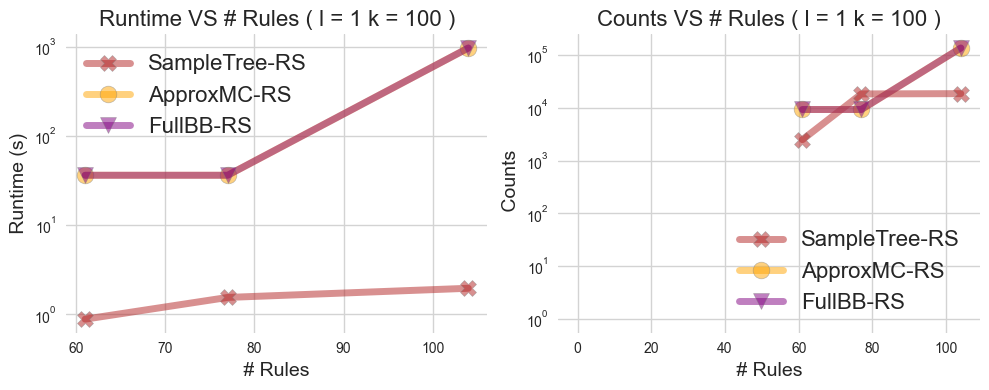

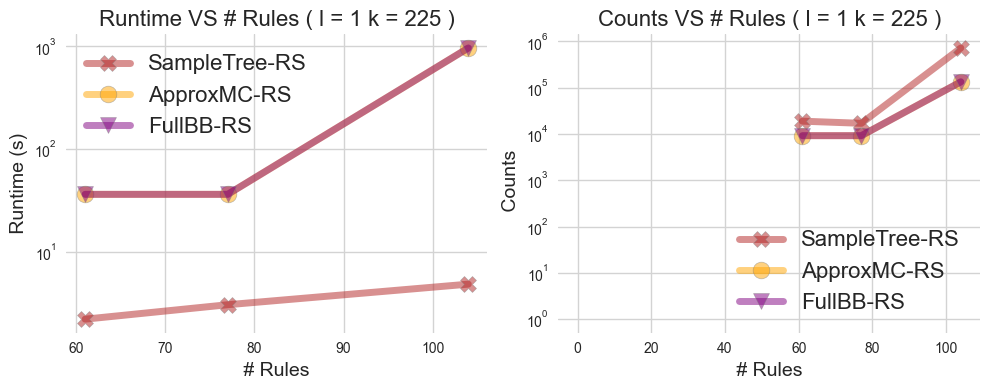

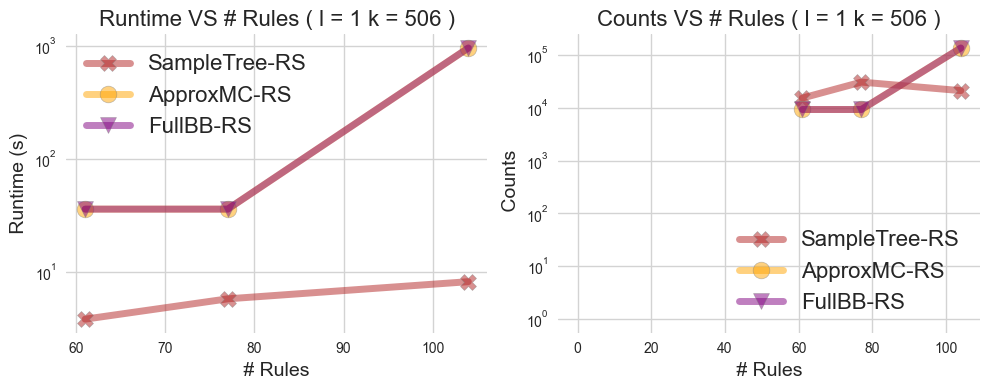

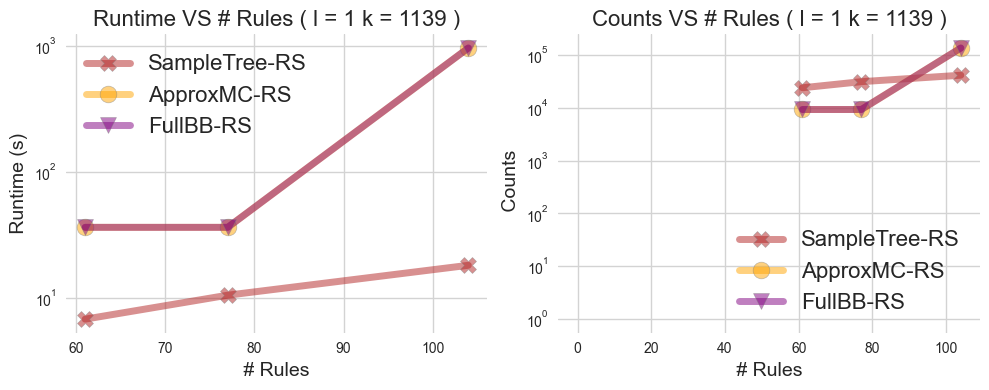

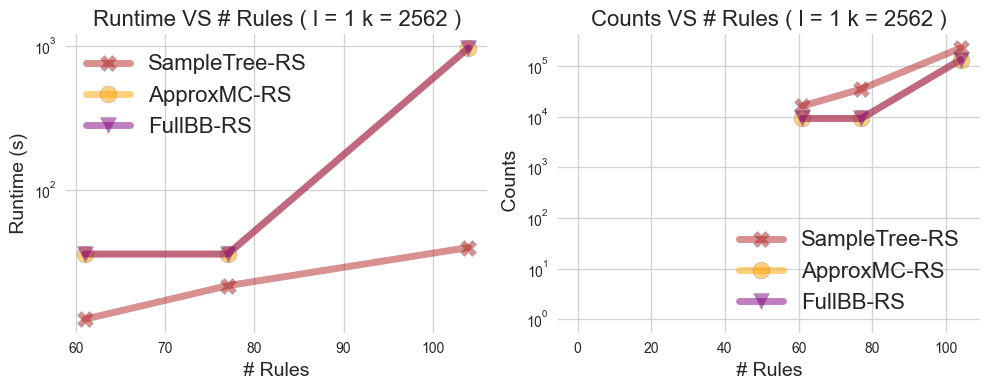

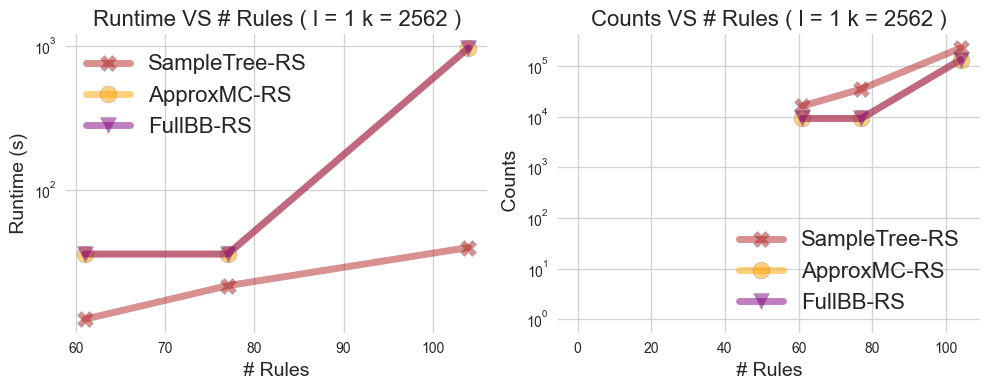

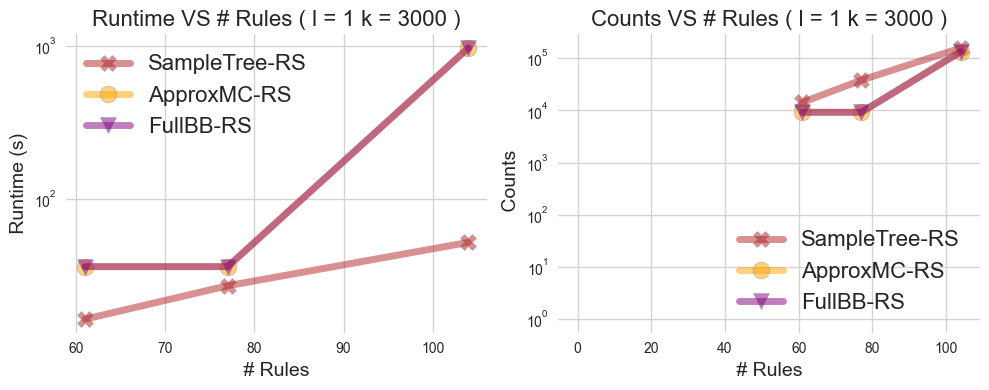

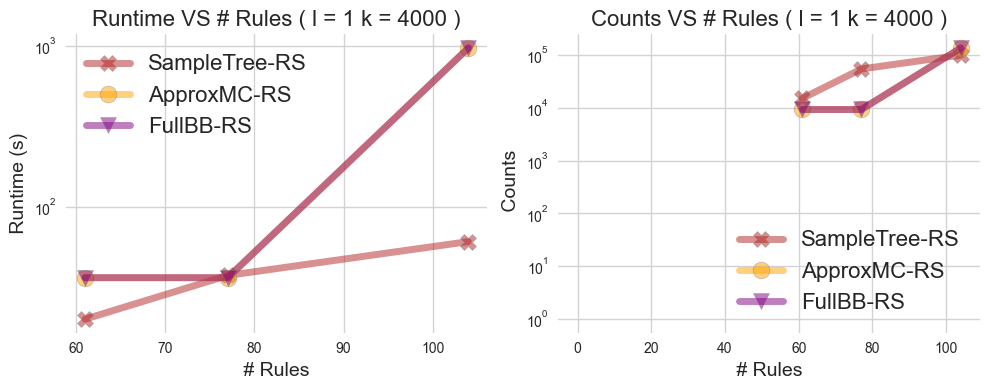

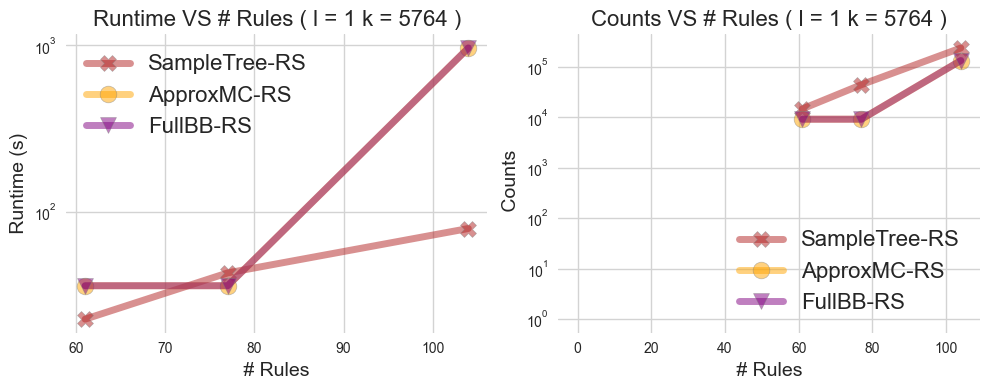

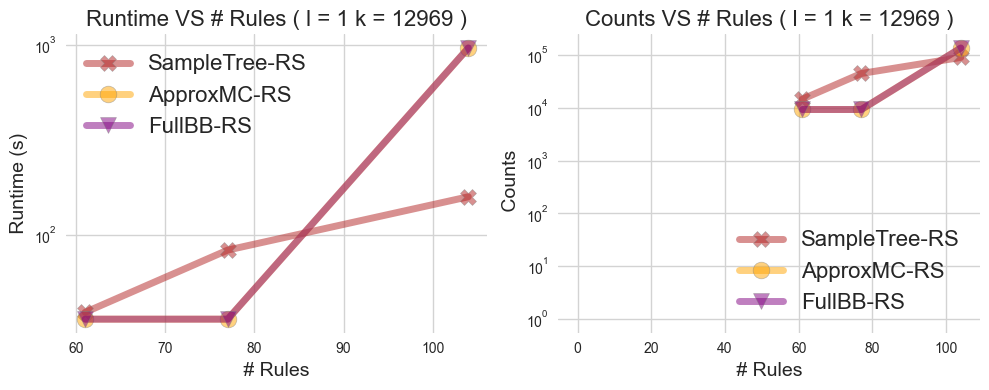

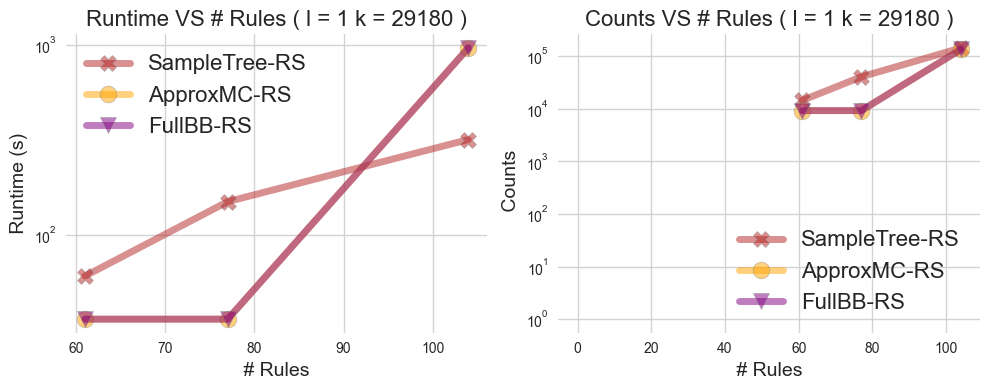

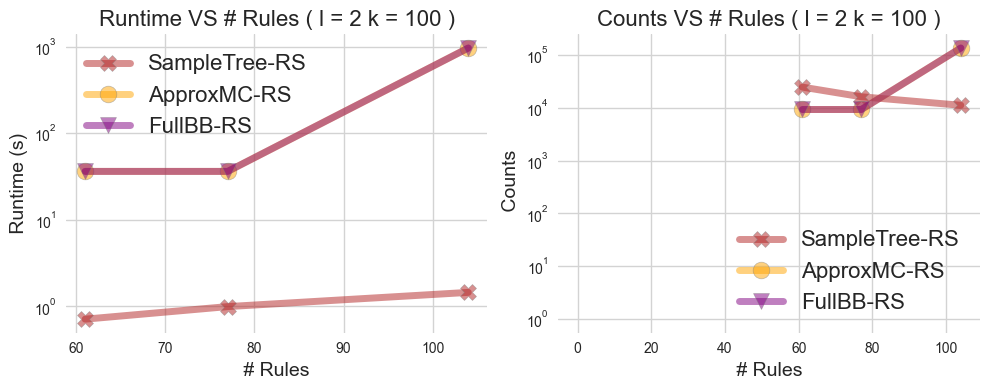

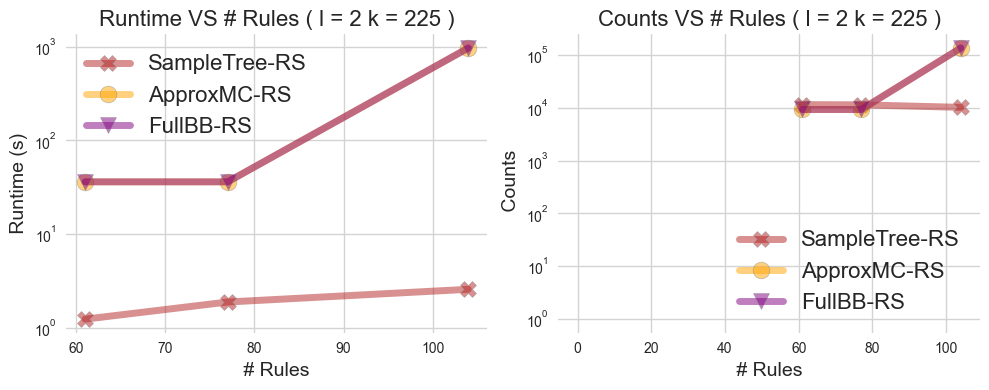

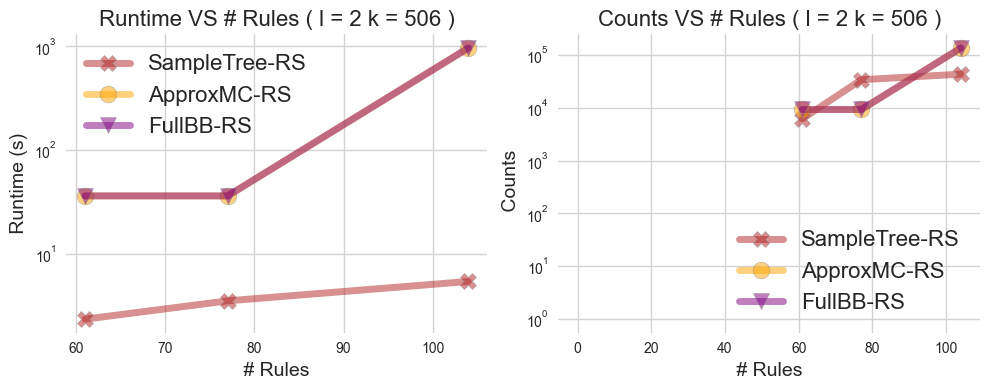

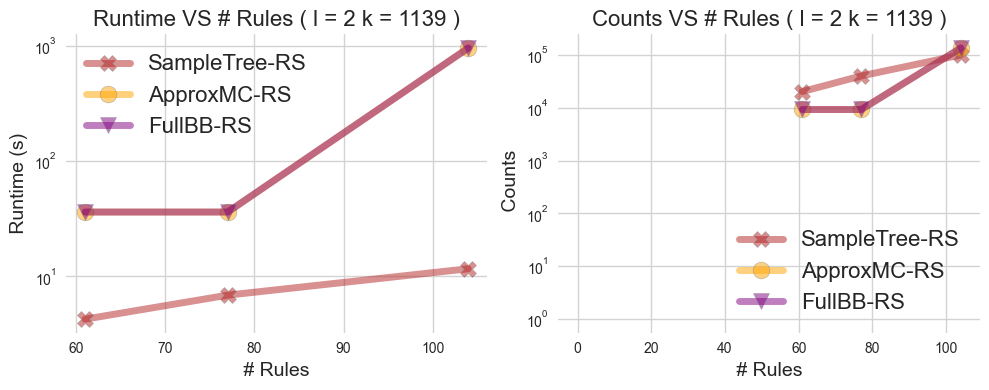

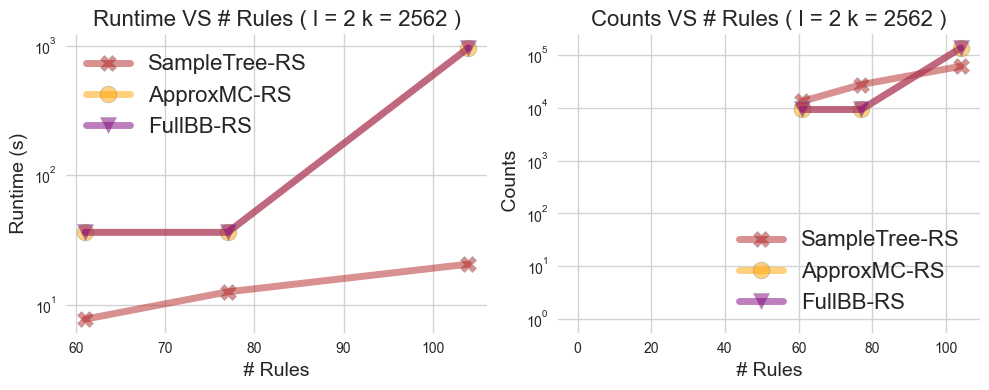

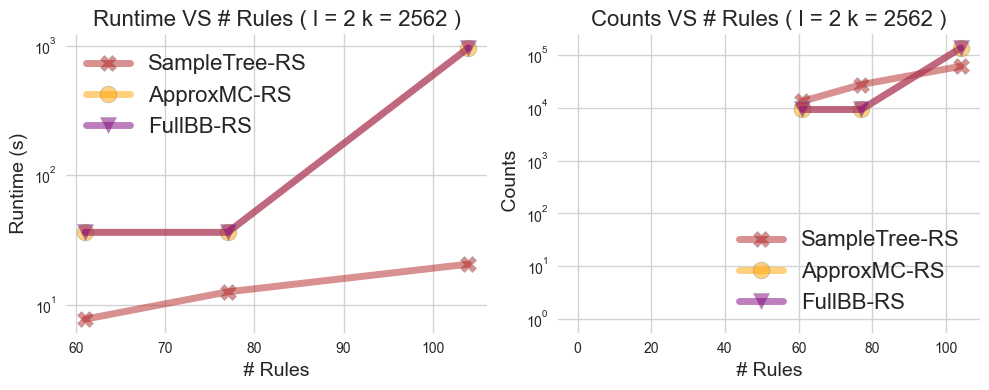

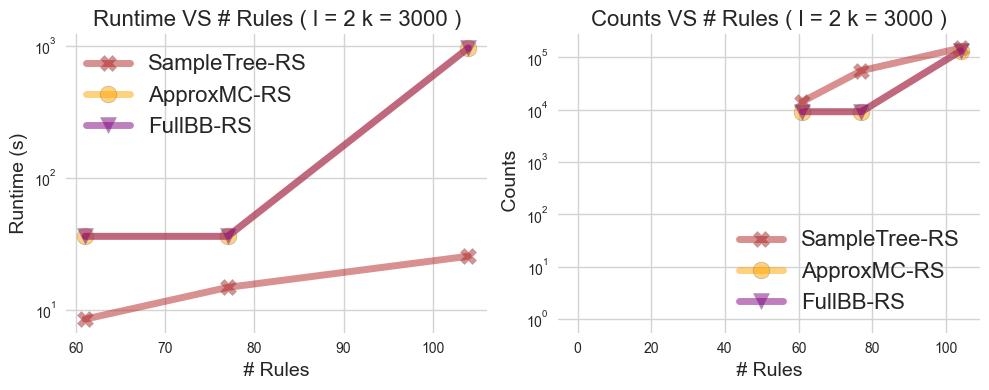

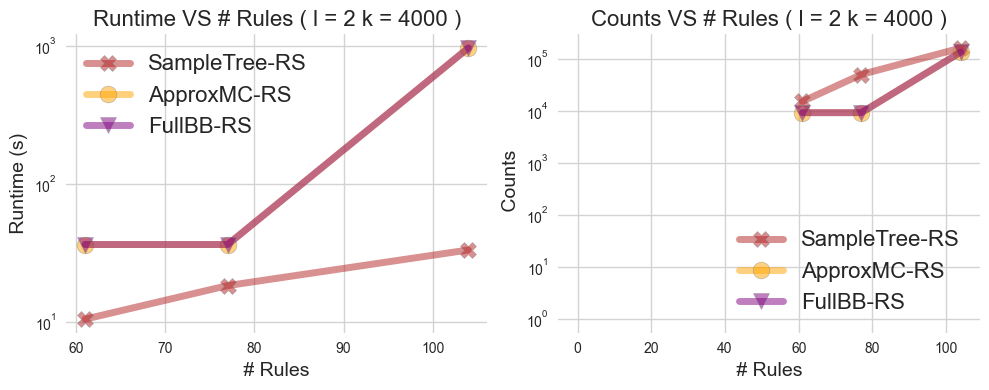

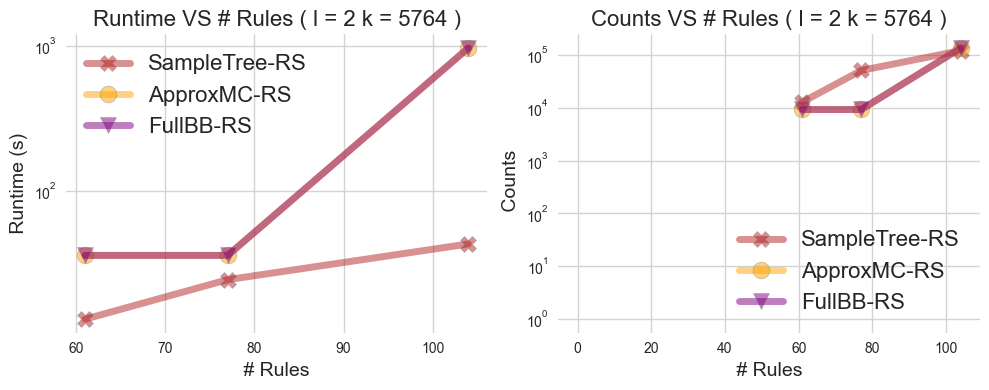

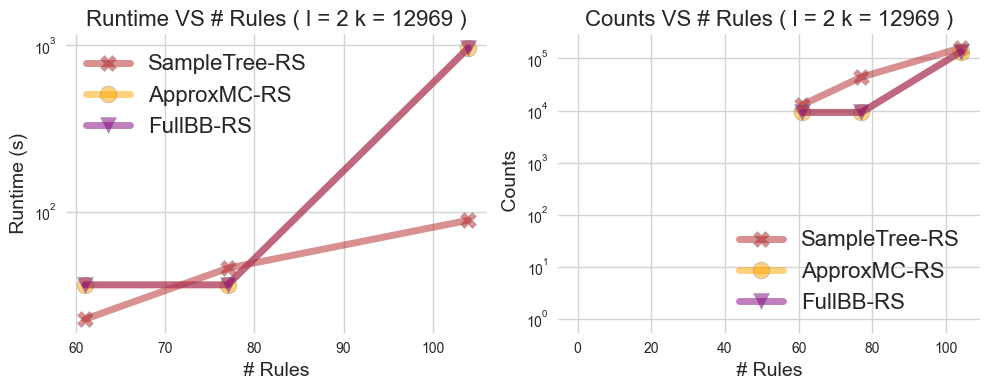

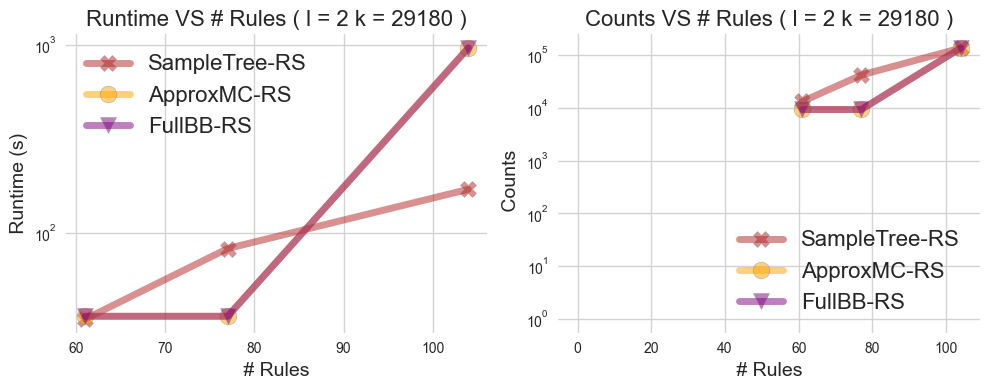

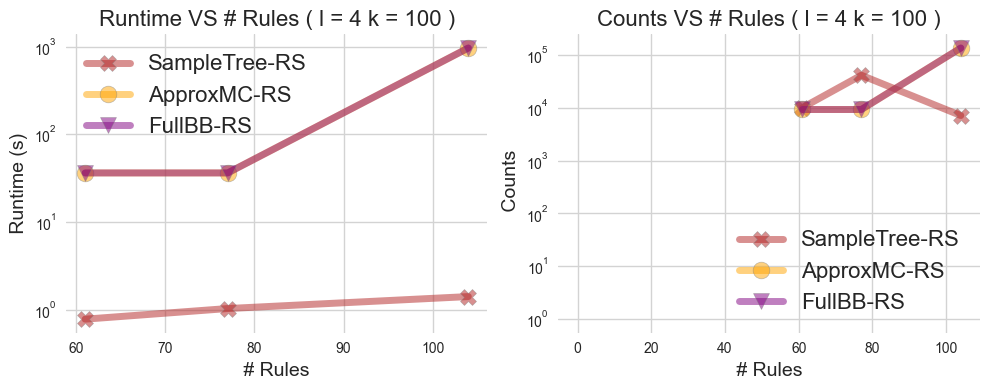

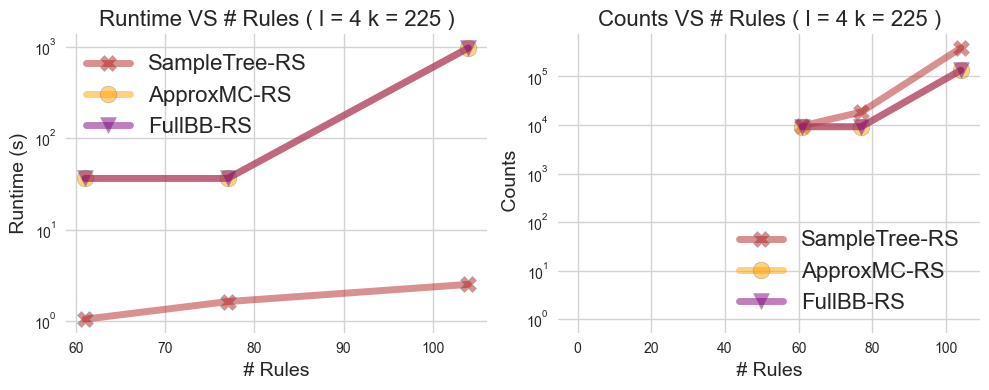

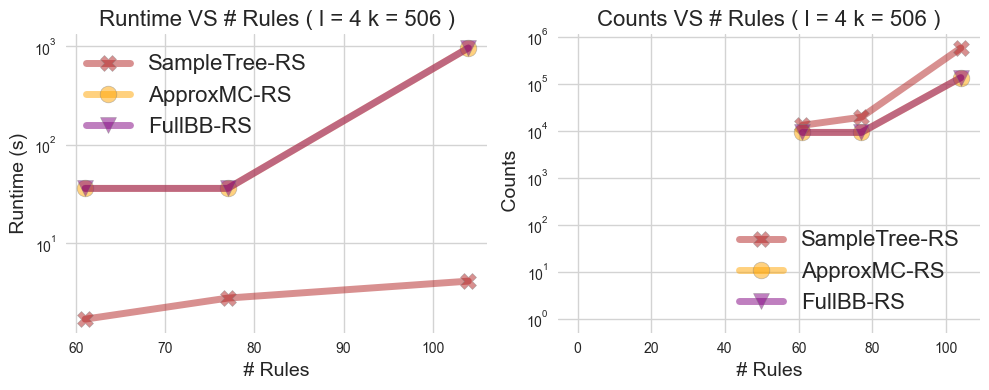

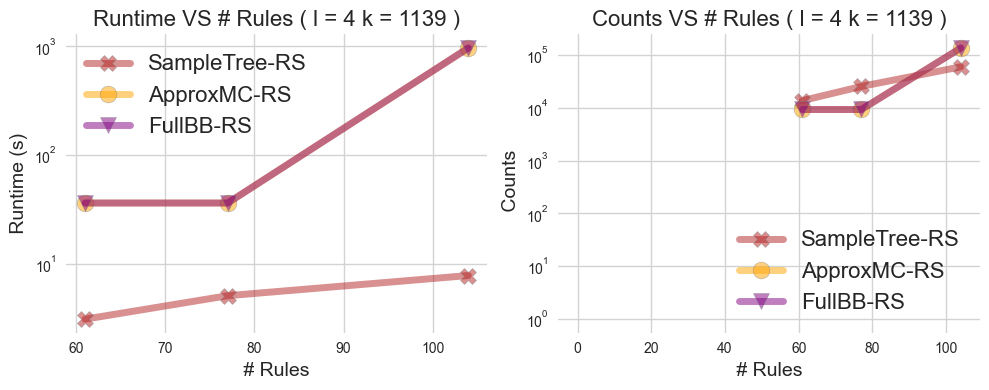

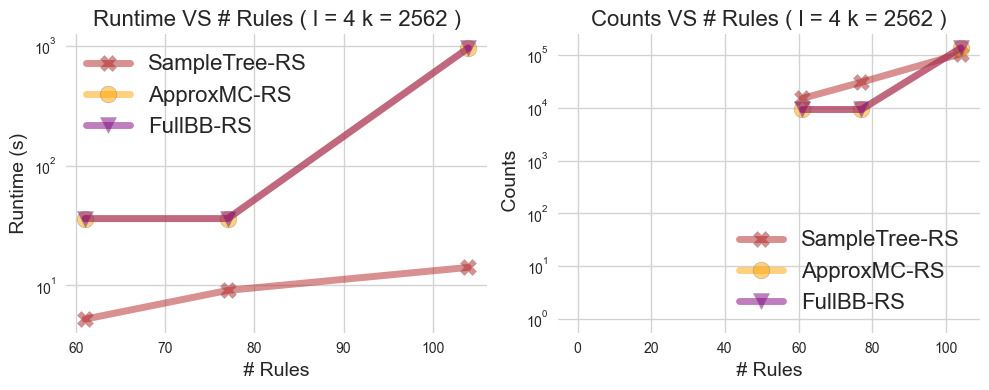

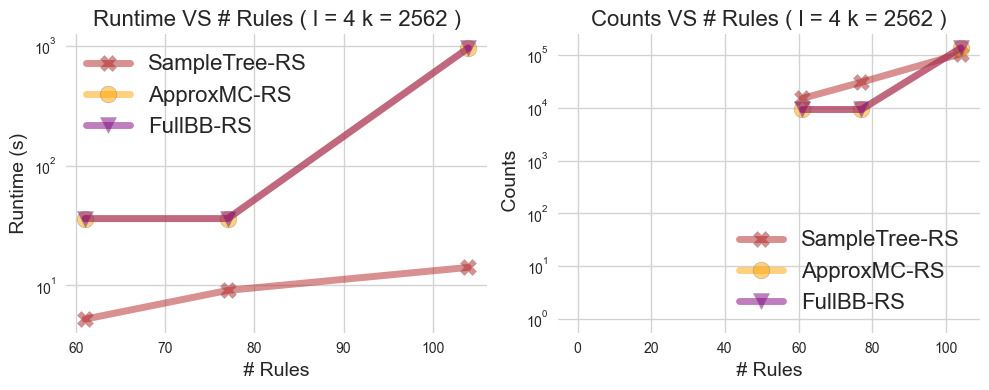

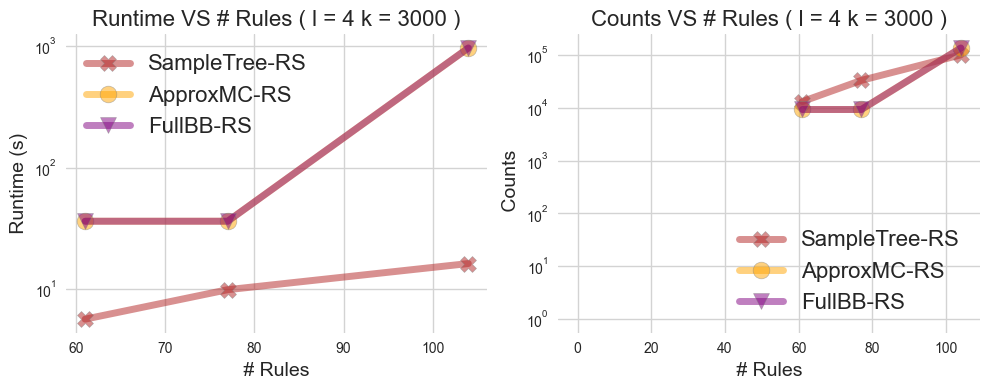

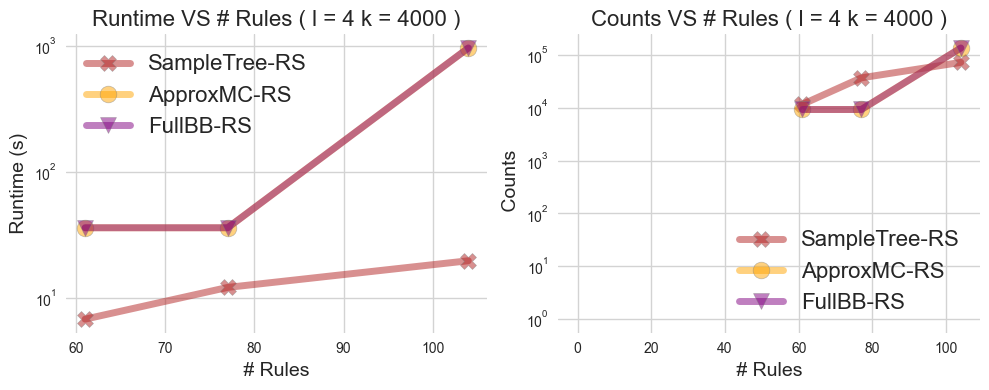

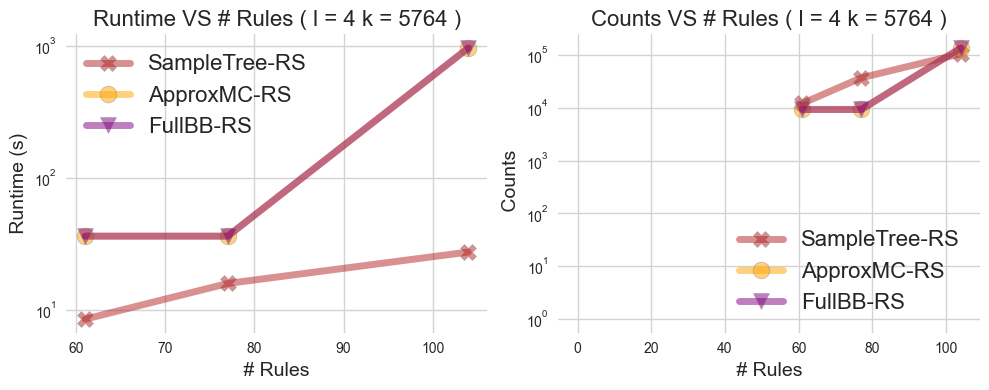

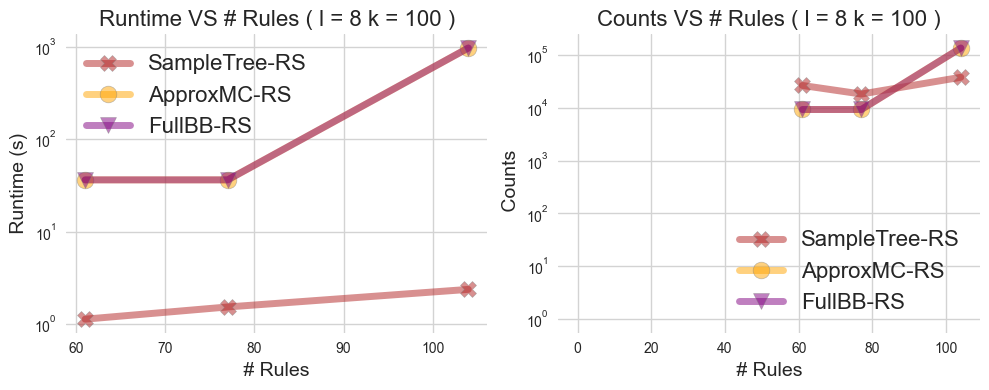

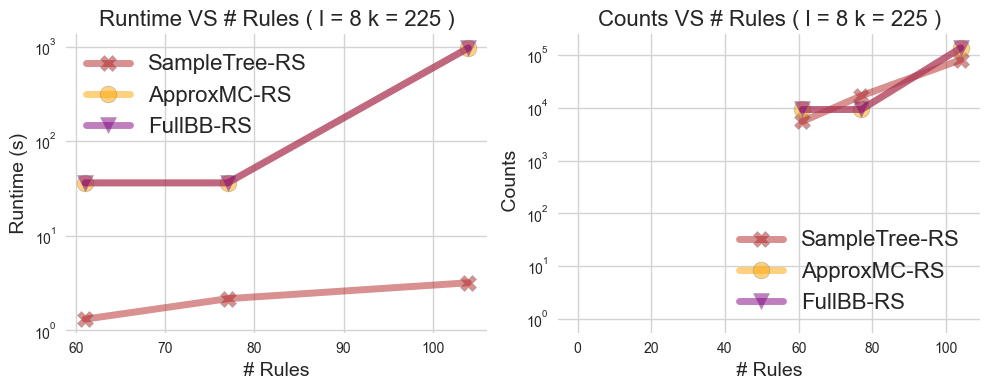

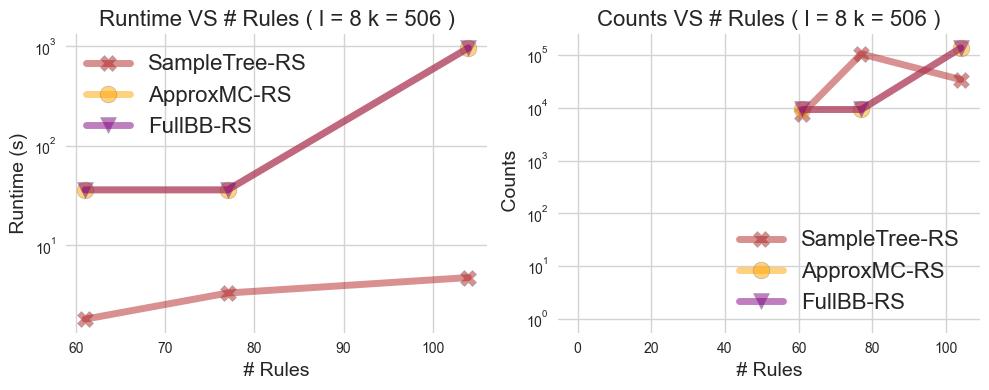

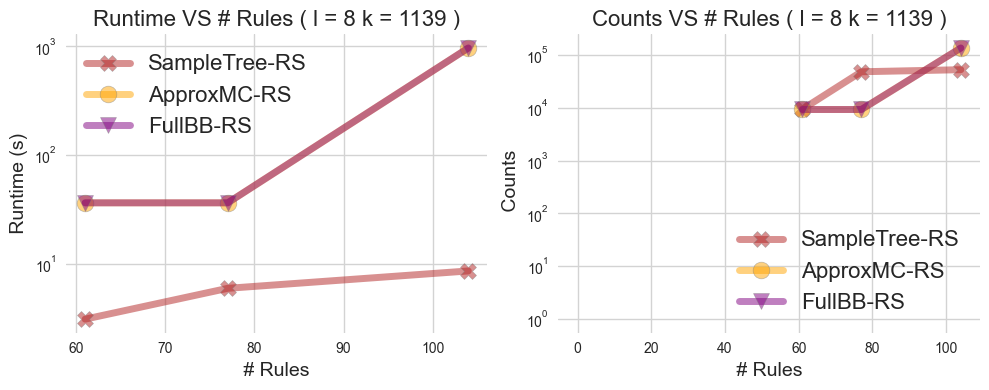

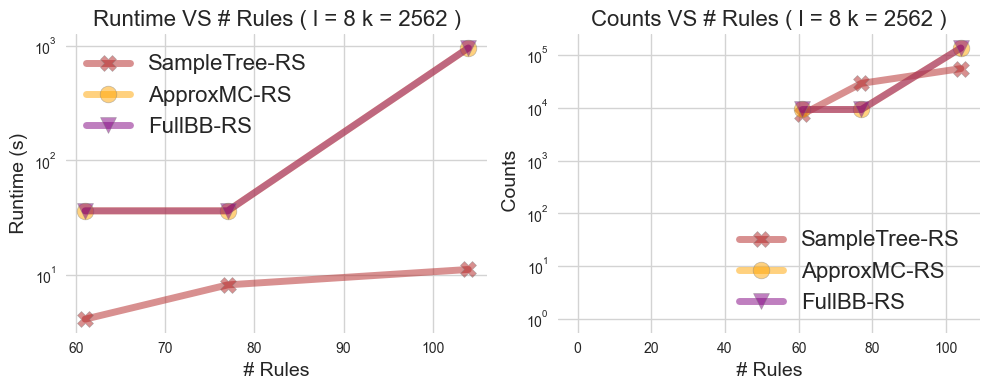

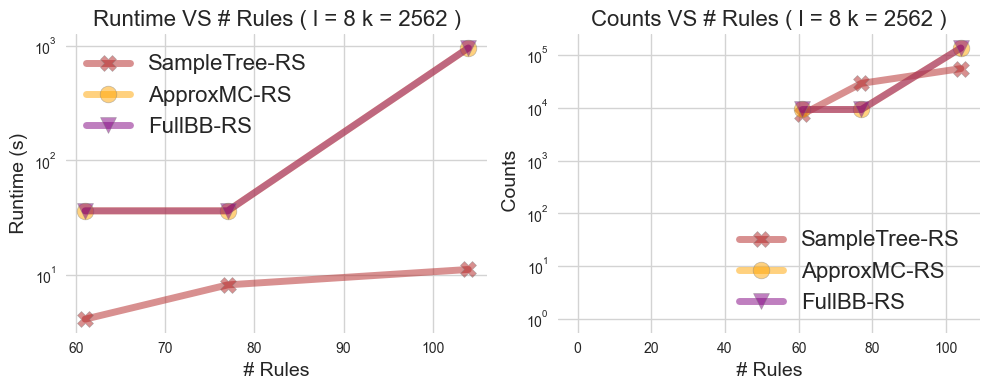

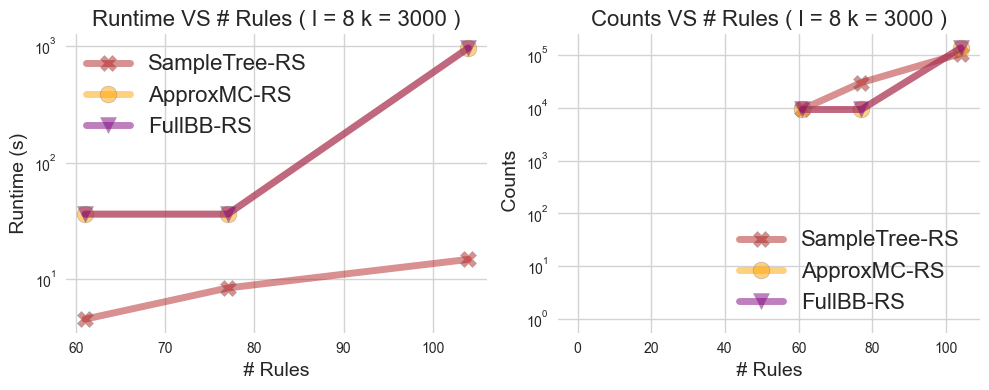

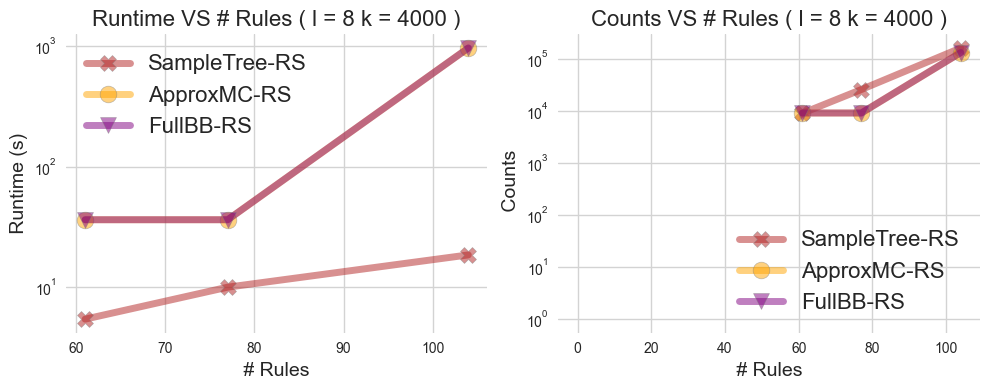

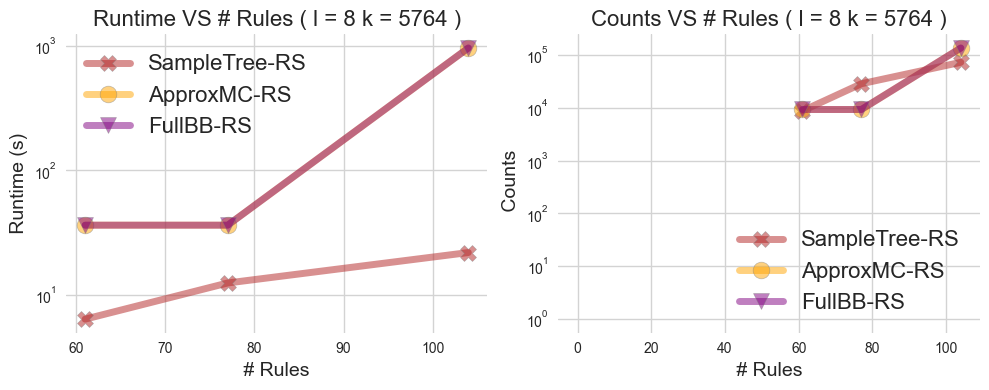

In [57]:
for l in [1, 2, 4, 8]:
    for k in [100, 225, 506, 1139, 2562, 2562, 3000, 4000, 5764, 12969, 29180]:
        if k > 5765 and l > 2:
            continue

        times = read_pickle("times_by_rules_" + str(104) + "_" + str(l) + "_" + str(k))[
            0
        ]
        counts = read_pickle(
            "counts_by_rules_" + str(104) + "_" + str(l) + "_" + str(k)
        )[0]

        times_MC = []
        counts_MC = []

        times_GT = []
        counts_GT = []

        for n_rules in [61, 77, 104]:
            this_times_MC = read_pickle("all_averages_times_MC_" + str(n_rules))[0]

            times_MC.append(this_times_MC[0])

            this_cnts_MC = read_pickle("all_averages_counts_MC_" + str(n_rules))[0]

            counts_MC.append(this_cnts_MC[0])

            this_times_GT = read_pickle("all_averages_times_GT_" + str(n_rules))[0]

            times_GT.append(this_times_GT[0])

            this_cnts_GT = read_pickle("all_averages_counts_GT_" + str(n_rules))[0]

            counts_GT.append(this_cnts_MC[0])

        # plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
        mpl.rcParams["axes.facecolor"] = "white"
        mpl.rcParams["grid.color"] = "lightgray"
        mpl.rcParams["mathtext.default"] = "regular"
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        # Plot the first data on the first subplot
        # ax1.plot([61 , 77, 104], y1, color='red')
        # ax1.set_title('Plot 1')

        x = [61, 77, 104]

        # print(times_MC)

        ax1.plot(
            x,
            times,
            marker="X",
            color="firebrick",
            label="SampleTree-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        ax1.plot(
            x,
            times_MC,
            marker="o",
            color="orange",
            label="ApproxMC-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        # plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        ax1.plot(
            x,
            times_GT,
            marker="v",
            color="purple",
            label="FullBB-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        ax1.legend(fontsize=16)

        ax1.set_title(
            "Runtime VS # Rules ( l = " + str(l) + " k = " + str(k) + " )", fontsize=16
        )

        ax1.set_xlabel(" # Rules ", fontsize=14)

        ax1.set_ylabel(" Runtime (s) ", fontsize=14)

        ax1.set_yscale("log")  # Set y-axis to logarithmic scale

        ax2.plot(
            x,
            counts,
            marker="X",
            color="firebrick",
            label="SampleTree-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        ax2.plot(
            x,
            counts_MC,
            marker="o",
            color="orange",
            label="ApproxMC-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        # plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        ax2.plot(
            x,
            counts_GT,
            marker="v",
            color="purple",
            label="FullBB-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        ax2.legend(fontsize=16)

        ax2.set_title(
            "Counts VS # Rules ( l = " + str(l) + " k = " + str(k) + " )", fontsize=16
        )

        ax2.set_xlabel(" # Rules ", fontsize=14)

        ax2.set_ylabel(" Counts", fontsize=14)

        ax2.set_yscale("log")  # Set y-axis to logarithmic scale

        (hB,) = plot(
            [1, 1],
            "firebrick",
            marker="X",
            linewidth=3,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.8,
        )
        (hHP,) = plot(
            [1, 1],
            "orange",
            marker="o",
            linewidth=3,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.8,
        )
        (hS,) = plot(
            [1, 1],
            "purple",
            marker="v",
            linewidth=3,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.8,
        )
        #   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        #   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        # legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
        # legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
        hB.set_visible(False)
        hS.set_visible(False)
        hHP.set_visible(False)

        # Adjust spacing between subplots
        plt.tight_layout()

        plt.savefig("sample_tree_by_rules_" + str(l) + "_" + str(k) + "_log.pdf")

        # Display the plots
        plt.show()

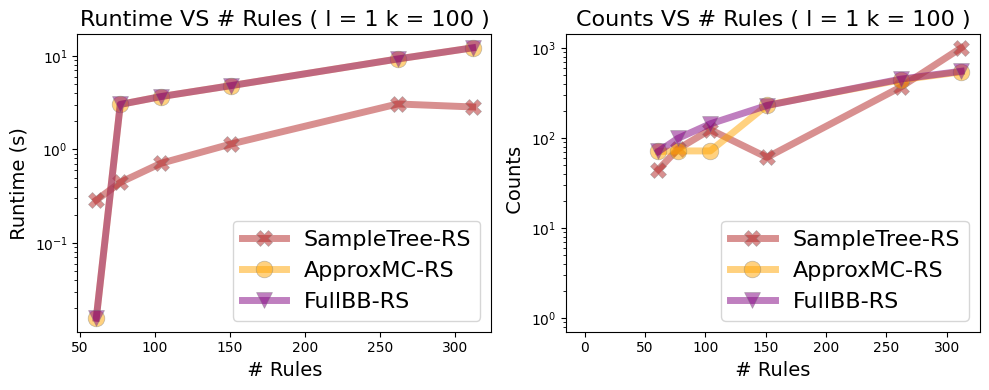

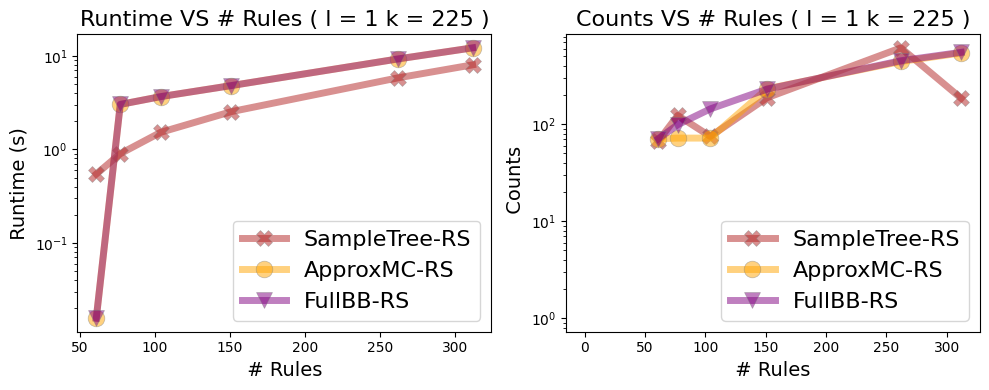

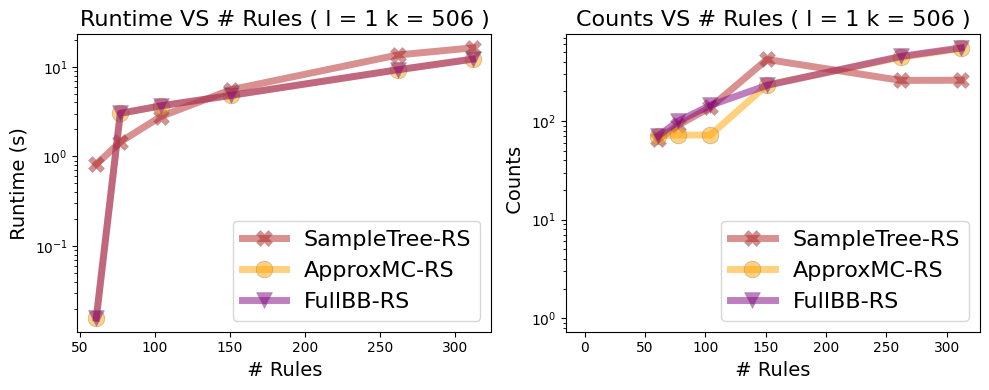

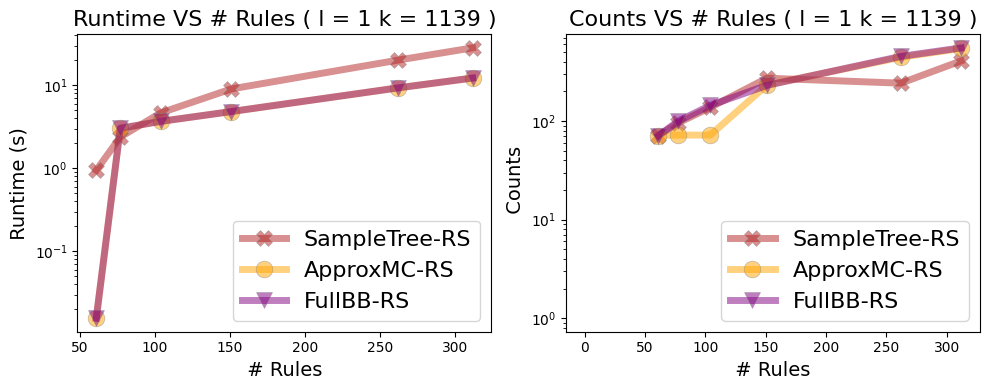

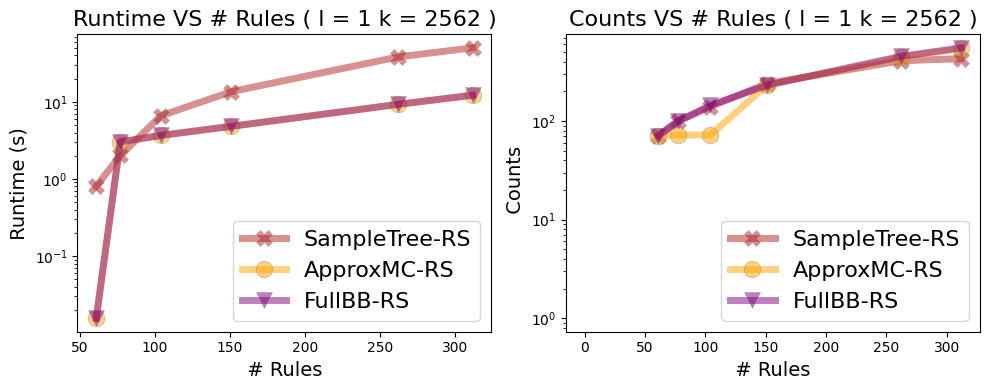

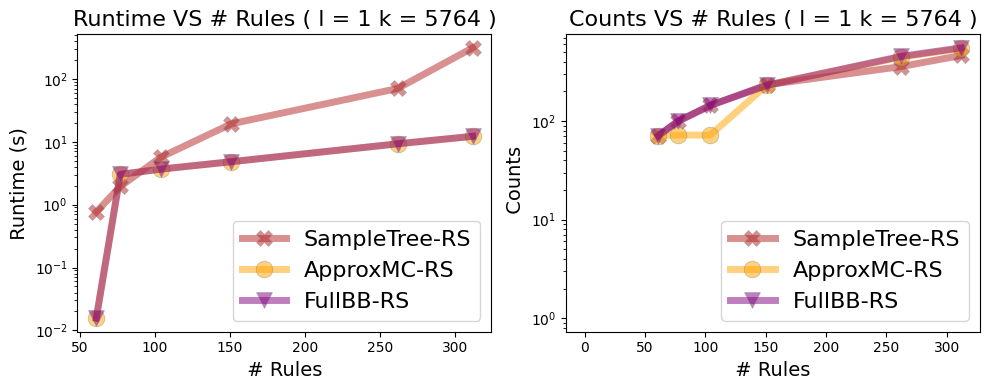

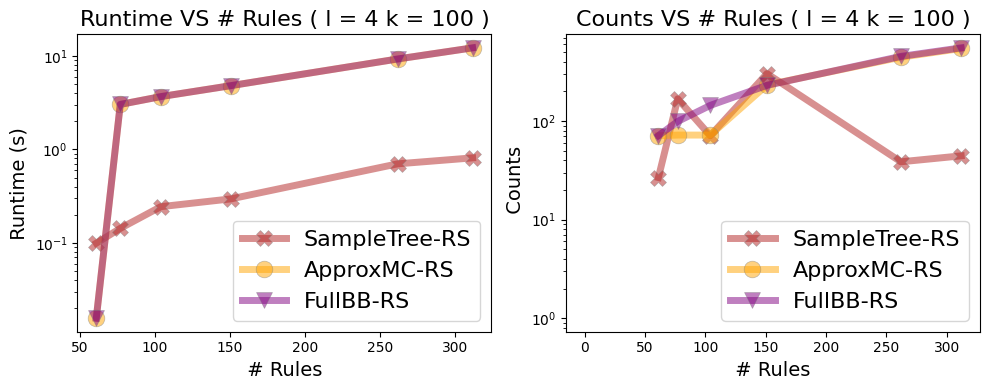

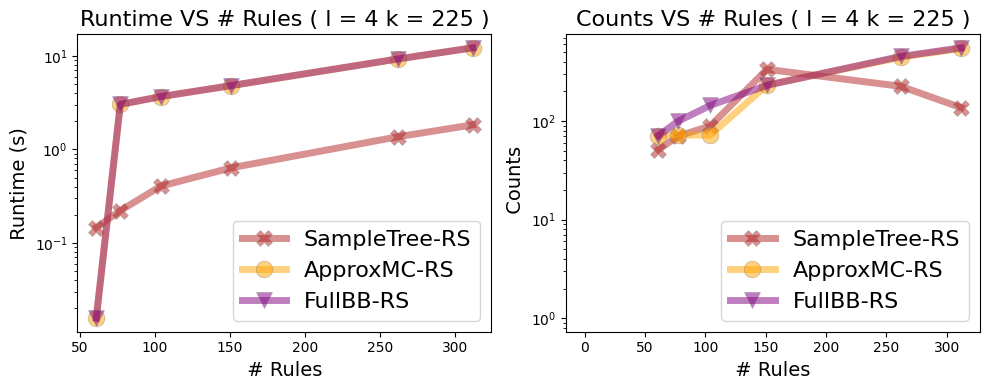

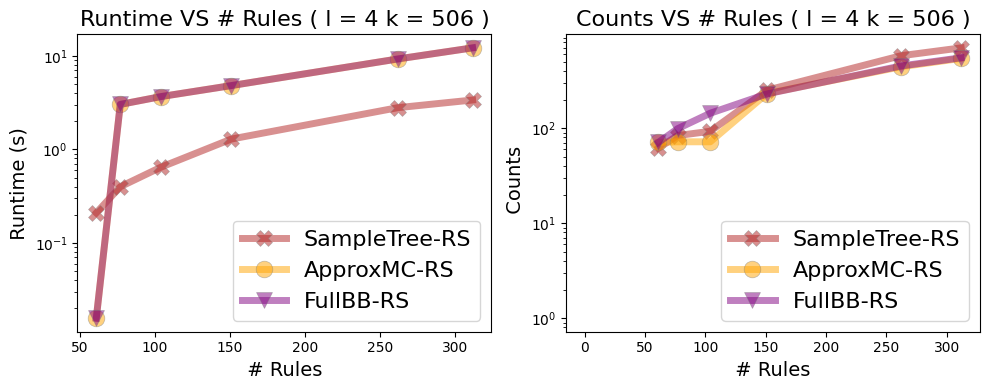

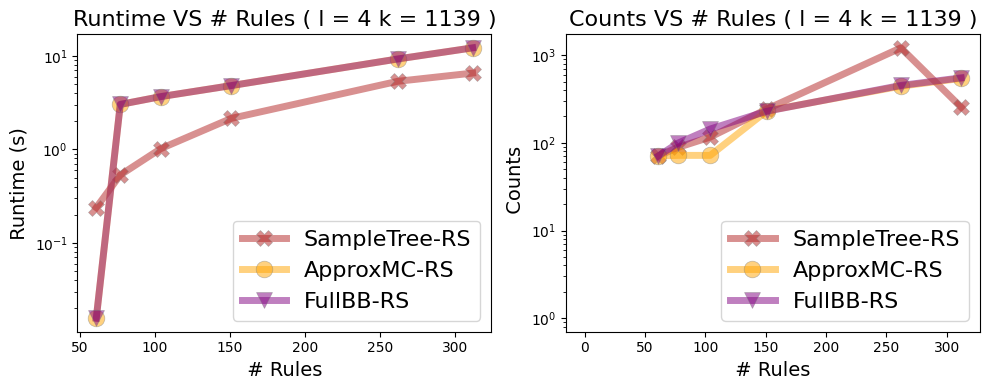

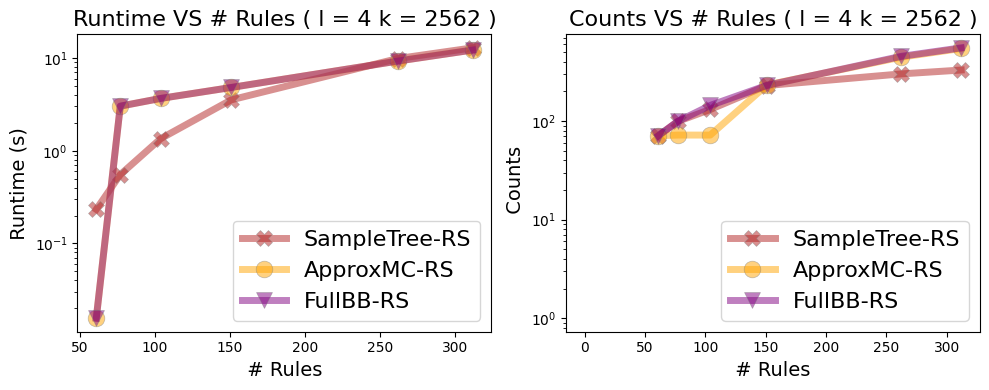

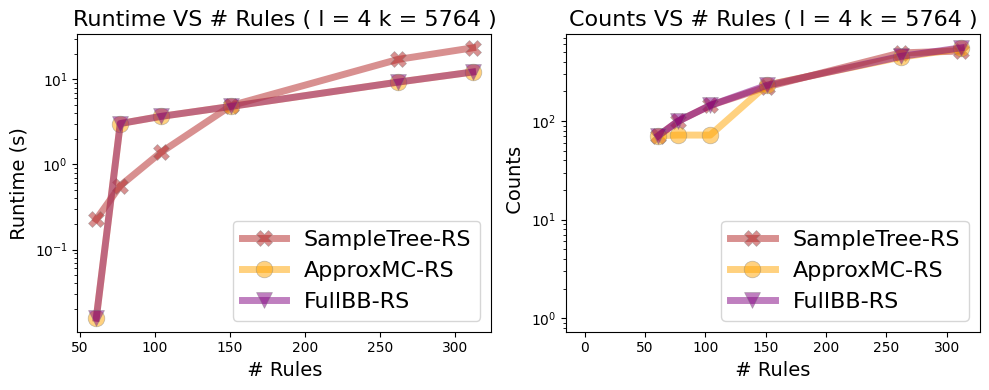

In [21]:
for l in [1, 4]:
    for k in [100, 225, 506, 1139, 2562, 5764]:
        # if k > 5765 and l > 2:
        #    continue

        times = read_pickle(
            "times_by_rules_2_" + str(312) + "_" + str(l) + "_" + str(k)
        )[0]
        counts = read_pickle(
            "counts_by_rules_2_" + str(312) + "_" + str(l) + "_" + str(k)
        )[0]

        times_MC = []
        counts_MC = []

        times_GT = []
        counts_GT = []

        # for n_rules in all_n_rules:

        times_MC = read_pickle("all_averages_times_MC_" + str(312))[0]

        # "times_MC.append(this_times_MC[0])

        cnts_MC = read_pickle("all_averages_counts_MC_" + str(312))[0]

        # counts_MC.append(this_cnts_MC[0])

        times_GT = read_pickle("all_averages_times_GT_" + str(312))[0]

        #   times_GT.append(this_times_GT[0])

        cnts_GT = read_pickle("all_averages_counts_GT_" + str(312))[0]

        # counts_GT.append(this_cnts_MC[0])

        # plt.style.use(['seaborn-notebook', 'seaborn-darkgrid'])
        mpl.rcParams["axes.facecolor"] = "white"
        mpl.rcParams["grid.color"] = "lightgray"
        mpl.rcParams["mathtext.default"] = "regular"
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        # Plot the first data on the first subplot
        # ax1.plot([61 , 77, 104], y1, color='red')
        # ax1.set_title('Plot 1')

        all_n_rules = [61, 77, 104, 151, 262, 312]

        x = all_n_rules

        # print(times_MC)

        ax1.plot(
            x,
            times,
            marker="X",
            color="firebrick",
            label="SampleTree-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        ax1.plot(
            x,
            times_MC,
            marker="o",
            color="orange",
            label="ApproxMC-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        # plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        ax1.plot(
            x,
            times_GT,
            marker="v",
            color="purple",
            label="FullBB-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        ax1.legend(fontsize=16)

        ax1.set_title(
            "Runtime VS # Rules ( l = " + str(l) + " k = " + str(k) + " )", fontsize=16
        )

        ax1.set_xlabel(" # Rules ", fontsize=14)

        ax1.set_ylabel(" Runtime (s) ", fontsize=14)

        ax1.set_yscale("log")  # Set y-axis to logarithmic scale

        ax2.plot(
            x,
            counts,
            marker="X",
            color="firebrick",
            label="SampleTree-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        ax2.plot(
            x,
            cnts_MC,
            marker="o",
            color="orange",
            label="ApproxMC-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        # plt.plot(alllent_sequence, all_naive_se_times_ha, marker='P', color = "green" , linewidth=3 , markersize = 10 ,markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        ax2.plot(
            x,
            cnts_GT,
            marker="v",
            color="purple",
            label="FullBB-RS",
            linewidth=5,
            markersize=12,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.5,
        )

        ax2.legend(fontsize=16)

        ax2.set_title(
            "Counts VS # Rules ( l = " + str(l) + " k = " + str(k) + " )", fontsize=16
        )

        ax2.set_xlabel(" # Rules ", fontsize=14)

        ax2.set_ylabel(" Counts", fontsize=14)

        ax2.set_yscale("log")  # Set y-axis to logarithmic scale

        (hB,) = plot(
            [1, 1],
            "firebrick",
            marker="X",
            linewidth=3,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.8,
        )
        (hHP,) = plot(
            [1, 1],
            "orange",
            marker="o",
            linewidth=3,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.8,
        )
        (hS,) = plot(
            [1, 1],
            "purple",
            marker="v",
            linewidth=3,
            markersize=10,
            markeredgewidth=0.5,
            markeredgecolor="grey",
            alpha=0.8,
        )
        #   hD, = plot([1,1],'salmon' , marker='D' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        #   hF, = plot([1,1], 'brown' , marker='P' ,  linewidth=3  , markersize = 10 , markeredgewidth=0.5, markeredgecolor= "grey" , alpha = 0.8)
        # legend(( hB, hHP, hS,), ( "SampleTree-RS" , "ApproxMC-RS",   "FullBB-RS") ,loc='upper center', bbox_to_anchor=(-1, 1.25 ), ncol=3, fancybox=False, shadow=False, borderaxespad=0, fontsize = 14 )
        # legend(( hB, hHP, hS, hD, hF), ( "Viterbi" , "Dijkstra",   "DijkstraBound", "BidirectionalDijkstra" , "BidirectionalDijkstraBound" ) ,loc='upper center', bbox_to_anchor=(0.5, 1.21 ), ncol=3, fancybox=True, shadow=True, borderaxespad=0 )
        hB.set_visible(False)
        hS.set_visible(False)
        hHP.set_visible(False)

        # Adjust spacing between subplots
        plt.tight_layout()

        plt.savefig("sample_tree_by_rules_3_" + str(l) + "_" + str(k) + "_log.pdf")

        # Display the plots
        plt.show()

In [ ]:
logger.setLevel(logging.WARN)

num_pts = 1000

ub = 0.8
lmbd = 0.1
delta = 0.8
eps = 0.8
show_progres = True
rand_seed = 1234

ray.init(num_cpus=4)

In [ ]:
test_cnt = approx_mc2(
    rules,
    y,
    lmbd=lmbd,
    ub=ub,
    delta=delta,
    eps=eps,
    rand_seed=rand_seed,
    show_progress=show_progres,
    parallel=True,
    log_level=logging.WARN,
)

In [ ]:
ref_count = get_ground_truth_count(rules, y, lmbd, ub)